К настоящему моменту лучший результат достигнут со значением параметров params = {'depth': 7, 'l2': 5.5, 'rate': 0.055, 'T': 1.5}.

1) Повторить и зафиксировать результат.

2) Вычислить feature importance.

3) Попробовать подложить feature importance в регрессор и сравнить результаты.

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import Pool

import os
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def trainCatBoost(trainSet, targetSet, params= {'depth': 7, 'rate': 0.03, 'l2': 8, 'T': 1},
                  folds= 5, maxIter= 2000, verbose= True, dirName= '/tmp/porto/catboost/'):
    # create log directory
    dirName = dirName + str(params.get('depth')) + '_' + str(params.get('rate')) + \
              '_' + str(params.get('l2')) + '_' + str(params.get('T'))

    try:
        os.makedirs(dirName)
    except Exception as inst:
        print inst  # __str__ allows args to be printed directly

    treeList = list()
    scoreList = list()
    modelList = list()
    prob = np.zeros([trainSet.shape[0]])

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    for i, (train_index, val_index) in enumerate(skf.split(trainSet, targetSet)):
        print 'Folds %d' % i
        model = CatBoostClassifier(verbose=verbose, iterations=maxIter, eval_metric="AUC",
                                   depth=params['depth'], learning_rate=params['rate'],
                                   l2_leaf_reg=params['l2'], bagging_temperature=params['T'],
                                   od_type='Iter', od_wait=100,
                                   train_dir=dirName +"/"+ str(i), random_seed=i,
                                   gradient_iterations = 4, rsm= 0.9)

        # create pool
        trainPool = Pool(trainSet.iloc[train_index], targetSet.iloc[train_index],
                         feature_names=trainSet.columns.tolist())

        valPool = Pool(trainSet.iloc[val_index], targetSet.iloc[val_index],
                         feature_names=trainSet.columns.tolist())

        # fit and estimate the model
        model.fit(trainPool, eval_set=valPool, use_best_model=True)
        prob[val_index] = model.predict_proba(valPool)[:, 1]
        localScore = roc_auc_score(targetSet.iloc[val_index], prob[val_index])

        treeList.append(model.tree_count_)
        scoreList.append(localScore)
        modelList.append(model)
        print 'Local score is %f, tree number is %d' % (localScore, model.tree_count_)
        
    score = roc_auc_score(targetSet, prob)
    print 'ROC-AUC is %f, Gini is %f' %  (score ,2*score-1)
    return [score, treeList, scoreList, modelList]

In [9]:
def prepareData(rawData, drop_calc_features = True):
    """
    Return Pandas dataframe for training.
    :return: pandas dataframe
    """

    #rawData = pd.read_csv('../data/train.csv', index_col='id')

    # drop _calc_ features
    dropList = list()
    
    if drop_calc_features:
        for fName in rawData.columns.tolist():
            if fName.find('_calc_') > (-1):
                dropList.append(fName)
        df = rawData.drop(dropList, axis=1)
    else:
        df = rawData
    
    # squared feature "ps_car_15"
    df = df.assign(ps_car_15_mod = np.power(df.ps_car_15,2).astype(int)).drop("ps_car_15", axis = 1)

    # inverse one-hot-encoding for ind_06 % ind_09
    df = df.assign(ps_ind_69_cat = 0*df.ps_ind_06_bin+df.ps_ind_07_bin+2*df.ps_ind_08_bin+3*df.ps_ind_09_bin)
    df.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin'], inplace=True, axis = 1)

    #drop "ind_14"
    df.drop('ps_ind_14', axis = 1, inplace = True)

    return df

In [23]:
def plotFeatureImportance(cfs,df_col_name):
    inds = np.argsort(np.array(cfs))
    
    kArr = np.array(df_col_name)[inds]
    vArr = np.array(cfs)[inds]
    
    res = {k:v for (k,v) in zip(kArr,vArr)}
    
    plt.figure(figsize = [15,20])
    plt.barh(range(len(cfs)), vArr, tick_label = kArr, color="r", align="center")
    plt.ylim([-1, len(df_col_name)])
    plt.title('Feature importance')
    
    return res

In [10]:
def getPredictions(X_train, y_train, X_test, params, n_seed = 5, n_iter = 1000, fName = None):
    prob = np.zeros([X_test.shape[0],n_seed])
    dirName= '/tmp/porto/catboost/'
    
    # create pool
    trainPool = Pool(X_train, y_train)
    testPool =  Pool(X_test)
    
    for seed in range(0,n_seed):
        model = CatBoostClassifier(verbose=True, iterations= n_iter, eval_metric="AUC",
                                           depth=params['depth'], learning_rate=params['rate'],
                                           l2_leaf_reg=params['l2'], bagging_temperature=params['T'],
                                           od_type='Iter', od_wait=100,
                                           train_dir=dirName +"/"+ str(seed), random_seed= seed,
                                           gradient_iterations = 4, rsm= 0.9)
         
        model.fit(trainPool)
        prob[:,seed] = model.predict_proba(testPool)[:,1]
    
    df = pd.DataFrame(prob.mean(axis = 1), columns=['target'], index=X_test.index)
    if fName:
        df.to_csv(fName,index_label='id')
    
    return df

Do not delete calculated features.

In [11]:
# get train data
train = prepareData(pd.read_csv('./data/train.csv', index_col='id'), drop_calc_features= False)
test = prepareData(pd.read_csv('./data/test.csv', index_col='id'), drop_calc_features= False)

In [7]:
getResult = lambda x: trainCatBoost(train.drop("target", axis= 1), train.target, params= params, verbose=False)

In [10]:
params = {'depth': 7, 'l2': 5.5, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

Folds 0
Local score is 0.631454, tree number is 487
Folds 1
Local score is 0.644478, tree number is 547
Folds 2
Local score is 0.642380, tree number is 431
Folds 3
Local score is 0.644954, tree number is 360
Folds 4
Local score is 0.643083, tree number is 336
ROC-AUC is 0.641205, Gini is 0.282411


In [15]:
np.array(treeList).std()

78.295338303119934

Параметры params = {'depth': 7, 'l2': 5.5, 'rate': 0.055, 'T': 1.5} дают на валидационном наборе средний скор 0.282411. Количество деревьев 432+-78. 

Попробую эти параметры и количество деревьев 1.5*432 =  650

In [19]:
getPredictions(train.drop("target", axis= 1), train.target, test, params= params, n_iter= 650, fName= 'submission22.csv')

Borders for float features generated
0:	learn 0.588202588	total: 405ms	remaining: 4m 22s
1:	learn 0.6018191722	total: 811ms	remaining: 4m 22s
2:	learn 0.601411176	total: 1.24s	remaining: 4m 27s
3:	learn 0.6030717031	total: 1.54s	remaining: 4m 8s
4:	learn 0.6026860689	total: 2.03s	remaining: 4m 22s
5:	learn 0.6071550168	total: 2.44s	remaining: 4m 21s
6:	learn 0.6069471447	total: 2.88s	remaining: 4m 25s
7:	learn 0.6093986106	total: 3.35s	remaining: 4m 29s
8:	learn 0.6096497513	total: 3.81s	remaining: 4m 31s
9:	learn 0.6082174886	total: 4.21s	remaining: 4m 29s
10:	learn 0.6103140278	total: 4.66s	remaining: 4m 30s
11:	learn 0.6103153441	total: 5.01s	remaining: 4m 26s
12:	learn 0.6087853483	total: 5.46s	remaining: 4m 27s
13:	learn 0.6112058368	total: 5.92s	remaining: 4m 28s
14:	learn 0.6127755806	total: 6.46s	remaining: 4m 33s
15:	learn 0.6129145852	total: 6.93s	remaining: 4m 34s
16:	learn 0.6157713674	total: 7.39s	remaining: 4m 35s
17:	learn 0.6176559034	total: 7.85s	remaining: 4m 35s
18:	

152:	learn 0.6476869767	total: 1m 11s	remaining: 3m 53s
153:	learn 0.647854719	total: 1m 12s	remaining: 3m 53s
154:	learn 0.6479622301	total: 1m 12s	remaining: 3m 52s
155:	learn 0.6480900724	total: 1m 13s	remaining: 3m 52s
156:	learn 0.6481919444	total: 1m 13s	remaining: 3m 51s
157:	learn 0.6482676056	total: 1m 14s	remaining: 3m 51s
158:	learn 0.6483924677	total: 1m 14s	remaining: 3m 50s
159:	learn 0.6484783656	total: 1m 15s	remaining: 3m 50s
160:	learn 0.6486556408	total: 1m 15s	remaining: 3m 49s
161:	learn 0.6487259653	total: 1m 16s	remaining: 3m 49s
162:	learn 0.6490045421	total: 1m 16s	remaining: 3m 48s
163:	learn 0.6491290855	total: 1m 17s	remaining: 3m 48s
164:	learn 0.6492226598	total: 1m 17s	remaining: 3m 47s
165:	learn 0.6493907647	total: 1m 17s	remaining: 3m 47s
166:	learn 0.6494621251	total: 1m 18s	remaining: 3m 46s
167:	learn 0.6495289472	total: 1m 18s	remaining: 3m 46s
168:	learn 0.6497060029	total: 1m 19s	remaining: 3m 45s
169:	learn 0.6498874141	total: 1m 19s	remaining: 

300:	learn 0.6601683681	total: 2m 20s	remaining: 2m 43s
301:	learn 0.6602414456	total: 2m 21s	remaining: 2m 42s
302:	learn 0.6602940863	total: 2m 21s	remaining: 2m 42s
303:	learn 0.6603698716	total: 2m 22s	remaining: 2m 41s
304:	learn 0.6604634126	total: 2m 22s	remaining: 2m 41s
305:	learn 0.6605058477	total: 2m 23s	remaining: 2m 40s
306:	learn 0.6605491024	total: 2m 23s	remaining: 2m 40s
307:	learn 0.6605988915	total: 2m 24s	remaining: 2m 39s
308:	learn 0.6606577435	total: 2m 24s	remaining: 2m 39s
309:	learn 0.6606920015	total: 2m 24s	remaining: 2m 38s
310:	learn 0.6607207754	total: 2m 25s	remaining: 2m 38s
311:	learn 0.6607592671	total: 2m 25s	remaining: 2m 38s
312:	learn 0.6608180035	total: 2m 26s	remaining: 2m 37s
313:	learn 0.6608640439	total: 2m 26s	remaining: 2m 37s
314:	learn 0.6609102491	total: 2m 27s	remaining: 2m 36s
315:	learn 0.6610107581	total: 2m 27s	remaining: 2m 36s
316:	learn 0.6610613246	total: 2m 28s	remaining: 2m 35s
317:	learn 0.6610917751	total: 2m 28s	remaining:

448:	learn 0.6689980819	total: 3m 30s	remaining: 1m 34s
449:	learn 0.6690737311	total: 3m 30s	remaining: 1m 33s
450:	learn 0.6691318371	total: 3m 30s	remaining: 1m 33s
451:	learn 0.6691729143	total: 3m 31s	remaining: 1m 32s
452:	learn 0.6692108848	total: 3m 31s	remaining: 1m 32s
453:	learn 0.6692660133	total: 3m 32s	remaining: 1m 31s
454:	learn 0.6693212011	total: 3m 32s	remaining: 1m 31s
455:	learn 0.6693682148	total: 3m 33s	remaining: 1m 30s
456:	learn 0.6694212594	total: 3m 33s	remaining: 1m 30s
457:	learn 0.6694434394	total: 3m 34s	remaining: 1m 29s
458:	learn 0.6694705977	total: 3m 34s	remaining: 1m 29s
459:	learn 0.6695187854	total: 3m 35s	remaining: 1m 28s
460:	learn 0.6695599565	total: 3m 35s	remaining: 1m 28s
461:	learn 0.6696158273	total: 3m 35s	remaining: 1m 27s
462:	learn 0.6696331627	total: 3m 36s	remaining: 1m 27s
463:	learn 0.6697142832	total: 3m 36s	remaining: 1m 26s
464:	learn 0.6697786154	total: 3m 37s	remaining: 1m 26s
465:	learn 0.6698436859	total: 3m 37s	remaining:

598:	learn 0.6766976199	total: 4m 39s	remaining: 23.8s
599:	learn 0.6767751952	total: 4m 39s	remaining: 23.3s
600:	learn 0.6768085743	total: 4m 40s	remaining: 22.9s
601:	learn 0.6768202949	total: 4m 40s	remaining: 22.4s
602:	learn 0.6768355145	total: 4m 41s	remaining: 21.9s
603:	learn 0.6768746323	total: 4m 41s	remaining: 21.5s
604:	learn 0.676907033	total: 4m 42s	remaining: 21s
605:	learn 0.6769941774	total: 4m 43s	remaining: 20.5s
606:	learn 0.6770418192	total: 4m 43s	remaining: 20.1s
607:	learn 0.6770485133	total: 4m 44s	remaining: 19.6s
608:	learn 0.6771071401	total: 4m 44s	remaining: 19.2s
609:	learn 0.677165253	total: 4m 45s	remaining: 18.7s
610:	learn 0.6772157649	total: 4m 45s	remaining: 18.2s
611:	learn 0.6772864571	total: 4m 46s	remaining: 17.8s
612:	learn 0.6773025104	total: 4m 46s	remaining: 17.3s
613:	learn 0.6773875272	total: 4m 46s	remaining: 16.8s
614:	learn 0.6774761152	total: 4m 47s	remaining: 16.4s
615:	learn 0.6775092126	total: 4m 47s	remaining: 15.9s
616:	learn 0.6

100:	learn 0.6418854354	total: 47.8s	remaining: 4m 19s
101:	learn 0.6419922989	total: 48.3s	remaining: 4m 19s
102:	learn 0.6421679659	total: 48.8s	remaining: 4m 19s
103:	learn 0.6423238923	total: 49.3s	remaining: 4m 18s
104:	learn 0.6425800529	total: 49.7s	remaining: 4m 18s
105:	learn 0.642688345	total: 50.2s	remaining: 4m 17s
106:	learn 0.642887855	total: 50.6s	remaining: 4m 16s
107:	learn 0.6430468433	total: 51.1s	remaining: 4m 16s
108:	learn 0.6432603177	total: 51.5s	remaining: 4m 15s
109:	learn 0.6433818611	total: 52s	remaining: 4m 15s
110:	learn 0.643480672	total: 52.4s	remaining: 4m 14s
111:	learn 0.6435857408	total: 52.9s	remaining: 4m 14s
112:	learn 0.6436617054	total: 53.3s	remaining: 4m 13s
113:	learn 0.643817608	total: 53.8s	remaining: 4m 12s
114:	learn 0.6438769144	total: 54.3s	remaining: 4m 12s
115:	learn 0.6440116367	total: 54.7s	remaining: 4m 11s
116:	learn 0.6442063401	total: 55.2s	remaining: 4m 11s
117:	learn 0.6442811883	total: 55.7s	remaining: 4m 11s
118:	learn 0.644

248:	learn 0.6578118439	total: 1m 57s	remaining: 3m 8s
249:	learn 0.657829775	total: 1m 57s	remaining: 3m 8s
250:	learn 0.6578871071	total: 1m 57s	remaining: 3m 7s
251:	learn 0.6579819175	total: 1m 58s	remaining: 3m 7s
252:	learn 0.6580797247	total: 1m 58s	remaining: 3m 6s
253:	learn 0.6581045239	total: 1m 59s	remaining: 3m 6s
254:	learn 0.6582059392	total: 1m 59s	remaining: 3m 5s
255:	learn 0.6582492619	total: 2m	remaining: 3m 5s
256:	learn 0.6583401271	total: 2m	remaining: 3m 4s
257:	learn 0.6583538042	total: 2m 1s	remaining: 3m 4s
258:	learn 0.6584116218	total: 2m 1s	remaining: 3m 3s
259:	learn 0.6585446927	total: 2m 2s	remaining: 3m 3s
260:	learn 0.6585666342	total: 2m 2s	remaining: 3m 2s
261:	learn 0.658773828	total: 2m 2s	remaining: 3m 2s
262:	learn 0.6588932026	total: 2m 3s	remaining: 3m 1s
263:	learn 0.6590222248	total: 2m 3s	remaining: 3m 1s
264:	learn 0.6591586364	total: 2m 4s	remaining: 3m
265:	learn 0.6592435881	total: 2m 4s	remaining: 3m
266:	learn 0.6593271921	total: 2m 5

397:	learn 0.668603559	total: 3m 5s	remaining: 1m 57s
398:	learn 0.6686561842	total: 3m 5s	remaining: 1m 56s
399:	learn 0.6686855046	total: 3m 6s	remaining: 1m 56s
400:	learn 0.6687152286	total: 3m 6s	remaining: 1m 55s
401:	learn 0.6687953996	total: 3m 6s	remaining: 1m 55s
402:	learn 0.6688476022	total: 3m 7s	remaining: 1m 54s
403:	learn 0.668891889	total: 3m 7s	remaining: 1m 54s
404:	learn 0.6689086137	total: 3m 8s	remaining: 1m 53s
405:	learn 0.6690436396	total: 3m 8s	remaining: 1m 53s
406:	learn 0.6690721061	total: 3m 9s	remaining: 1m 52s
407:	learn 0.6691461865	total: 3m 9s	remaining: 1m 52s
408:	learn 0.6692509158	total: 3m 10s	remaining: 1m 52s
409:	learn 0.6692608775	total: 3m 10s	remaining: 1m 51s
410:	learn 0.6692935943	total: 3m 10s	remaining: 1m 51s
411:	learn 0.6693290257	total: 3m 11s	remaining: 1m 50s
412:	learn 0.6693727428	total: 3m 11s	remaining: 1m 50s
413:	learn 0.6694065023	total: 3m 12s	remaining: 1m 49s
414:	learn 0.6694849683	total: 3m 12s	remaining: 1m 49s
415:	

546:	learn 0.6766830716	total: 4m 16s	remaining: 48.3s
547:	learn 0.6767027444	total: 4m 16s	remaining: 47.8s
548:	learn 0.6767953208	total: 4m 17s	remaining: 47.3s
549:	learn 0.6768704034	total: 4m 17s	remaining: 46.9s
550:	learn 0.676935963	total: 4m 18s	remaining: 46.4s
551:	learn 0.6770354932	total: 4m 18s	remaining: 45.9s
552:	learn 0.6771309832	total: 4m 19s	remaining: 45.5s
553:	learn 0.6772504899	total: 4m 19s	remaining: 45s
554:	learn 0.6772985131	total: 4m 20s	remaining: 44.5s
555:	learn 0.6773567573	total: 4m 20s	remaining: 44.1s
556:	learn 0.6774890057	total: 4m 21s	remaining: 43.6s
557:	learn 0.6776119019	total: 4m 21s	remaining: 43.1s
558:	learn 0.6776265569	total: 4m 21s	remaining: 42.6s
559:	learn 0.6776742576	total: 4m 22s	remaining: 42.2s
560:	learn 0.6776872173	total: 4m 22s	remaining: 41.7s
561:	learn 0.677733306	total: 4m 23s	remaining: 41.2s
562:	learn 0.6778058955	total: 4m 23s	remaining: 40.8s
563:	learn 0.6778704075	total: 4m 24s	remaining: 40.3s
564:	learn 0.6

48:	learn 0.6317382787	total: 24.6s	remaining: 5m 2s
49:	learn 0.6318662234	total: 25.2s	remaining: 5m 1s
50:	learn 0.6317939741	total: 25.7s	remaining: 5m 1s
51:	learn 0.6320099804	total: 26.2s	remaining: 5m 1s
52:	learn 0.6328826472	total: 26.7s	remaining: 5m
53:	learn 0.6329434323	total: 27.2s	remaining: 5m
54:	learn 0.6330830623	total: 27.7s	remaining: 4m 59s
55:	learn 0.6333520118	total: 28.2s	remaining: 4m 58s
56:	learn 0.6336199889	total: 28.7s	remaining: 4m 58s
57:	learn 0.6338601949	total: 29.2s	remaining: 4m 57s
58:	learn 0.6340406165	total: 29.6s	remaining: 4m 57s
59:	learn 0.6343759647	total: 30.2s	remaining: 4m 56s
60:	learn 0.6343981769	total: 30.7s	remaining: 4m 56s
61:	learn 0.6347331706	total: 31.2s	remaining: 4m 55s
62:	learn 0.6347780972	total: 31.7s	remaining: 4m 55s
63:	learn 0.6352228979	total: 32.2s	remaining: 4m 54s
64:	learn 0.635316884	total: 32.7s	remaining: 4m 54s
65:	learn 0.6355181829	total: 33.3s	remaining: 4m 54s
66:	learn 0.6356625354	total: 33.8s	remai

198:	learn 0.6525891222	total: 1m 41s	remaining: 3m 50s
199:	learn 0.6526826233	total: 1m 42s	remaining: 3m 50s
200:	learn 0.6527414717	total: 1m 42s	remaining: 3m 49s
201:	learn 0.65282224	total: 1m 43s	remaining: 3m 49s
202:	learn 0.6529287158	total: 1m 43s	remaining: 3m 48s
203:	learn 0.6531205867	total: 1m 44s	remaining: 3m 48s
204:	learn 0.6533080981	total: 1m 44s	remaining: 3m 47s
205:	learn 0.6534100722	total: 1m 45s	remaining: 3m 47s
206:	learn 0.6534856047	total: 1m 45s	remaining: 3m 46s
207:	learn 0.6535147639	total: 1m 46s	remaining: 3m 46s
208:	learn 0.6536312184	total: 1m 46s	remaining: 3m 45s
209:	learn 0.6537381095	total: 1m 47s	remaining: 3m 44s
210:	learn 0.6538845494	total: 1m 47s	remaining: 3m 44s
211:	learn 0.6539724707	total: 1m 48s	remaining: 3m 43s
212:	learn 0.6539834104	total: 1m 49s	remaining: 3m 43s
213:	learn 0.654057243	total: 1m 49s	remaining: 3m 43s
214:	learn 0.6541055321	total: 1m 50s	remaining: 3m 42s
215:	learn 0.6541792161	total: 1m 50s	remaining: 3m

346:	learn 0.6634999487	total: 2m 58s	remaining: 2m 35s
347:	learn 0.6635283044	total: 2m 59s	remaining: 2m 35s
348:	learn 0.6635976719	total: 2m 59s	remaining: 2m 34s
349:	learn 0.6636622792	total: 3m	remaining: 2m 34s
350:	learn 0.6638327864	total: 3m	remaining: 2m 33s
351:	learn 0.6638430251	total: 3m 1s	remaining: 2m 33s
352:	learn 0.6638539105	total: 3m 1s	remaining: 2m 32s
353:	learn 0.663903105	total: 3m 2s	remaining: 2m 32s
354:	learn 0.6639522299	total: 3m 2s	remaining: 2m 32s
355:	learn 0.664022403	total: 3m 3s	remaining: 2m 31s
356:	learn 0.6640440465	total: 3m 3s	remaining: 2m 31s
357:	learn 0.664088865	total: 3m 4s	remaining: 2m 30s
358:	learn 0.6641814625	total: 3m 5s	remaining: 2m 30s
359:	learn 0.6642005504	total: 3m 5s	remaining: 2m 29s
360:	learn 0.6642657264	total: 3m 6s	remaining: 2m 29s
361:	learn 0.6643739258	total: 3m 6s	remaining: 2m 28s
362:	learn 0.6643935421	total: 3m 7s	remaining: 2m 28s
363:	learn 0.6644394708	total: 3m 7s	remaining: 2m 27s
364:	learn 0.664

494:	learn 0.6716299892	total: 4m 19s	remaining: 1m 21s
495:	learn 0.6716945482	total: 4m 20s	remaining: 1m 20s
496:	learn 0.6717790492	total: 4m 20s	remaining: 1m 20s
497:	learn 0.6718452105	total: 4m 21s	remaining: 1m 19s
498:	learn 0.6718758857	total: 4m 21s	remaining: 1m 19s
499:	learn 0.6719356337	total: 4m 22s	remaining: 1m 18s
500:	learn 0.672006337	total: 4m 22s	remaining: 1m 18s
501:	learn 0.6720834664	total: 4m 23s	remaining: 1m 17s
502:	learn 0.6721181918	total: 4m 23s	remaining: 1m 17s
503:	learn 0.6722357338	total: 4m 24s	remaining: 1m 16s
504:	learn 0.6722657674	total: 4m 25s	remaining: 1m 16s
505:	learn 0.6723407709	total: 4m 25s	remaining: 1m 15s
506:	learn 0.6723729147	total: 4m 26s	remaining: 1m 15s
507:	learn 0.6724225954	total: 4m 26s	remaining: 1m 14s
508:	learn 0.6724553924	total: 4m 27s	remaining: 1m 14s
509:	learn 0.672504893	total: 4m 27s	remaining: 1m 13s
510:	learn 0.6725501655	total: 4m 28s	remaining: 1m 12s
511:	learn 0.6726206084	total: 4m 28s	remaining: 1

644:	learn 0.6791804108	total: 5m 37s	remaining: 2.62s
645:	learn 0.6791897007	total: 5m 37s	remaining: 2.09s
646:	learn 0.6792679149	total: 5m 38s	remaining: 1.57s
647:	learn 0.6793282604	total: 5m 39s	remaining: 1.05s
648:	learn 0.6793870319	total: 5m 39s	remaining: 523ms
649:	learn 0.6794716373	total: 5m 39s	remaining: 0us
Borders for float features generated
0:	learn 0.5648555215	total: 448ms	remaining: 4m 50s
1:	learn 0.5654892091	total: 914ms	remaining: 4m 56s
2:	learn 0.5860589695	total: 1.39s	remaining: 4m 59s
3:	learn 0.5868590398	total: 1.88s	remaining: 5m 3s
4:	learn 0.5927389582	total: 2.36s	remaining: 5m 4s
5:	learn 0.594848645	total: 2.69s	remaining: 4m 48s
6:	learn 0.5996084619	total: 3.19s	remaining: 4m 53s
7:	learn 0.6005757172	total: 3.63s	remaining: 4m 51s
8:	learn 0.6007702808	total: 4.17s	remaining: 4m 56s
9:	learn 0.6031322605	total: 4.63s	remaining: 4m 56s
10:	learn 0.6020006031	total: 5.06s	remaining: 4m 54s
11:	learn 0.599846701	total: 5.42s	remaining: 4m 48s
1

146:	learn 0.6463648976	total: 1m 13s	remaining: 4m 11s
147:	learn 0.6464360703	total: 1m 14s	remaining: 4m 11s
148:	learn 0.6464961112	total: 1m 14s	remaining: 4m 11s
149:	learn 0.6466133439	total: 1m 15s	remaining: 4m 10s
150:	learn 0.6466772901	total: 1m 15s	remaining: 4m 10s
151:	learn 0.6467800239	total: 1m 16s	remaining: 4m 10s
152:	learn 0.6468550908	total: 1m 16s	remaining: 4m 9s
153:	learn 0.6470337857	total: 1m 17s	remaining: 4m 9s
154:	learn 0.6470849774	total: 1m 17s	remaining: 4m 9s
155:	learn 0.6472041578	total: 1m 18s	remaining: 4m 8s
156:	learn 0.6472948607	total: 1m 19s	remaining: 4m 8s
157:	learn 0.6474179484	total: 1m 19s	remaining: 4m 8s
158:	learn 0.6474843255	total: 1m 20s	remaining: 4m 8s
159:	learn 0.6475888483	total: 1m 20s	remaining: 4m 7s
160:	learn 0.6476950612	total: 1m 21s	remaining: 4m 7s
161:	learn 0.6478156647	total: 1m 22s	remaining: 4m 7s
162:	learn 0.6478923845	total: 1m 22s	remaining: 4m 7s
163:	learn 0.6479833003	total: 1m 23s	remaining: 4m 6s
164:

294:	learn 0.6586346859	total: 2m 32s	remaining: 3m 3s
295:	learn 0.6587048297	total: 2m 33s	remaining: 3m 3s
296:	learn 0.6588242275	total: 2m 33s	remaining: 3m 2s
297:	learn 0.6589092963	total: 2m 34s	remaining: 3m 2s
298:	learn 0.658993397	total: 2m 34s	remaining: 3m 1s
299:	learn 0.6590146123	total: 2m 35s	remaining: 3m 1s
300:	learn 0.6591234008	total: 2m 36s	remaining: 3m
301:	learn 0.6592659432	total: 2m 36s	remaining: 3m
302:	learn 0.6593135668	total: 2m 37s	remaining: 2m 59s
303:	learn 0.6593587327	total: 2m 37s	remaining: 2m 59s
304:	learn 0.6594481384	total: 2m 38s	remaining: 2m 58s
305:	learn 0.6594857292	total: 2m 38s	remaining: 2m 58s
306:	learn 0.6595705572	total: 2m 39s	remaining: 2m 57s
307:	learn 0.6595826588	total: 2m 39s	remaining: 2m 57s
308:	learn 0.6597344581	total: 2m 39s	remaining: 2m 56s
309:	learn 0.659832897	total: 2m 40s	remaining: 2m 55s
310:	learn 0.6599472668	total: 2m 40s	remaining: 2m 55s
311:	learn 0.6600427828	total: 2m 41s	remaining: 2m 54s
312:	lea

442:	learn 0.6685567933	total: 3m 49s	remaining: 1m 47s
443:	learn 0.6685905	total: 3m 50s	remaining: 1m 46s
444:	learn 0.6686392046	total: 3m 50s	remaining: 1m 46s
445:	learn 0.66865589	total: 3m 51s	remaining: 1m 45s
446:	learn 0.6686636822	total: 3m 51s	remaining: 1m 45s
447:	learn 0.668706297	total: 3m 52s	remaining: 1m 44s
448:	learn 0.6687280583	total: 3m 53s	remaining: 1m 44s
449:	learn 0.668768926	total: 3m 53s	remaining: 1m 43s
450:	learn 0.6688435002	total: 3m 54s	remaining: 1m 43s
451:	learn 0.6688971339	total: 3m 54s	remaining: 1m 42s
452:	learn 0.6689713727	total: 3m 55s	remaining: 1m 42s
453:	learn 0.6689951062	total: 3m 55s	remaining: 1m 41s
454:	learn 0.6691031386	total: 3m 56s	remaining: 1m 41s
455:	learn 0.669176542	total: 3m 56s	remaining: 1m 40s
456:	learn 0.6691952789	total: 3m 57s	remaining: 1m 40s
457:	learn 0.6692263111	total: 3m 57s	remaining: 1m 39s
458:	learn 0.6693586289	total: 3m 58s	remaining: 1m 39s
459:	learn 0.6693974189	total: 3m 58s	remaining: 1m 38s


93:	learn 0.6412631367	total: 42.3s	remaining: 4m 9s
94:	learn 0.6413213661	total: 42.7s	remaining: 4m 9s
95:	learn 0.6415877278	total: 43.2s	remaining: 4m 9s
96:	learn 0.6416484332	total: 43.6s	remaining: 4m 8s
97:	learn 0.6417580274	total: 44.1s	remaining: 4m 8s
98:	learn 0.6418720819	total: 44.5s	remaining: 4m 7s
99:	learn 0.6419892071	total: 45s	remaining: 4m 7s
100:	learn 0.6422619299	total: 45.4s	remaining: 4m 6s
101:	learn 0.6424798173	total: 45.9s	remaining: 4m 6s
102:	learn 0.6426234337	total: 46.5s	remaining: 4m 6s
103:	learn 0.6427503315	total: 46.9s	remaining: 4m 6s
104:	learn 0.642835735	total: 47.4s	remaining: 4m 6s
105:	learn 0.6431453064	total: 47.9s	remaining: 4m 5s
106:	learn 0.6432127398	total: 48.3s	remaining: 4m 5s
107:	learn 0.6433858336	total: 48.8s	remaining: 4m 4s
108:	learn 0.6435916565	total: 49.2s	remaining: 4m 4s
109:	learn 0.6437712138	total: 49.7s	remaining: 4m 3s
110:	learn 0.6438665412	total: 50.1s	remaining: 4m 3s
111:	learn 0.643934111	total: 50.7s	re

242:	learn 0.6569477021	total: 1m 51s	remaining: 3m 7s
243:	learn 0.6570109194	total: 1m 52s	remaining: 3m 6s
244:	learn 0.6570462811	total: 1m 52s	remaining: 3m 6s
245:	learn 0.657096376	total: 1m 53s	remaining: 3m 5s
246:	learn 0.6571996091	total: 1m 53s	remaining: 3m 5s
247:	learn 0.657285635	total: 1m 54s	remaining: 3m 5s
248:	learn 0.6573692108	total: 1m 54s	remaining: 3m 4s
249:	learn 0.6574618065	total: 1m 55s	remaining: 3m 4s
250:	learn 0.6576473085	total: 1m 55s	remaining: 3m 4s
251:	learn 0.6576907726	total: 1m 56s	remaining: 3m 3s
252:	learn 0.6577969825	total: 1m 56s	remaining: 3m 3s
253:	learn 0.657847553	total: 1m 57s	remaining: 3m 2s
254:	learn 0.6579252949	total: 1m 57s	remaining: 3m 2s
255:	learn 0.657993924	total: 1m 58s	remaining: 3m 2s
256:	learn 0.6580426337	total: 1m 58s	remaining: 3m 1s
257:	learn 0.6580930115	total: 1m 59s	remaining: 3m 1s
258:	learn 0.6581718902	total: 1m 59s	remaining: 3m
259:	learn 0.6582379315	total: 2m	remaining: 3m
260:	learn 0.6583243445	

391:	learn 0.6665421751	total: 3m 1s	remaining: 1m 59s
392:	learn 0.6665739513	total: 3m 1s	remaining: 1m 58s
393:	learn 0.6666308051	total: 3m 2s	remaining: 1m 58s
394:	learn 0.6667505173	total: 3m 2s	remaining: 1m 57s
395:	learn 0.6668100109	total: 3m 3s	remaining: 1m 57s
396:	learn 0.6668678725	total: 3m 3s	remaining: 1m 57s
397:	learn 0.6669336409	total: 3m 4s	remaining: 1m 56s
398:	learn 0.6669546342	total: 3m 4s	remaining: 1m 56s
399:	learn 0.6670115733	total: 3m 5s	remaining: 1m 55s
400:	learn 0.667063528	total: 3m 5s	remaining: 1m 55s
401:	learn 0.667160851	total: 3m 5s	remaining: 1m 54s
402:	learn 0.6672596506	total: 3m 6s	remaining: 1m 54s
403:	learn 0.6673189832	total: 3m 6s	remaining: 1m 53s
404:	learn 0.6673765457	total: 3m 7s	remaining: 1m 53s
405:	learn 0.667436155	total: 3m 7s	remaining: 1m 52s
406:	learn 0.6674729658	total: 3m 8s	remaining: 1m 52s
407:	learn 0.6674868944	total: 3m 8s	remaining: 1m 51s
408:	learn 0.6675238849	total: 3m 9s	remaining: 1m 51s
409:	learn 0.

540:	learn 0.674660996	total: 4m 10s	remaining: 50.4s
541:	learn 0.674763932	total: 4m 10s	remaining: 50s
542:	learn 0.6747935768	total: 4m 11s	remaining: 49.5s
543:	learn 0.6748000564	total: 4m 11s	remaining: 49s
544:	learn 0.6748189752	total: 4m 12s	remaining: 48.6s
545:	learn 0.674877331	total: 4m 12s	remaining: 48.1s
546:	learn 0.6749618891	total: 4m 13s	remaining: 47.6s
547:	learn 0.6750673785	total: 4m 13s	remaining: 47.2s
548:	learn 0.6751036521	total: 4m 13s	remaining: 46.7s
549:	learn 0.6751464696	total: 4m 14s	remaining: 46.2s
550:	learn 0.675156915	total: 4m 14s	remaining: 45.8s
551:	learn 0.6752216961	total: 4m 15s	remaining: 45.3s
552:	learn 0.6752754282	total: 4m 15s	remaining: 44.9s
553:	learn 0.6753282972	total: 4m 16s	remaining: 44.4s
554:	learn 0.6754150699	total: 4m 16s	remaining: 44s
555:	learn 0.6754959223	total: 4m 17s	remaining: 43.5s
556:	learn 0.6755836526	total: 4m 17s	remaining: 43s
557:	learn 0.6756454934	total: 4m 18s	remaining: 42.6s
558:	learn 0.675754195

,target
id,
0,0.024340
1,0.026333
2,0.024188
3,0.013645
4,0.034063
5,0.040122
6,0.015090
8,0.038529
10,0.052483


Скор 0.280

In [21]:
getPredictions(train.drop("target", axis= 1), train.target, test, params= params, n_iter= 750, fName= 'submission23.csv')

Borders for float features generated
0:	learn 0.588202588	total: 515ms	remaining: 6m 25s
1:	learn 0.6018191722	total: 961ms	remaining: 5m 59s
2:	learn 0.601411176	total: 1.39s	remaining: 5m 45s
3:	learn 0.6030717031	total: 1.66s	remaining: 5m 10s
4:	learn 0.6026860689	total: 2.15s	remaining: 5m 19s
5:	learn 0.6071550168	total: 2.55s	remaining: 5m 16s
6:	learn 0.6069471447	total: 3s	remaining: 5m 18s
7:	learn 0.6093986106	total: 3.46s	remaining: 5m 20s
8:	learn 0.6096497513	total: 4.04s	remaining: 5m 32s
9:	learn 0.6082174886	total: 4.48s	remaining: 5m 31s
10:	learn 0.6103140278	total: 4.95s	remaining: 5m 32s
11:	learn 0.6103153441	total: 5.32s	remaining: 5m 27s
12:	learn 0.6087853483	total: 5.88s	remaining: 5m 33s
13:	learn 0.6112058368	total: 6.34s	remaining: 5m 33s
14:	learn 0.6127755806	total: 6.8s	remaining: 5m 33s
15:	learn 0.6129145852	total: 7.26s	remaining: 5m 32s
16:	learn 0.6157713674	total: 7.7s	remaining: 5m 32s
17:	learn 0.6176559034	total: 8.25s	remaining: 5m 35s
18:	lear

152:	learn 0.6476869767	total: 1m 13s	remaining: 4m 45s
153:	learn 0.647854719	total: 1m 13s	remaining: 4m 44s
154:	learn 0.6479622301	total: 1m 13s	remaining: 4m 44s
155:	learn 0.6480900724	total: 1m 14s	remaining: 4m 43s
156:	learn 0.6481919444	total: 1m 14s	remaining: 4m 43s
157:	learn 0.6482676056	total: 1m 15s	remaining: 4m 42s
158:	learn 0.6483924677	total: 1m 15s	remaining: 4m 41s
159:	learn 0.6484783656	total: 1m 16s	remaining: 4m 41s
160:	learn 0.6486556408	total: 1m 16s	remaining: 4m 41s
161:	learn 0.6487259653	total: 1m 17s	remaining: 4m 40s
162:	learn 0.6490045421	total: 1m 17s	remaining: 4m 40s
163:	learn 0.6491290855	total: 1m 18s	remaining: 4m 39s
164:	learn 0.6492226598	total: 1m 18s	remaining: 4m 39s
165:	learn 0.6493907647	total: 1m 19s	remaining: 4m 38s
166:	learn 0.6494621251	total: 1m 19s	remaining: 4m 38s
167:	learn 0.6495289472	total: 1m 20s	remaining: 4m 37s
168:	learn 0.6497060029	total: 1m 20s	remaining: 4m 36s
169:	learn 0.6498874141	total: 1m 21s	remaining: 

300:	learn 0.6601683681	total: 2m 21s	remaining: 3m 31s
301:	learn 0.6602414456	total: 2m 22s	remaining: 3m 31s
302:	learn 0.6602940863	total: 2m 22s	remaining: 3m 30s
303:	learn 0.6603698716	total: 2m 23s	remaining: 3m 30s
304:	learn 0.6604634126	total: 2m 23s	remaining: 3m 29s
305:	learn 0.6605058477	total: 2m 24s	remaining: 3m 29s
306:	learn 0.6605491024	total: 2m 24s	remaining: 3m 28s
307:	learn 0.6605988915	total: 2m 25s	remaining: 3m 28s
308:	learn 0.6606577435	total: 2m 25s	remaining: 3m 27s
309:	learn 0.6606920015	total: 2m 26s	remaining: 3m 27s
310:	learn 0.6607207754	total: 2m 26s	remaining: 3m 26s
311:	learn 0.6607592671	total: 2m 26s	remaining: 3m 26s
312:	learn 0.6608180035	total: 2m 27s	remaining: 3m 25s
313:	learn 0.6608640439	total: 2m 27s	remaining: 3m 25s
314:	learn 0.6609102491	total: 2m 28s	remaining: 3m 24s
315:	learn 0.6610107581	total: 2m 28s	remaining: 3m 24s
316:	learn 0.6610613246	total: 2m 29s	remaining: 3m 23s
317:	learn 0.6610917751	total: 2m 29s	remaining:

448:	learn 0.6689980819	total: 3m 30s	remaining: 2m 21s
449:	learn 0.6690737311	total: 3m 30s	remaining: 2m 20s
450:	learn 0.6691318371	total: 3m 31s	remaining: 2m 20s
451:	learn 0.6691729143	total: 3m 31s	remaining: 2m 19s
452:	learn 0.6692108848	total: 3m 32s	remaining: 2m 19s
453:	learn 0.6692660133	total: 3m 32s	remaining: 2m 18s
454:	learn 0.6693212011	total: 3m 33s	remaining: 2m 18s
455:	learn 0.6693682148	total: 3m 33s	remaining: 2m 17s
456:	learn 0.6694212594	total: 3m 34s	remaining: 2m 17s
457:	learn 0.6694434394	total: 3m 34s	remaining: 2m 16s
458:	learn 0.6694705977	total: 3m 35s	remaining: 2m 16s
459:	learn 0.6695187854	total: 3m 35s	remaining: 2m 15s
460:	learn 0.6695599565	total: 3m 35s	remaining: 2m 15s
461:	learn 0.6696158273	total: 3m 36s	remaining: 2m 14s
462:	learn 0.6696331627	total: 3m 36s	remaining: 2m 14s
463:	learn 0.6697142832	total: 3m 37s	remaining: 2m 13s
464:	learn 0.6697786154	total: 3m 37s	remaining: 2m 13s
465:	learn 0.6698436859	total: 3m 38s	remaining:

596:	learn 0.6765735253	total: 4m 39s	remaining: 1m 11s
597:	learn 0.6766171706	total: 4m 39s	remaining: 1m 11s
598:	learn 0.6766976199	total: 4m 39s	remaining: 1m 10s
599:	learn 0.6767751952	total: 4m 40s	remaining: 1m 10s
600:	learn 0.6768085743	total: 4m 40s	remaining: 1m 9s
601:	learn 0.6768202949	total: 4m 41s	remaining: 1m 9s
602:	learn 0.6768355145	total: 4m 41s	remaining: 1m 8s
603:	learn 0.6768746323	total: 4m 42s	remaining: 1m 8s
604:	learn 0.676907033	total: 4m 42s	remaining: 1m 7s
605:	learn 0.6769941774	total: 4m 43s	remaining: 1m 7s
606:	learn 0.6770418192	total: 4m 43s	remaining: 1m 6s
607:	learn 0.6770485133	total: 4m 43s	remaining: 1m 6s
608:	learn 0.6771071401	total: 4m 44s	remaining: 1m 5s
609:	learn 0.677165253	total: 4m 44s	remaining: 1m 5s
610:	learn 0.6772157649	total: 4m 45s	remaining: 1m 4s
611:	learn 0.6772864571	total: 4m 45s	remaining: 1m 4s
612:	learn 0.6773025104	total: 4m 46s	remaining: 1m 3s
613:	learn 0.6773875272	total: 4m 46s	remaining: 1m 3s
614:	lea

747:	learn 0.6839174226	total: 5m 52s	remaining: 943ms
748:	learn 0.6839841187	total: 5m 52s	remaining: 471ms
749:	learn 0.6840066715	total: 5m 53s	remaining: 0us
Borders for float features generated
0:	learn 0.5693472081	total: 428ms	remaining: 5m 20s
1:	learn 0.5824583563	total: 867ms	remaining: 5m 24s
2:	learn 0.5919289576	total: 1.33s	remaining: 5m 31s
3:	learn 0.5949305288	total: 1.76s	remaining: 5m 27s
4:	learn 0.599388924	total: 2.21s	remaining: 5m 29s
5:	learn 0.6030503561	total: 2.66s	remaining: 5m 30s
6:	learn 0.6029113862	total: 3.04s	remaining: 5m 23s
7:	learn 0.6064160078	total: 3.51s	remaining: 5m 25s
8:	learn 0.6089151586	total: 3.98s	remaining: 5m 27s
9:	learn 0.6135657419	total: 4.45s	remaining: 5m 29s
10:	learn 0.6137773698	total: 4.85s	remaining: 5m 25s
11:	learn 0.6163002011	total: 5.32s	remaining: 5m 26s
12:	learn 0.6160762647	total: 5.67s	remaining: 5m 21s
13:	learn 0.615911036	total: 6.14s	remaining: 5m 22s
14:	learn 0.6170564201	total: 6.59s	remaining: 5m 23s
15

149:	learn 0.6482837113	total: 1m 8s	remaining: 4m 35s
150:	learn 0.6483660625	total: 1m 9s	remaining: 4m 35s
151:	learn 0.6484845484	total: 1m 9s	remaining: 4m 35s
152:	learn 0.6487028631	total: 1m 10s	remaining: 4m 34s
153:	learn 0.6488337806	total: 1m 11s	remaining: 4m 34s
154:	learn 0.6490096869	total: 1m 11s	remaining: 4m 34s
155:	learn 0.6492589654	total: 1m 12s	remaining: 4m 34s
156:	learn 0.6493780074	total: 1m 12s	remaining: 4m 33s
157:	learn 0.6495432818	total: 1m 13s	remaining: 4m 33s
158:	learn 0.6496791664	total: 1m 13s	remaining: 4m 33s
159:	learn 0.6497813433	total: 1m 14s	remaining: 4m 32s
160:	learn 0.6498478129	total: 1m 14s	remaining: 4m 32s
161:	learn 0.6500822317	total: 1m 15s	remaining: 4m 32s
162:	learn 0.6501432735	total: 1m 15s	remaining: 4m 32s
163:	learn 0.6502274097	total: 1m 16s	remaining: 4m 32s
164:	learn 0.6503374712	total: 1m 16s	remaining: 4m 32s
165:	learn 0.6504691567	total: 1m 17s	remaining: 4m 32s
166:	learn 0.6505754046	total: 1m 17s	remaining: 4m

297:	learn 0.6616710235	total: 2m 19s	remaining: 3m 31s
298:	learn 0.6617827314	total: 2m 19s	remaining: 3m 30s
299:	learn 0.6618479608	total: 2m 20s	remaining: 3m 30s
300:	learn 0.6618783973	total: 2m 20s	remaining: 3m 30s
301:	learn 0.6619204485	total: 2m 21s	remaining: 3m 29s
302:	learn 0.6619753017	total: 2m 21s	remaining: 3m 29s
303:	learn 0.6620406881	total: 2m 22s	remaining: 3m 28s
304:	learn 0.6621272456	total: 2m 22s	remaining: 3m 28s
305:	learn 0.6621905884	total: 2m 23s	remaining: 3m 27s
306:	learn 0.6622910395	total: 2m 23s	remaining: 3m 27s
307:	learn 0.6623958655	total: 2m 24s	remaining: 3m 26s
308:	learn 0.6625058778	total: 2m 24s	remaining: 3m 26s
309:	learn 0.6625596448	total: 2m 24s	remaining: 3m 25s
310:	learn 0.6626198802	total: 2m 25s	remaining: 3m 25s
311:	learn 0.6626475465	total: 2m 25s	remaining: 3m 24s
312:	learn 0.6627575949	total: 2m 26s	remaining: 3m 24s
313:	learn 0.6628153253	total: 2m 26s	remaining: 3m 23s
314:	learn 0.6628870411	total: 2m 27s	remaining:

445:	learn 0.6713749381	total: 3m 29s	remaining: 2m 22s
446:	learn 0.6715186721	total: 3m 29s	remaining: 2m 22s
447:	learn 0.671593023	total: 3m 30s	remaining: 2m 21s
448:	learn 0.671644415	total: 3m 30s	remaining: 2m 21s
449:	learn 0.6717184653	total: 3m 31s	remaining: 2m 20s
450:	learn 0.6717493169	total: 3m 31s	remaining: 2m 20s
451:	learn 0.6718034937	total: 3m 31s	remaining: 2m 19s
452:	learn 0.671820823	total: 3m 32s	remaining: 2m 19s
453:	learn 0.6718538472	total: 3m 32s	remaining: 2m 18s
454:	learn 0.6718998015	total: 3m 33s	remaining: 2m 18s
455:	learn 0.6720061031	total: 3m 33s	remaining: 2m 17s
456:	learn 0.672071576	total: 3m 34s	remaining: 2m 17s
457:	learn 0.6720878102	total: 3m 34s	remaining: 2m 16s
458:	learn 0.672239867	total: 3m 35s	remaining: 2m 16s
459:	learn 0.6722646531	total: 3m 35s	remaining: 2m 15s
460:	learn 0.6723287639	total: 3m 36s	remaining: 2m 15s
461:	learn 0.6723793306	total: 3m 36s	remaining: 2m 14s
462:	learn 0.6724599335	total: 3m 36s	remaining: 2m 1

593:	learn 0.6793629604	total: 4m 42s	remaining: 1m 14s
594:	learn 0.6794551606	total: 4m 42s	remaining: 1m 13s
595:	learn 0.6794767811	total: 4m 43s	remaining: 1m 13s
596:	learn 0.679525779	total: 4m 43s	remaining: 1m 12s
597:	learn 0.6795741931	total: 4m 44s	remaining: 1m 12s
598:	learn 0.6795984454	total: 4m 44s	remaining: 1m 11s
599:	learn 0.6796157374	total: 4m 45s	remaining: 1m 11s
600:	learn 0.6796383944	total: 4m 45s	remaining: 1m 10s
601:	learn 0.679674667	total: 4m 46s	remaining: 1m 10s
602:	learn 0.6797374059	total: 4m 46s	remaining: 1m 9s
603:	learn 0.6797706847	total: 4m 47s	remaining: 1m 9s
604:	learn 0.6797845182	total: 4m 47s	remaining: 1m 8s
605:	learn 0.6798060438	total: 4m 48s	remaining: 1m 8s
606:	learn 0.6798393296	total: 4m 48s	remaining: 1m 7s
607:	learn 0.6798731551	total: 4m 49s	remaining: 1m 7s
608:	learn 0.6799578498	total: 4m 49s	remaining: 1m 7s
609:	learn 0.6800500038	total: 4m 49s	remaining: 1m 6s
610:	learn 0.680084678	total: 4m 50s	remaining: 1m 6s
611:

744:	learn 0.6863177115	total: 5m 52s	remaining: 2.37s
745:	learn 0.6863478552	total: 5m 53s	remaining: 1.89s
746:	learn 0.6864000122	total: 5m 53s	remaining: 1.42s
747:	learn 0.6864019312	total: 5m 54s	remaining: 947ms
748:	learn 0.6864264638	total: 5m 54s	remaining: 474ms
749:	learn 0.6864586624	total: 5m 55s	remaining: 0us
Borders for float features generated
0:	learn 0.5199864403	total: 275ms	remaining: 3m 26s
1:	learn 0.5736534262	total: 705ms	remaining: 4m 23s
2:	learn 0.5894096154	total: 1.21s	remaining: 5m 2s
3:	learn 0.5915673193	total: 1.64s	remaining: 5m 6s
4:	learn 0.5988228426	total: 2.2s	remaining: 5m 28s
5:	learn 0.6030976293	total: 2.73s	remaining: 5m 38s
6:	learn 0.6031326547	total: 3.24s	remaining: 5m 44s
7:	learn 0.6072430798	total: 3.79s	remaining: 5m 51s
8:	learn 0.6053715531	total: 4.32s	remaining: 5m 56s
9:	learn 0.6064717729	total: 4.85s	remaining: 5m 58s
10:	learn 0.6089521506	total: 5.32s	remaining: 5m 57s
11:	learn 0.6094538734	total: 5.8s	remaining: 5m 56s
1

146:	learn 0.6482998752	total: 1m 9s	remaining: 4m 43s
147:	learn 0.6484145313	total: 1m 9s	remaining: 4m 43s
148:	learn 0.6484565585	total: 1m 10s	remaining: 4m 42s
149:	learn 0.6485618655	total: 1m 10s	remaining: 4m 42s
150:	learn 0.6486069901	total: 1m 11s	remaining: 4m 42s
151:	learn 0.6487258254	total: 1m 11s	remaining: 4m 42s
152:	learn 0.6487992342	total: 1m 12s	remaining: 4m 41s
153:	learn 0.6488813663	total: 1m 12s	remaining: 4m 41s
154:	learn 0.6489929815	total: 1m 13s	remaining: 4m 40s
155:	learn 0.6491855918	total: 1m 13s	remaining: 4m 40s
156:	learn 0.6493791151	total: 1m 14s	remaining: 4m 39s
157:	learn 0.6493759771	total: 1m 14s	remaining: 4m 38s
158:	learn 0.649432902	total: 1m 14s	remaining: 4m 38s
159:	learn 0.6495734775	total: 1m 15s	remaining: 4m 37s
160:	learn 0.6496427065	total: 1m 15s	remaining: 4m 37s
161:	learn 0.6497297963	total: 1m 16s	remaining: 4m 37s
162:	learn 0.649873469	total: 1m 16s	remaining: 4m 36s
163:	learn 0.649958333	total: 1m 17s	remaining: 4m 3

294:	learn 0.6599216357	total: 2m 19s	remaining: 3m 35s
295:	learn 0.6599779203	total: 2m 19s	remaining: 3m 34s
296:	learn 0.6600520296	total: 2m 20s	remaining: 3m 34s
297:	learn 0.6601509185	total: 2m 20s	remaining: 3m 33s
298:	learn 0.6601968367	total: 2m 21s	remaining: 3m 33s
299:	learn 0.6602689219	total: 2m 21s	remaining: 3m 32s
300:	learn 0.6603906011	total: 2m 22s	remaining: 3m 32s
301:	learn 0.660446946	total: 2m 22s	remaining: 3m 31s
302:	learn 0.6605364495	total: 2m 23s	remaining: 3m 31s
303:	learn 0.660642468	total: 2m 23s	remaining: 3m 30s
304:	learn 0.6607361317	total: 2m 24s	remaining: 3m 30s
305:	learn 0.6609012132	total: 2m 24s	remaining: 3m 29s
306:	learn 0.6610185723	total: 2m 24s	remaining: 3m 29s
307:	learn 0.6612011609	total: 2m 25s	remaining: 3m 28s
308:	learn 0.6612750211	total: 2m 25s	remaining: 3m 28s
309:	learn 0.6613288998	total: 2m 26s	remaining: 3m 27s
310:	learn 0.6614043376	total: 2m 26s	remaining: 3m 27s
311:	learn 0.66147148	total: 2m 27s	remaining: 3m 

442:	learn 0.668796039	total: 3m 27s	remaining: 2m 23s
443:	learn 0.6688688305	total: 3m 28s	remaining: 2m 23s
444:	learn 0.6689591295	total: 3m 28s	remaining: 2m 23s
445:	learn 0.6690180539	total: 3m 29s	remaining: 2m 22s
446:	learn 0.6690572272	total: 3m 29s	remaining: 2m 22s
447:	learn 0.6690766691	total: 3m 30s	remaining: 2m 21s
448:	learn 0.6691574074	total: 3m 30s	remaining: 2m 21s
449:	learn 0.6691974196	total: 3m 31s	remaining: 2m 20s
450:	learn 0.6692679354	total: 3m 31s	remaining: 2m 20s
451:	learn 0.6693168219	total: 3m 31s	remaining: 2m 19s
452:	learn 0.6694032984	total: 3m 32s	remaining: 2m 19s
453:	learn 0.6694672055	total: 3m 32s	remaining: 2m 18s
454:	learn 0.6695251084	total: 3m 33s	remaining: 2m 18s
455:	learn 0.6695840306	total: 3m 33s	remaining: 2m 17s
456:	learn 0.6695950476	total: 3m 34s	remaining: 2m 17s
457:	learn 0.6696552979	total: 3m 34s	remaining: 2m 16s
458:	learn 0.6697049021	total: 3m 35s	remaining: 2m 16s
459:	learn 0.6697173309	total: 3m 35s	remaining: 

590:	learn 0.6765318655	total: 4m 40s	remaining: 1m 15s
591:	learn 0.6765737329	total: 4m 41s	remaining: 1m 15s
592:	learn 0.6766187686	total: 4m 41s	remaining: 1m 14s
593:	learn 0.6766618754	total: 4m 42s	remaining: 1m 14s
594:	learn 0.6767515248	total: 4m 42s	remaining: 1m 13s
595:	learn 0.6768111321	total: 4m 43s	remaining: 1m 13s
596:	learn 0.6768357121	total: 4m 43s	remaining: 1m 12s
597:	learn 0.6768711886	total: 4m 44s	remaining: 1m 12s
598:	learn 0.6769297394	total: 4m 44s	remaining: 1m 11s
599:	learn 0.6769781625	total: 4m 44s	remaining: 1m 11s
600:	learn 0.6770455602	total: 4m 45s	remaining: 1m 10s
601:	learn 0.6771097043	total: 4m 45s	remaining: 1m 10s
602:	learn 0.6771723894	total: 4m 46s	remaining: 1m 9s
603:	learn 0.6772435725	total: 4m 46s	remaining: 1m 9s
604:	learn 0.677264666	total: 4m 47s	remaining: 1m 8s
605:	learn 0.6772735026	total: 4m 47s	remaining: 1m 8s
606:	learn 0.6773553318	total: 4m 48s	remaining: 1m 7s
607:	learn 0.6774057633	total: 4m 48s	remaining: 1m 7s

740:	learn 0.6833761104	total: 5m 51s	remaining: 4.27s
741:	learn 0.6834603348	total: 5m 52s	remaining: 3.79s
742:	learn 0.6834590401	total: 5m 52s	remaining: 3.32s
743:	learn 0.6835633524	total: 5m 52s	remaining: 2.85s
744:	learn 0.6835960798	total: 5m 53s	remaining: 2.37s
745:	learn 0.6836014421	total: 5m 53s	remaining: 1.9s
746:	learn 0.6836477543	total: 5m 54s	remaining: 1.42s
747:	learn 0.6836649733	total: 5m 54s	remaining: 949ms
748:	learn 0.6837016259	total: 5m 55s	remaining: 474ms
749:	learn 0.6837764603	total: 5m 55s	remaining: 0us
Borders for float features generated
0:	learn 0.5648555215	total: 425ms	remaining: 5m 18s
1:	learn 0.5654892091	total: 835ms	remaining: 5m 12s
2:	learn 0.5860589695	total: 1.26s	remaining: 5m 13s
3:	learn 0.5868590398	total: 1.7s	remaining: 5m 17s
4:	learn 0.5927389582	total: 2.13s	remaining: 5m 17s
5:	learn 0.594848645	total: 2.44s	remaining: 5m 1s
6:	learn 0.5996084619	total: 2.89s	remaining: 5m 7s
7:	learn 0.6005757172	total: 3.28s	remaining: 5m 

143:	learn 0.6460822897	total: 1m 7s	remaining: 4m 43s
144:	learn 0.6461083203	total: 1m 7s	remaining: 4m 42s
145:	learn 0.6462597295	total: 1m 8s	remaining: 4m 42s
146:	learn 0.6463648976	total: 1m 8s	remaining: 4m 41s
147:	learn 0.6464360703	total: 1m 9s	remaining: 4m 41s
148:	learn 0.6464961112	total: 1m 9s	remaining: 4m 41s
149:	learn 0.6466133439	total: 1m 10s	remaining: 4m 41s
150:	learn 0.6466772901	total: 1m 10s	remaining: 4m 41s
151:	learn 0.6467800239	total: 1m 11s	remaining: 4m 41s
152:	learn 0.6468550908	total: 1m 12s	remaining: 4m 41s
153:	learn 0.6470337857	total: 1m 12s	remaining: 4m 41s
154:	learn 0.6470849774	total: 1m 13s	remaining: 4m 41s
155:	learn 0.6472041578	total: 1m 13s	remaining: 4m 40s
156:	learn 0.6472948607	total: 1m 14s	remaining: 4m 40s
157:	learn 0.6474179484	total: 1m 14s	remaining: 4m 40s
158:	learn 0.6474843255	total: 1m 15s	remaining: 4m 40s
159:	learn 0.6475888483	total: 1m 15s	remaining: 4m 39s
160:	learn 0.6476950612	total: 1m 16s	remaining: 4m 39

291:	learn 0.6584523455	total: 2m 20s	remaining: 3m 40s
292:	learn 0.6584752198	total: 2m 21s	remaining: 3m 40s
293:	learn 0.6585830758	total: 2m 21s	remaining: 3m 40s
294:	learn 0.6586346859	total: 2m 22s	remaining: 3m 39s
295:	learn 0.6587048297	total: 2m 22s	remaining: 3m 39s
296:	learn 0.6588242275	total: 2m 23s	remaining: 3m 38s
297:	learn 0.6589092963	total: 2m 23s	remaining: 3m 38s
298:	learn 0.658993397	total: 2m 24s	remaining: 3m 37s
299:	learn 0.6590146123	total: 2m 25s	remaining: 3m 37s
300:	learn 0.6591234008	total: 2m 25s	remaining: 3m 37s
301:	learn 0.6592659432	total: 2m 26s	remaining: 3m 36s
302:	learn 0.6593135668	total: 2m 26s	remaining: 3m 36s
303:	learn 0.6593587327	total: 2m 27s	remaining: 3m 36s
304:	learn 0.6594481384	total: 2m 28s	remaining: 3m 36s
305:	learn 0.6594857292	total: 2m 28s	remaining: 3m 35s
306:	learn 0.6595705572	total: 2m 29s	remaining: 3m 35s
307:	learn 0.6595826588	total: 2m 29s	remaining: 3m 34s
308:	learn 0.6597344581	total: 2m 30s	remaining: 

439:	learn 0.6683900499	total: 3m 30s	remaining: 2m 28s
440:	learn 0.6684450235	total: 3m 31s	remaining: 2m 27s
441:	learn 0.6684619618	total: 3m 31s	remaining: 2m 27s
442:	learn 0.6685567933	total: 3m 31s	remaining: 2m 26s
443:	learn 0.6685905	total: 3m 32s	remaining: 2m 26s
444:	learn 0.6686392046	total: 3m 32s	remaining: 2m 25s
445:	learn 0.66865589	total: 3m 33s	remaining: 2m 25s
446:	learn 0.6686636822	total: 3m 33s	remaining: 2m 24s
447:	learn 0.668706297	total: 3m 34s	remaining: 2m 24s
448:	learn 0.6687280583	total: 3m 34s	remaining: 2m 23s
449:	learn 0.668768926	total: 3m 35s	remaining: 2m 23s
450:	learn 0.6688435002	total: 3m 35s	remaining: 2m 22s
451:	learn 0.6688971339	total: 3m 36s	remaining: 2m 22s
452:	learn 0.6689713727	total: 3m 36s	remaining: 2m 21s
453:	learn 0.6689951062	total: 3m 36s	remaining: 2m 21s
454:	learn 0.6691031386	total: 3m 37s	remaining: 2m 20s
455:	learn 0.669176542	total: 3m 37s	remaining: 2m 20s
456:	learn 0.6691952789	total: 3m 38s	remaining: 2m 19s


587:	learn 0.6764906769	total: 4m 37s	remaining: 1m 16s
588:	learn 0.6765994419	total: 4m 38s	remaining: 1m 16s
589:	learn 0.6766464685	total: 4m 38s	remaining: 1m 15s
590:	learn 0.6766853237	total: 4m 39s	remaining: 1m 15s
591:	learn 0.6767162035	total: 4m 39s	remaining: 1m 14s
592:	learn 0.6768284497	total: 4m 40s	remaining: 1m 14s
593:	learn 0.6768598979	total: 4m 40s	remaining: 1m 13s
594:	learn 0.6769251538	total: 4m 41s	remaining: 1m 13s
595:	learn 0.6769468788	total: 4m 41s	remaining: 1m 12s
596:	learn 0.6769620595	total: 4m 41s	remaining: 1m 12s
597:	learn 0.6770432659	total: 4m 42s	remaining: 1m 11s
598:	learn 0.6771296882	total: 4m 42s	remaining: 1m 11s
599:	learn 0.6771360351	total: 4m 43s	remaining: 1m 10s
600:	learn 0.6771630099	total: 4m 43s	remaining: 1m 10s
601:	learn 0.6772019956	total: 4m 44s	remaining: 1m 9s
602:	learn 0.6772474934	total: 4m 44s	remaining: 1m 9s
603:	learn 0.6772731627	total: 4m 45s	remaining: 1m 8s
604:	learn 0.6772930981	total: 4m 45s	remaining: 1m

139:	learn 0.6476379929	total: 1m 4s	remaining: 4m 39s
140:	learn 0.6477208557	total: 1m 4s	remaining: 4m 39s
141:	learn 0.6477948516	total: 1m 5s	remaining: 4m 38s
142:	learn 0.647839594	total: 1m 5s	remaining: 4m 38s
143:	learn 0.6479301602	total: 1m 6s	remaining: 4m 38s
144:	learn 0.6479694093	total: 1m 6s	remaining: 4m 38s
145:	learn 0.6480586206	total: 1m 7s	remaining: 4m 37s
146:	learn 0.6482829364	total: 1m 7s	remaining: 4m 37s
147:	learn 0.6484680903	total: 1m 8s	remaining: 4m 36s
148:	learn 0.648594976	total: 1m 8s	remaining: 4m 36s
149:	learn 0.6486929055	total: 1m 9s	remaining: 4m 36s
150:	learn 0.648789864	total: 1m 9s	remaining: 4m 35s
151:	learn 0.6488613086	total: 1m 9s	remaining: 4m 35s
152:	learn 0.6489469556	total: 1m 10s	remaining: 4m 34s
153:	learn 0.6490754284	total: 1m 10s	remaining: 4m 34s
154:	learn 0.6491910401	total: 1m 11s	remaining: 4m 33s
155:	learn 0.6493438107	total: 1m 11s	remaining: 4m 33s
156:	learn 0.649479729	total: 1m 12s	remaining: 4m 32s
157:	lear

287:	learn 0.6599659489	total: 2m 11s	remaining: 3m 31s
288:	learn 0.6600088466	total: 2m 12s	remaining: 3m 30s
289:	learn 0.6600708523	total: 2m 12s	remaining: 3m 30s
290:	learn 0.6601849701	total: 2m 12s	remaining: 3m 29s
291:	learn 0.6602041101	total: 2m 13s	remaining: 3m 29s
292:	learn 0.6603114464	total: 2m 13s	remaining: 3m 28s
293:	learn 0.6603860424	total: 2m 14s	remaining: 3m 28s
294:	learn 0.6604211045	total: 2m 14s	remaining: 3m 27s
295:	learn 0.6604655454	total: 2m 15s	remaining: 3m 27s
296:	learn 0.6605121754	total: 2m 15s	remaining: 3m 27s
297:	learn 0.6605827769	total: 2m 16s	remaining: 3m 26s
298:	learn 0.6606627012	total: 2m 16s	remaining: 3m 26s
299:	learn 0.6606789251	total: 2m 17s	remaining: 3m 26s
300:	learn 0.6607326502	total: 2m 17s	remaining: 3m 25s
301:	learn 0.6607470626	total: 2m 18s	remaining: 3m 25s
302:	learn 0.6608204777	total: 2m 18s	remaining: 3m 24s
303:	learn 0.6609091843	total: 2m 19s	remaining: 3m 24s
304:	learn 0.6610202285	total: 2m 19s	remaining:

435:	learn 0.6689286219	total: 3m 25s	remaining: 2m 27s
436:	learn 0.6689951402	total: 3m 25s	remaining: 2m 27s
437:	learn 0.6690388292	total: 3m 26s	remaining: 2m 26s
438:	learn 0.6690914692	total: 3m 26s	remaining: 2m 26s
439:	learn 0.6691304246	total: 3m 27s	remaining: 2m 25s
440:	learn 0.66916792	total: 3m 27s	remaining: 2m 25s
441:	learn 0.6692313341	total: 3m 28s	remaining: 2m 25s
442:	learn 0.6692948004	total: 3m 28s	remaining: 2m 24s
443:	learn 0.6693489632	total: 3m 29s	remaining: 2m 24s
444:	learn 0.6694198911	total: 3m 29s	remaining: 2m 23s
445:	learn 0.6694633544	total: 3m 30s	remaining: 2m 23s
446:	learn 0.6695389744	total: 3m 30s	remaining: 2m 22s
447:	learn 0.6695792023	total: 3m 31s	remaining: 2m 22s
448:	learn 0.6696337811	total: 3m 31s	remaining: 2m 21s
449:	learn 0.6696781487	total: 3m 32s	remaining: 2m 21s
450:	learn 0.6696949391	total: 3m 32s	remaining: 2m 20s
451:	learn 0.6697737741	total: 3m 33s	remaining: 2m 20s
452:	learn 0.6698294964	total: 3m 33s	remaining: 2

583:	learn 0.6770029661	total: 4m 36s	remaining: 1m 18s
584:	learn 0.6770611474	total: 4m 36s	remaining: 1m 18s
585:	learn 0.6771019822	total: 4m 37s	remaining: 1m 17s
586:	learn 0.6771582268	total: 4m 37s	remaining: 1m 17s
587:	learn 0.6772213056	total: 4m 38s	remaining: 1m 16s
588:	learn 0.6772591514	total: 4m 38s	remaining: 1m 16s
589:	learn 0.6773012259	total: 4m 38s	remaining: 1m 15s
590:	learn 0.6773309161	total: 4m 39s	remaining: 1m 15s
591:	learn 0.6773622275	total: 4m 39s	remaining: 1m 14s
592:	learn 0.6774191798	total: 4m 40s	remaining: 1m 14s
593:	learn 0.6774732361	total: 4m 40s	remaining: 1m 13s
594:	learn 0.6775486857	total: 4m 41s	remaining: 1m 13s
595:	learn 0.6775939773	total: 4m 41s	remaining: 1m 12s
596:	learn 0.6776944373	total: 4m 42s	remaining: 1m 12s
597:	learn 0.6777182595	total: 4m 42s	remaining: 1m 11s
598:	learn 0.6777653422	total: 4m 43s	remaining: 1m 11s
599:	learn 0.6777830416	total: 4m 43s	remaining: 1m 10s
600:	learn 0.677792803	total: 4m 44s	remaining: 

733:	learn 0.6842556471	total: 5m 45s	remaining: 7.52s
734:	learn 0.6842958905	total: 5m 45s	remaining: 7.05s
735:	learn 0.6843150121	total: 5m 46s	remaining: 6.58s
736:	learn 0.6843853602	total: 5m 46s	remaining: 6.11s
737:	learn 0.6844628235	total: 5m 46s	remaining: 5.64s
738:	learn 0.6844873571	total: 5m 47s	remaining: 5.17s
739:	learn 0.6845309434	total: 5m 47s	remaining: 4.7s
740:	learn 0.6845804611	total: 5m 48s	remaining: 4.23s
741:	learn 0.6846775424	total: 5m 48s	remaining: 3.76s
742:	learn 0.6847371749	total: 5m 49s	remaining: 3.29s
743:	learn 0.684754978	total: 5m 49s	remaining: 2.82s
744:	learn 0.6848242707	total: 5m 50s	remaining: 2.35s
745:	learn 0.6848813432	total: 5m 50s	remaining: 1.88s
746:	learn 0.6849146539	total: 5m 51s	remaining: 1.41s
747:	learn 0.6849345821	total: 5m 51s	remaining: 940ms
748:	learn 0.68494913	total: 5m 51s	remaining: 470ms
749:	learn 0.6849717748	total: 5m 52s	remaining: 0us


,target
id,
0,0.024510
1,0.026156
2,0.023912
3,0.013469
4,0.034176
5,0.040639
6,0.014841
8,0.038648
10,0.052187


Скор 0.280

### Оценю важность свойств из случайного леса

In [12]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [17]:
rfcModel = RFC(n_estimators=100, n_jobs=4, random_state=42, verbose=1, class_weight= {0: 1, 1: 2})
rfcModel.fit(train.drop('target', axis= 1), train.target)

In [19]:
rfcModel.feature_importances_

array([ 0.02416029,  0.01124123,  0.03253081,  0.00812531,  0.01036911,
        0.00015992,  0.00036951,  0.00140781,  0.00030531,  0.03309724,
        0.00495603,  0.00354869,  0.00397788,  0.02415455,  0.03023653,
        0.05355832,  0.02125294,  0.00422499,  0.00714692,  0.00610311,
        0.01024709,  0.02392372,  0.00491809,  0.00439258,  0.01221417,
        0.00158707,  0.03279288,  0.01062967,  0.02148671,  0.06121284,
        0.04060155,  0.03184957,  0.03167048,  0.03202416,  0.02363663,
        0.02398419,  0.02621241,  0.0278668 ,  0.02812521,  0.02535657,
        0.03786584,  0.03519237,  0.02312154,  0.02959868,  0.03714988,
        0.00605528,  0.00850524,  0.00866096,  0.00788551,  0.00818877,
        0.00640786,  0.02252621,  0.01318298])

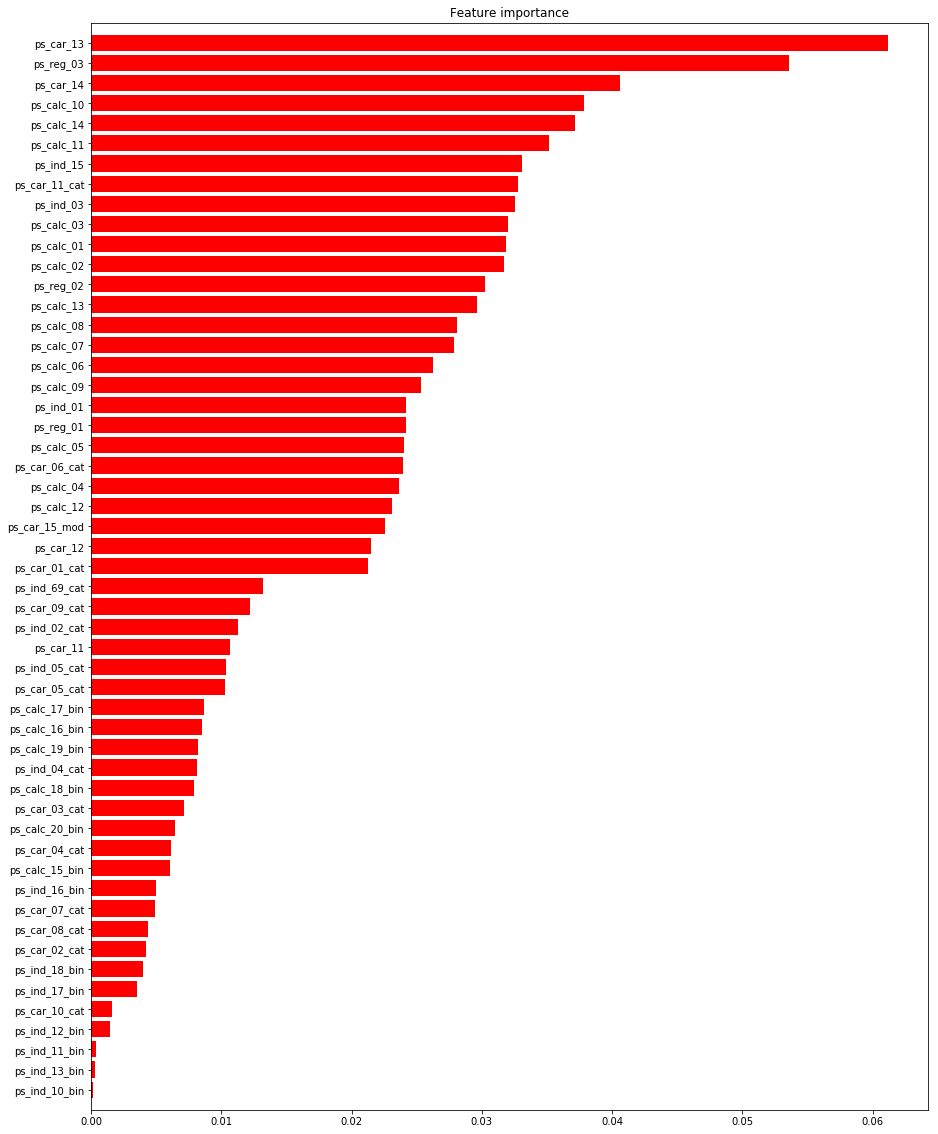

In [25]:
impDict = plotFeatureImportance( rfcModel.feature_importances_, train.drop('target', axis= 1).columns)

In [28]:
def getFeatures(fDict, th = 0.01):
    ls = [k for k, v in fDict.iteritems() if v >th]
    return ls

## Отрежу фичи с низким значением важности и загоню в классификатор

In [36]:
fList = getFeatures(impDict, 0.01)

In [39]:
params = {'depth': 7, 'l2': 5.5, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = trainCatBoost(train.loc[:,fList], train.target, params= params, verbose=True)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.055_5.5_1.5'
Folds 0
Borders for float features generated
0:	learn 0.5462882455	test 0.5383101987	bestTest 0.5383101987		total: 369ms	remaining: 12m 17s
1:	learn 0.5788902893	test 0.5612663579	bestTest 0.5612663579		total: 735ms	remaining: 12m 14s
2:	learn 0.6042923812	test 0.5870960486	bestTest 0.5870960486		total: 1.12s	remaining: 12m 27s
3:	learn 0.604865544	test 0.5896465586	bestTest 0.5896465586		total: 1.52s	remaining: 12m 37s
4:	learn 0.6064799036	test 0.5910371505	bestTest 0.5910371505		total: 1.93s	remaining: 12m 48s
5:	learn 0.6078623289	test 0.5918606344	bestTest 0.5918606344		total: 2.32s	remaining: 12m 50s
6:	learn 0.6065595605	test 0.5897125982	bestTest 0.5918606344		total: 2.73s	remaining: 12m 56s
7:	learn 0.6098229972	test 0.5933086765	bestTest 0.5933086765		total: 3.15s	remaining: 13m 4s
8:	learn 0.6096897092	test 0.593145047	bestTest 0.5933086765		total: 3.55s	remaining: 13m 5s
9:	learn 0.6112208815	test 0.5963548509	be

85:	learn 0.6369681594	test 0.6163343735	bestTest 0.6163343735		total: 35.8s	remaining: 13m 16s
86:	learn 0.6370224057	test 0.616452776	bestTest 0.616452776		total: 36.2s	remaining: 13m 16s
87:	learn 0.6370911082	test 0.6164763142	bestTest 0.6164763142		total: 36.7s	remaining: 13m 16s
88:	learn 0.6373494477	test 0.6166314537	bestTest 0.6166314537		total: 37.1s	remaining: 13m 16s
89:	learn 0.6374362726	test 0.6166150985	bestTest 0.6166314537		total: 37.5s	remaining: 13m 15s
90:	learn 0.6376539188	test 0.6168561892	bestTest 0.6168561892		total: 37.9s	remaining: 13m 15s
91:	learn 0.6378586356	test 0.6169998799	bestTest 0.6169998799		total: 38.4s	remaining: 13m 17s
92:	learn 0.6379873265	test 0.6170318831	bestTest 0.6170318831		total: 38.9s	remaining: 13m 17s
93:	learn 0.6381118366	test 0.6170911597	bestTest 0.6170911597		total: 39.4s	remaining: 13m 18s
94:	learn 0.6381689897	test 0.6170301612	bestTest 0.6170911597		total: 39.8s	remaining: 13m 18s
95:	learn 0.6383688038	test 0.6168992632	b

170:	learn 0.648807022	test 0.6212151788	bestTest 0.6212151788		total: 1m 14s	remaining: 13m 19s
171:	learn 0.6489852342	test 0.6213023014	bestTest 0.6213023014		total: 1m 15s	remaining: 13m 20s
172:	learn 0.6490694505	test 0.62137331	bestTest 0.62137331		total: 1m 15s	remaining: 13m 20s
173:	learn 0.6493023091	test 0.6215519836	bestTest 0.6215519836		total: 1m 16s	remaining: 13m 19s
174:	learn 0.6495132131	test 0.6215233158	bestTest 0.6215519836		total: 1m 16s	remaining: 13m 19s
175:	learn 0.6496034236	test 0.6215717264	bestTest 0.6215717264		total: 1m 17s	remaining: 13m 19s
176:	learn 0.6496972127	test 0.621564895	bestTest 0.6215717264		total: 1m 17s	remaining: 13m 19s
177:	learn 0.6498312138	test 0.6215376216	bestTest 0.6215717264		total: 1m 18s	remaining: 13m 18s
178:	learn 0.6499468355	test 0.6216054837	bestTest 0.6216054837		total: 1m 18s	remaining: 13m 18s
179:	learn 0.650151342	test 0.6216942559	bestTest 0.6216942559		total: 1m 18s	remaining: 13m 18s
180:	learn 0.6501890515	tes

255:	learn 0.6589082209	test 0.6232329097	bestTest 0.6233180894		total: 1m 52s	remaining: 12m 47s
256:	learn 0.6590386227	test 0.6232337898	bestTest 0.6233180894		total: 1m 53s	remaining: 12m 47s
257:	learn 0.6591860569	test 0.6232458151	bestTest 0.6233180894		total: 1m 53s	remaining: 12m 46s
258:	learn 0.6593109593	test 0.6232079369	bestTest 0.6233180894		total: 1m 53s	remaining: 12m 46s
259:	learn 0.6594032954	test 0.6231830042	bestTest 0.6233180894		total: 1m 54s	remaining: 12m 45s
260:	learn 0.6595091912	test 0.6232530805	bestTest 0.6233180894		total: 1m 54s	remaining: 12m 44s
261:	learn 0.6595485711	test 0.6232718729	bestTest 0.6233180894		total: 1m 55s	remaining: 12m 44s
262:	learn 0.6596000642	test 0.6233567934	bestTest 0.6233567934		total: 1m 55s	remaining: 12m 43s
263:	learn 0.6596922735	test 0.6233917582	bestTest 0.6233917582		total: 1m 55s	remaining: 12m 42s
264:	learn 0.6597832053	test 0.6234289653	bestTest 0.6234289653		total: 1m 56s	remaining: 12m 42s
265:	learn 0.6599422

339:	learn 0.6676853604	test 0.6235167329	bestTest 0.6235579183		total: 2m 31s	remaining: 12m 19s
340:	learn 0.6677308891	test 0.6235084709	bestTest 0.6235579183		total: 2m 31s	remaining: 12m 19s
341:	learn 0.6678561269	test 0.6234770183	bestTest 0.6235579183		total: 2m 32s	remaining: 12m 19s
342:	learn 0.6679451666	test 0.6234787402	bestTest 0.6235579183		total: 2m 32s	remaining: 12m 19s
343:	learn 0.6681391083	test 0.623540878	bestTest 0.6235579183		total: 2m 33s	remaining: 12m 18s
344:	learn 0.6681997362	test 0.6235684146	bestTest 0.6235684146		total: 2m 33s	remaining: 12m 18s
345:	learn 0.6683001444	test 0.6235780368	bestTest 0.6235780368		total: 2m 34s	remaining: 12m 18s
346:	learn 0.6684284617	test 0.6235205605	bestTest 0.6235780368		total: 2m 34s	remaining: 12m 18s
347:	learn 0.6686982617	test 0.6235972793	bestTest 0.6235972793		total: 2m 35s	remaining: 12m 17s
348:	learn 0.6687969923	test 0.6236269638	bestTest 0.6236269638		total: 2m 35s	remaining: 12m 17s
349:	learn 0.66894256

424:	learn 0.6753388571	test 0.6232919231	bestTest 0.6236615971		total: 3m 12s	remaining: 11m 54s
425:	learn 0.6754631695	test 0.6232724395	bestTest 0.6236615971		total: 3m 13s	remaining: 11m 54s
426:	learn 0.6755514048	test 0.6233247099	bestTest 0.6236615971		total: 3m 13s	remaining: 11m 54s
427:	learn 0.6756928969	test 0.6233171109	bestTest 0.6236615971		total: 3m 14s	remaining: 11m 54s
428:	learn 0.6757842956	test 0.6232687344	bestTest 0.6236615971		total: 3m 14s	remaining: 11m 53s
429:	learn 0.6759151467	test 0.6232445211	bestTest 0.6236615971		total: 3m 15s	remaining: 11m 53s
430:	learn 0.676025934	test 0.6232317162	bestTest 0.6236615971		total: 3m 15s	remaining: 11m 52s
431:	learn 0.6761039639	test 0.6232258633	bestTest 0.6236615971		total: 3m 16s	remaining: 11m 52s
432:	learn 0.6761877414	test 0.6232310753	bestTest 0.6236615971		total: 3m 16s	remaining: 11m 51s
433:	learn 0.6763062959	test 0.6232763374	bestTest 0.6236615971		total: 3m 17s	remaining: 11m 51s
434:	learn 0.67642665

56:	learn 0.6264790885	test 0.6213521025	bestTest 0.6213521025		total: 28.1s	remaining: 15m 56s
57:	learn 0.6267149935	test 0.6217379428	bestTest 0.6217379428		total: 28.6s	remaining: 15m 58s
58:	learn 0.6269304797	test 0.6218192849	bestTest 0.6218192849		total: 29.1s	remaining: 15m 57s
59:	learn 0.6273388674	test 0.6222310665	bestTest 0.6222310665		total: 29.6s	remaining: 15m 56s
60:	learn 0.6274504362	test 0.6224739254	bestTest 0.6224739254		total: 30s	remaining: 15m 55s
61:	learn 0.6277300436	test 0.6228008769	bestTest 0.6228008769		total: 30.6s	remaining: 15m 54s
62:	learn 0.6280512453	test 0.6230616943	bestTest 0.6230616943		total: 31s	remaining: 15m 54s
63:	learn 0.6286058497	test 0.6234877396	bestTest 0.6234877396		total: 31.5s	remaining: 15m 51s
64:	learn 0.629246874	test 0.6241376785	bestTest 0.6241376785		total: 31.9s	remaining: 15m 50s
65:	learn 0.6296075509	test 0.6243349637	bestTest 0.6243349637		total: 32.4s	remaining: 15m 49s
66:	learn 0.6298185716	test 0.6244543547	best

142:	learn 0.6437573471	test 0.6309179488	bestTest 0.6309715292		total: 1m 5s	remaining: 14m 13s
143:	learn 0.6438454368	test 0.6309053529	bestTest 0.6309715292		total: 1m 6s	remaining: 14m 12s
144:	learn 0.6439356606	test 0.63088907	bestTest 0.6309715292		total: 1m 6s	remaining: 14m 12s
145:	learn 0.6439579645	test 0.6308931166	bestTest 0.6309715292		total: 1m 7s	remaining: 14m 11s
146:	learn 0.6440429338	test 0.6308832814	bestTest 0.6309715292		total: 1m 7s	remaining: 14m 11s
147:	learn 0.6442607067	test 0.6309663373	bestTest 0.6309715292		total: 1m 7s	remaining: 14m 10s
148:	learn 0.6443277392	test 0.6310004181	bestTest 0.6310004181		total: 1m 8s	remaining: 14m 10s
149:	learn 0.6444901709	test 0.631028242	bestTest 0.631028242		total: 1m 8s	remaining: 14m 10s
150:	learn 0.6446921022	test 0.631068037	bestTest 0.631068037		total: 1m 9s	remaining: 14m 9s
151:	learn 0.6450461745	test 0.6312649385	bestTest 0.6312649385		total: 1m 9s	remaining: 14m 9s
152:	learn 0.6453262141	test 0.6314359

226:	learn 0.6548759143	test 0.632544971	bestTest 0.6325490477		total: 1m 42s	remaining: 13m 18s
227:	learn 0.6550870275	test 0.6325163493	bestTest 0.6325490477		total: 1m 42s	remaining: 13m 18s
228:	learn 0.6552709203	test 0.6325591703	bestTest 0.6325591703		total: 1m 43s	remaining: 13m 17s
229:	learn 0.6554778431	test 0.6325741311	bestTest 0.6325741311		total: 1m 43s	remaining: 13m 16s
230:	learn 0.6555388775	test 0.632600217	bestTest 0.632600217		total: 1m 43s	remaining: 13m 16s
231:	learn 0.6557547288	test 0.6326245228	bestTest 0.6326245228		total: 1m 44s	remaining: 13m 15s
232:	learn 0.6558798528	test 0.6326709604	bestTest 0.6326709604		total: 1m 44s	remaining: 13m 15s
233:	learn 0.6559951948	test 0.6326655937	bestTest 0.6326709604		total: 1m 45s	remaining: 13m 14s
234:	learn 0.6560773803	test 0.6327834557	bestTest 0.6327834557		total: 1m 45s	remaining: 13m 14s
235:	learn 0.6561244839	test 0.6328033271	bestTest 0.6328033271		total: 1m 46s	remaining: 13m 13s
236:	learn 0.65618184	t

311:	learn 0.6645333993	test 0.6333625588	bestTest 0.6334935311		total: 2m 18s	remaining: 12m 27s
312:	learn 0.6646146413	test 0.6333676824	bestTest 0.6334935311		total: 2m 18s	remaining: 12m 27s
313:	learn 0.664648978	test 0.6333605114	bestTest 0.6334935311		total: 2m 19s	remaining: 12m 26s
314:	learn 0.6647018765	test 0.6333800754	bestTest 0.6334935311		total: 2m 19s	remaining: 12m 26s
315:	learn 0.664806948	test 0.6333598222	bestTest 0.6334935311		total: 2m 19s	remaining: 12m 25s
316:	learn 0.6649452613	test 0.6333938286	bestTest 0.6334935311		total: 2m 20s	remaining: 12m 24s
317:	learn 0.6650302059	test 0.6334622513	bestTest 0.6334935311		total: 2m 20s	remaining: 12m 24s
318:	learn 0.6652474456	test 0.6335134246	bestTest 0.6335134246		total: 2m 21s	remaining: 12m 23s
319:	learn 0.6653363025	test 0.6334603244	bestTest 0.6335134246		total: 2m 21s	remaining: 12m 23s
320:	learn 0.6654720001	test 0.6334436156	bestTest 0.6335134246		total: 2m 22s	remaining: 12m 22s
321:	learn 0.665534726

396:	learn 0.6725759813	test 0.6334922874	bestTest 0.6335775937		total: 2m 54s	remaining: 11m 42s
397:	learn 0.6726470609	test 0.6334887873	bestTest 0.6335775937		total: 2m 54s	remaining: 11m 42s
398:	learn 0.6728741849	test 0.633476119	bestTest 0.6335775937		total: 2m 54s	remaining: 11m 41s
399:	learn 0.6729395421	test 0.6334183333	bestTest 0.6335775937		total: 2m 55s	remaining: 11m 41s
400:	learn 0.6729890669	test 0.633419354	bestTest 0.6335775937		total: 2m 55s	remaining: 11m 40s
401:	learn 0.6730945592	test 0.6334540375	bestTest 0.6335775937		total: 2m 56s	remaining: 11m 40s
402:	learn 0.673168322	test 0.6334758719	bestTest 0.6335775937		total: 2m 56s	remaining: 11m 39s
403:	learn 0.6732995348	test 0.6334854982	bestTest 0.6335775937		total: 2m 57s	remaining: 11m 39s
404:	learn 0.6734187424	test 0.6334969348	bestTest 0.6335775937		total: 2m 57s	remaining: 11m 38s
405:	learn 0.6734957184	test 0.6334806438	bestTest 0.6335775937		total: 2m 57s	remaining: 11m 38s
406:	learn 0.6735654749

481:	learn 0.6801692679	test 0.6337123152	bestTest 0.6337123152		total: 3m 30s	remaining: 11m 3s
482:	learn 0.6801836041	test 0.6336982144	bestTest 0.6337123152		total: 3m 31s	remaining: 11m 3s
483:	learn 0.6803313449	test 0.6335951785	bestTest 0.6337123152		total: 3m 31s	remaining: 11m 2s
484:	learn 0.6804800489	test 0.6335547486	bestTest 0.6337123152		total: 3m 32s	remaining: 11m 2s
485:	learn 0.6805379412	test 0.6335537239	bestTest 0.6337123152		total: 3m 32s	remaining: 11m 1s
486:	learn 0.6806375199	test 0.6335376098	bestTest 0.6337123152		total: 3m 32s	remaining: 11m 1s
487:	learn 0.6807361185	test 0.6334981423	bestTest 0.6337123152		total: 3m 33s	remaining: 11m
488:	learn 0.680850623	test 0.6335123054	bestTest 0.6337123152		total: 3m 33s	remaining: 11m
489:	learn 0.680954158	test 0.633474807	bestTest 0.6337123152		total: 3m 34s	remaining: 10m 59s
490:	learn 0.6810244682	test 0.6334692153	bestTest 0.6337123152		total: 3m 34s	remaining: 10m 59s
491:	learn 0.6811669424	test 0.633464

566:	learn 0.6878258156	test 0.6331040319	bestTest 0.6337123152		total: 4m 10s	remaining: 10m 34s
567:	learn 0.6878695465	test 0.633096216	bestTest 0.6337123152		total: 4m 11s	remaining: 10m 33s
568:	learn 0.6879375333	test 0.6331016811	bestTest 0.6337123152		total: 4m 11s	remaining: 10m 33s
569:	learn 0.6879769386	test 0.633101004	bestTest 0.6337123152		total: 4m 12s	remaining: 10m 32s
570:	learn 0.6880402597	test 0.6330889948	bestTest 0.6337123152		total: 4m 12s	remaining: 10m 32s
571:	learn 0.6881196281	test 0.6330930534	bestTest 0.6337123152		total: 4m 13s	remaining: 10m 31s
572:	learn 0.6881561895	test 0.6330544137	bestTest 0.6337123152		total: 4m 13s	remaining: 10m 31s
573:	learn 0.6881607892	test 0.6330834473	bestTest 0.6337123152		total: 4m 13s	remaining: 10m 30s
574:	learn 0.6883146291	test 0.6330991595	bestTest 0.6337123152		total: 4m 14s	remaining: 10m 30s
575:	learn 0.6883640954	test 0.6330669514	bestTest 0.6337123152		total: 4m 14s	remaining: 10m 30s
576:	learn 0.688415270

67:	learn 0.6319767488	test 0.6270339636	bestTest 0.6270339636		total: 31.2s	remaining: 14m 47s
68:	learn 0.6320507048	test 0.6270226073	bestTest 0.6270339636		total: 31.7s	remaining: 14m 47s
69:	learn 0.632427948	test 0.627219764	bestTest 0.627219764		total: 32.2s	remaining: 14m 47s
70:	learn 0.6325258895	test 0.6272566456	bestTest 0.6272566456		total: 32.7s	remaining: 14m 47s
71:	learn 0.6326868434	test 0.6272944233	bestTest 0.6272944233		total: 33.1s	remaining: 14m 47s
72:	learn 0.6331309522	test 0.6275277744	bestTest 0.6275277744		total: 33.6s	remaining: 14m 46s
73:	learn 0.6331214965	test 0.6275800127	bestTest 0.6275800127		total: 34.1s	remaining: 14m 46s
74:	learn 0.6334149276	test 0.6277160945	bestTest 0.6277160945		total: 34.5s	remaining: 14m 46s
75:	learn 0.6335822493	test 0.6278068538	bestTest 0.6278068538		total: 35s	remaining: 14m 47s
76:	learn 0.6338960821	test 0.6280378803	bestTest 0.6280378803		total: 35.5s	remaining: 14m 47s
77:	learn 0.6341610837	test 0.6282147074	best

153:	learn 0.6451093194	test 0.6322740129	bestTest 0.6322740129		total: 1m 15s	remaining: 15m 10s
154:	learn 0.6452090637	test 0.6323054113	bestTest 0.6323054113		total: 1m 16s	remaining: 15m 10s
155:	learn 0.6453309923	test 0.6323099522	bestTest 0.6323099522		total: 1m 17s	remaining: 15m 11s
156:	learn 0.6455617614	test 0.63231601	bestTest 0.63231601		total: 1m 17s	remaining: 15m 10s
157:	learn 0.6457774391	test 0.6323231187	bestTest 0.6323231187		total: 1m 18s	remaining: 15m 10s
158:	learn 0.6459126787	test 0.6322952606	bestTest 0.6323231187		total: 1m 18s	remaining: 15m 10s
159:	learn 0.646099009	test 0.6323014471	bestTest 0.6323231187		total: 1m 19s	remaining: 15m 10s
160:	learn 0.6462845711	test 0.6323410432	bestTest 0.6323410432		total: 1m 19s	remaining: 15m 9s
161:	learn 0.6464285489	test 0.6324076495	bestTest 0.6324076495		total: 1m 20s	remaining: 15m 9s
162:	learn 0.6465779262	test 0.632451915	bestTest 0.632451915		total: 1m 20s	remaining: 15m 8s
163:	learn 0.64660989	test 0.6

238:	learn 0.6554309652	test 0.6335179313	bestTest 0.6335179313		total: 1m 58s	remaining: 14m 34s
239:	learn 0.6555451055	test 0.6335612224	bestTest 0.6335612224		total: 1m 59s	remaining: 14m 33s
240:	learn 0.6555934134	test 0.6335377384	bestTest 0.6335612224		total: 1m 59s	remaining: 14m 33s
241:	learn 0.6557190499	test 0.633551361	bestTest 0.6335612224		total: 2m	remaining: 14m 32s
242:	learn 0.6558820346	test 0.6335758758	bestTest 0.6335758758		total: 2m	remaining: 14m 32s
243:	learn 0.6559619118	test 0.6335610737	bestTest 0.6335758758		total: 2m 1s	remaining: 14m 32s
244:	learn 0.6560235356	test 0.6335624782	bestTest 0.6335758758		total: 2m 1s	remaining: 14m 31s
245:	learn 0.656132862	test 0.6335902559	bestTest 0.6335902559		total: 2m 2s	remaining: 14m 31s
246:	learn 0.6563245425	test 0.6336165428	bestTest 0.6336165428		total: 2m 2s	remaining: 14m 30s
247:	learn 0.6563889618	test 0.6336442341	bestTest 0.6336442341		total: 2m 3s	remaining: 14m 30s
248:	learn 0.6564870919	test 0.6336

323:	learn 0.664039664	test 0.634509242	bestTest 0.634691452		total: 2m 40s	remaining: 13m 48s
324:	learn 0.6640519731	test 0.6345230937	bestTest 0.634691452		total: 2m 40s	remaining: 13m 48s
325:	learn 0.6640898148	test 0.6345145585	bestTest 0.634691452		total: 2m 41s	remaining: 13m 48s
326:	learn 0.6641851826	test 0.6345207871	bestTest 0.634691452		total: 2m 41s	remaining: 13m 47s
327:	learn 0.6643268516	test 0.6344397766	bestTest 0.634691452		total: 2m 42s	remaining: 13m 46s
328:	learn 0.6644052575	test 0.6343953021	bestTest 0.634691452		total: 2m 42s	remaining: 13m 46s
329:	learn 0.6644734551	test 0.6344423263	bestTest 0.634691452		total: 2m 43s	remaining: 13m 45s
330:	learn 0.6645365248	test 0.6344955792	bestTest 0.634691452		total: 2m 43s	remaining: 13m 44s
331:	learn 0.664677566	test 0.6344994631	bestTest 0.634691452		total: 2m 44s	remaining: 13m 44s
332:	learn 0.664720365	test 0.6344608776	bestTest 0.634691452		total: 2m 44s	remaining: 13m 43s
333:	learn 0.6647899467	test 0.634

408:	learn 0.6722238898	test 0.6350773385	bestTest 0.6350773385		total: 3m 20s	remaining: 12m 59s
409:	learn 0.6723221857	test 0.6350970492	bestTest 0.6350970492		total: 3m 20s	remaining: 12m 58s
410:	learn 0.6723966026	test 0.6350885682	bestTest 0.6350970492		total: 3m 21s	remaining: 12m 57s
411:	learn 0.6725275242	test 0.6350766032	bestTest 0.6350970492		total: 3m 21s	remaining: 12m 57s
412:	learn 0.6725581328	test 0.6350949676	bestTest 0.6350970492		total: 3m 22s	remaining: 12m 56s
413:	learn 0.672607476	test 0.6350739068	bestTest 0.6350970492		total: 3m 22s	remaining: 12m 55s
414:	learn 0.6726776933	test 0.6350891328	bestTest 0.6350970492		total: 3m 22s	remaining: 12m 55s
415:	learn 0.6727323331	test 0.6350731734	bestTest 0.6350970492		total: 3m 23s	remaining: 12m 54s
416:	learn 0.6728711001	test 0.6350711199	bestTest 0.6350970492		total: 3m 23s	remaining: 12m 54s
417:	learn 0.6729493193	test 0.6350571658	bestTest 0.6350970492		total: 3m 24s	remaining: 12m 53s
418:	learn 0.67308514

492:	learn 0.6795518476	test 0.6351842924	bestTest 0.635230535		total: 3m 55s	remaining: 11m 58s
493:	learn 0.6796698444	test 0.6351636113	bestTest 0.635230535		total: 3m 55s	remaining: 11m 58s
494:	learn 0.6797482933	test 0.6351884837	bestTest 0.635230535		total: 3m 56s	remaining: 11m 57s
495:	learn 0.6798849413	test 0.6352232797	bestTest 0.635230535		total: 3m 56s	remaining: 11m 56s
496:	learn 0.679987965	test 0.6352121023	bestTest 0.635230535		total: 3m 56s	remaining: 11m 56s
497:	learn 0.6800660826	test 0.6351959399	bestTest 0.635230535		total: 3m 57s	remaining: 11m 55s
498:	learn 0.6801133607	test 0.6351856205	bestTest 0.635230535		total: 3m 57s	remaining: 11m 54s
499:	learn 0.6801464418	test 0.6352108405	bestTest 0.635230535		total: 3m 58s	remaining: 11m 54s
500:	learn 0.6801836241	test 0.6352087629	bestTest 0.635230535		total: 3m 58s	remaining: 11m 53s
501:	learn 0.680265078	test 0.6351685882	bestTest 0.635230535		total: 3m 58s	remaining: 11m 52s
502:	learn 0.6803728961	test 0.6

577:	learn 0.6869577637	test 0.6355760299	bestTest 0.6357079626		total: 4m 31s	remaining: 11m 6s
578:	learn 0.6870273551	test 0.6356330722	bestTest 0.6357079626		total: 4m 31s	remaining: 11m 6s
579:	learn 0.6870448665	test 0.6356339783	bestTest 0.6357079626		total: 4m 31s	remaining: 11m 5s
580:	learn 0.6871432634	test 0.6356697689	bestTest 0.6357079626		total: 4m 32s	remaining: 11m 4s
581:	learn 0.6872626251	test 0.6356591461	bestTest 0.6357079626		total: 4m 32s	remaining: 11m 4s
582:	learn 0.6873191008	test 0.6356733032	bestTest 0.6357079626		total: 4m 33s	remaining: 11m 3s
583:	learn 0.6874122169	test 0.6357117661	bestTest 0.6357117661		total: 4m 33s	remaining: 11m 3s
584:	learn 0.6875028426	test 0.6356620193	bestTest 0.6357117661		total: 4m 33s	remaining: 11m 2s
585:	learn 0.6875236751	test 0.6356476432	bestTest 0.6357117661		total: 4m 34s	remaining: 11m 1s
586:	learn 0.6877232391	test 0.6356760157	bestTest 0.6357117661		total: 4m 34s	remaining: 11m 1s
587:	learn 0.687759327	test 0.

662:	learn 0.6937671194	test 0.6352010253	bestTest 0.6357610788		total: 5m 7s	remaining: 10m 19s
663:	learn 0.6938333724	test 0.6352148308	bestTest 0.6357610788		total: 5m 7s	remaining: 10m 19s
664:	learn 0.6939321025	test 0.63520509	bestTest 0.6357610788		total: 5m 8s	remaining: 10m 18s
665:	learn 0.6939814213	test 0.635237264	bestTest 0.6357610788		total: 5m 8s	remaining: 10m 18s
666:	learn 0.6939996467	test 0.6352371414	bestTest 0.6357610788		total: 5m 9s	remaining: 10m 17s
667:	learn 0.6940902791	test 0.6352750256	bestTest 0.6357610788		total: 5m 9s	remaining: 10m 17s
668:	learn 0.6941275264	test 0.6352842882	bestTest 0.6357610788		total: 5m 9s	remaining: 10m 16s
669:	learn 0.6941859766	test 0.6352699744	bestTest 0.6357610788		total: 5m 10s	remaining: 10m 16s
670:	learn 0.6942474519	test 0.6352780013	bestTest 0.6357610788		total: 5m 10s	remaining: 10m 15s
671:	learn 0.6943280813	test 0.6352933499	bestTest 0.6357610788		total: 5m 11s	remaining: 10m 15s
672:	learn 0.6943876947	test 0

41:	learn 0.6263501784	test 0.6205378892	bestTest 0.6205378892		total: 19.2s	remaining: 14m 55s
42:	learn 0.6261987652	test 0.6204434199	bestTest 0.6205378892		total: 19.8s	remaining: 14m 59s
43:	learn 0.6260415793	test 0.6203254544	bestTest 0.6205378892		total: 20.3s	remaining: 15m 2s
44:	learn 0.6261505978	test 0.6204289914	bestTest 0.6205378892		total: 20.8s	remaining: 15m 4s
45:	learn 0.6264089754	test 0.6206873197	bestTest 0.6206873197		total: 21.3s	remaining: 15m 5s
46:	learn 0.6263335811	test 0.6208946027	bestTest 0.6208946027		total: 21.8s	remaining: 15m 5s
47:	learn 0.626878632	test 0.6214603171	bestTest 0.6214603171		total: 22.3s	remaining: 15m 6s
48:	learn 0.6267752771	test 0.6216429868	bestTest 0.6216429868		total: 22.7s	remaining: 15m 5s
49:	learn 0.6267152473	test 0.6216429506	bestTest 0.6216429868		total: 23.2s	remaining: 15m 5s
50:	learn 0.6267656044	test 0.6215785961	bestTest 0.6216429868		total: 23.7s	remaining: 15m 5s
51:	learn 0.6269238871	test 0.6215405488	bestTest

128:	learn 0.643044999	test 0.6313700449	bestTest 0.6313700449		total: 1m 2s	remaining: 15m 1s
129:	learn 0.64314313	test 0.631357059	bestTest 0.6313700449		total: 1m 2s	remaining: 15m 3s
130:	learn 0.643170843	test 0.6314023839	bestTest 0.6314023839		total: 1m 3s	remaining: 15m 3s
131:	learn 0.6432804696	test 0.6314570879	bestTest 0.6314570879		total: 1m 3s	remaining: 15m 2s
132:	learn 0.643635592	test 0.6315760219	bestTest 0.6315760219		total: 1m 4s	remaining: 15m 2s
133:	learn 0.6437596741	test 0.6317135274	bestTest 0.6317135274		total: 1m 4s	remaining: 15m 1s
134:	learn 0.6438498122	test 0.6317215825	bestTest 0.6317215825		total: 1m 5s	remaining: 15m
135:	learn 0.6439885926	test 0.6317795054	bestTest 0.6317795054		total: 1m 5s	remaining: 14m 59s
136:	learn 0.6440782825	test 0.6317907492	bestTest 0.6317907492		total: 1m 6s	remaining: 14m 59s
137:	learn 0.6441821281	test 0.6318875271	bestTest 0.6318875271		total: 1m 6s	remaining: 14m 58s
138:	learn 0.6443555065	test 0.6319443067	best

212:	learn 0.6534053548	test 0.6333736261	bestTest 0.6333736261		total: 1m 43s	remaining: 14m 27s
213:	learn 0.6534770601	test 0.6333386972	bestTest 0.6333736261		total: 1m 43s	remaining: 14m 27s
214:	learn 0.6536263945	test 0.6333863869	bestTest 0.6333863869		total: 1m 44s	remaining: 14m 26s
215:	learn 0.6537078866	test 0.6334105321	bestTest 0.6334105321		total: 1m 44s	remaining: 14m 26s
216:	learn 0.6538757736	test 0.6334540346	bestTest 0.6334540346		total: 1m 45s	remaining: 14m 26s
217:	learn 0.6539702359	test 0.6334814388	bestTest 0.6334814388		total: 1m 45s	remaining: 14m 25s
218:	learn 0.6540336984	test 0.6334956985	bestTest 0.6334956985		total: 1m 46s	remaining: 14m 25s
219:	learn 0.6540919397	test 0.633444571	bestTest 0.6334956985		total: 1m 46s	remaining: 14m 24s
220:	learn 0.654199966	test 0.6334521901	bestTest 0.6334956985		total: 1m 47s	remaining: 14m 23s
221:	learn 0.6543468665	test 0.633454344	bestTest 0.6334956985		total: 1m 47s	remaining: 14m 23s
222:	learn 0.6544380152

297:	learn 0.6625522119	test 0.633946156	bestTest 0.6339501042		total: 2m 24s	remaining: 13m 42s
298:	learn 0.6626637587	test 0.6339635903	bestTest 0.6339635903		total: 2m 24s	remaining: 13m 42s
299:	learn 0.6627643879	test 0.6339440101	bestTest 0.6339635903		total: 2m 24s	remaining: 13m 41s
300:	learn 0.6628028729	test 0.6339423786	bestTest 0.6339635903		total: 2m 25s	remaining: 13m 40s
301:	learn 0.6628803822	test 0.6339792203	bestTest 0.6339792203		total: 2m 25s	remaining: 13m 40s
302:	learn 0.6630041221	test 0.6339676028	bestTest 0.6339792203		total: 2m 26s	remaining: 13m 40s
303:	learn 0.6632416363	test 0.6339503031	bestTest 0.6339792203		total: 2m 26s	remaining: 13m 39s
304:	learn 0.6633298078	test 0.63396222	bestTest 0.6339792203		total: 2m 27s	remaining: 13m 38s
305:	learn 0.6634412631	test 0.6340065804	bestTest 0.6340065804		total: 2m 27s	remaining: 13m 38s
306:	learn 0.6634899004	test 0.6340082059	bestTest 0.6340082059		total: 2m 28s	remaining: 13m 37s
307:	learn 0.6634988	te

382:	learn 0.6710303548	test 0.6347988888	bestTest 0.6348822951		total: 3m 4s	remaining: 12m 59s
383:	learn 0.6711247163	test 0.6348118566	bestTest 0.6348822951		total: 3m 5s	remaining: 12m 58s
384:	learn 0.6711809524	test 0.6348017138	bestTest 0.6348822951		total: 3m 5s	remaining: 12m 58s
385:	learn 0.6712629559	test 0.6348041511	bestTest 0.6348822951		total: 3m 6s	remaining: 12m 57s
386:	learn 0.6713237223	test 0.6348376916	bestTest 0.6348822951		total: 3m 6s	remaining: 12m 57s
387:	learn 0.6713590402	test 0.634831698	bestTest 0.6348822951		total: 3m 6s	remaining: 12m 56s
388:	learn 0.6714709617	test 0.6348456442	bestTest 0.6348822951		total: 3m 7s	remaining: 12m 56s
389:	learn 0.6716075815	test 0.6348621041	bestTest 0.6348822951		total: 3m 7s	remaining: 12m 55s
390:	learn 0.6717236309	test 0.6348638099	bestTest 0.6348822951		total: 3m 8s	remaining: 12m 55s
391:	learn 0.6718612904	test 0.634867728	bestTest 0.6348822951		total: 3m 8s	remaining: 12m 54s
392:	learn 0.6718903513	test 0.6

466:	learn 0.6783482252	test 0.6345937577	bestTest 0.6349833286		total: 3m 44s	remaining: 12m 17s
467:	learn 0.6783790758	test 0.634587314	bestTest 0.6349833286		total: 3m 45s	remaining: 12m 17s
468:	learn 0.6784475889	test 0.6345574786	bestTest 0.6349833286		total: 3m 45s	remaining: 12m 16s
469:	learn 0.6785792974	test 0.6345205343	bestTest 0.6349833286		total: 3m 46s	remaining: 12m 16s
470:	learn 0.6786669932	test 0.6345198753	bestTest 0.6349833286		total: 3m 46s	remaining: 12m 15s
471:	learn 0.6787908566	test 0.6345500202	bestTest 0.6349833286		total: 3m 47s	remaining: 12m 15s
472:	learn 0.6788326426	test 0.6346050457	bestTest 0.6349833286		total: 3m 47s	remaining: 12m 15s
473:	learn 0.678891258	test 0.6346002536	bestTest 0.6349833286		total: 3m 48s	remaining: 12m 14s
474:	learn 0.678968509	test 0.6345748847	bestTest 0.6349833286		total: 3m 48s	remaining: 12m 14s
475:	learn 0.6791930081	test 0.6346197615	bestTest 0.6349833286		total: 3m 49s	remaining: 12m 13s
476:	learn 0.6792429098

48:	learn 0.6252204591	test 0.6225763277	bestTest 0.6227406184		total: 23.2s	remaining: 15m 24s
49:	learn 0.6253934014	test 0.622779621	bestTest 0.622779621		total: 23.7s	remaining: 15m 23s
50:	learn 0.6257568419	test 0.6230809465	bestTest 0.6230809465		total: 24.1s	remaining: 15m 22s
51:	learn 0.625933046	test 0.6233052534	bestTest 0.6233052534		total: 24.6s	remaining: 15m 21s
52:	learn 0.6259733375	test 0.6234704404	bestTest 0.6234704404		total: 25.1s	remaining: 15m 20s
53:	learn 0.6265766888	test 0.6241739471	bestTest 0.6241739471		total: 25.5s	remaining: 15m 20s
54:	learn 0.6267436746	test 0.6243946345	bestTest 0.6243946345		total: 26s	remaining: 15m 18s
55:	learn 0.6276269379	test 0.6251795972	bestTest 0.6251795972		total: 26.5s	remaining: 15m 18s
56:	learn 0.6284386509	test 0.6258268799	bestTest 0.6258268799		total: 26.9s	remaining: 15m 17s
57:	learn 0.6288321756	test 0.6261198027	bestTest 0.6261198027		total: 27.4s	remaining: 15m 16s
58:	learn 0.6288555432	test 0.6262487444	best

134:	learn 0.6437976761	test 0.6345992197	bestTest 0.6346095919		total: 1m 1s	remaining: 14m 11s
135:	learn 0.6438906729	test 0.6345942798	bestTest 0.6346095919		total: 1m 2s	remaining: 14m 10s
136:	learn 0.6441340323	test 0.6347359913	bestTest 0.6347359913		total: 1m 2s	remaining: 14m 9s
137:	learn 0.6441826886	test 0.6347058093	bestTest 0.6347359913		total: 1m 2s	remaining: 14m 8s
138:	learn 0.6442406379	test 0.6347056304	bestTest 0.6347359913		total: 1m 3s	remaining: 14m 7s
139:	learn 0.6443143038	test 0.6346423303	bestTest 0.6347359913		total: 1m 3s	remaining: 14m 6s
140:	learn 0.6444582904	test 0.6346921954	bestTest 0.6347359913		total: 1m 4s	remaining: 14m 5s
141:	learn 0.6446095792	test 0.6347323034	bestTest 0.6347359913		total: 1m 4s	remaining: 14m 5s
142:	learn 0.6448091274	test 0.6347295602	bestTest 0.6347359913		total: 1m 5s	remaining: 14m 4s
143:	learn 0.6448408506	test 0.634749999	bestTest 0.634749999		total: 1m 5s	remaining: 14m 3s
144:	learn 0.6450151209	test 0.634871639

219:	learn 0.6544307715	test 0.6360257676	bestTest 0.6360257676		total: 1m 38s	remaining: 13m 16s
220:	learn 0.6546034828	test 0.6360322671	bestTest 0.6360322671		total: 1m 38s	remaining: 13m 15s
221:	learn 0.6547001742	test 0.6359970809	bestTest 0.6360322671		total: 1m 39s	remaining: 13m 14s
222:	learn 0.6547417157	test 0.636032056	bestTest 0.6360322671		total: 1m 39s	remaining: 13m 14s
223:	learn 0.6547737313	test 0.6360661932	bestTest 0.6360661932		total: 1m 40s	remaining: 13m 13s
224:	learn 0.654870691	test 0.6360247366	bestTest 0.6360661932		total: 1m 40s	remaining: 13m 13s
225:	learn 0.6549405602	test 0.6360222365	bestTest 0.6360661932		total: 1m 40s	remaining: 13m 12s
226:	learn 0.6550487531	test 0.636016746	bestTest 0.6360661932		total: 1m 41s	remaining: 13m 11s
227:	learn 0.6551012932	test 0.6359792627	bestTest 0.6360661932		total: 1m 41s	remaining: 13m 11s
228:	learn 0.6551480963	test 0.6360111449	bestTest 0.6360661932		total: 1m 42s	remaining: 13m 10s
229:	learn 0.655324228	

304:	learn 0.6634577997	test 0.636249751	bestTest 0.6362579265		total: 2m 15s	remaining: 12m 32s
305:	learn 0.6635248682	test 0.6362250535	bestTest 0.6362579265		total: 2m 15s	remaining: 12m 32s
306:	learn 0.6636220927	test 0.6362161786	bestTest 0.6362579265		total: 2m 16s	remaining: 12m 31s
307:	learn 0.6637135335	test 0.6361266837	bestTest 0.6362579265		total: 2m 16s	remaining: 12m 31s
308:	learn 0.6638352128	test 0.6360575594	bestTest 0.6362579265		total: 2m 17s	remaining: 12m 31s
309:	learn 0.6639504003	test 0.6359921952	bestTest 0.6362579265		total: 2m 17s	remaining: 12m 30s
310:	learn 0.6640916217	test 0.6359856737	bestTest 0.6362579265		total: 2m 18s	remaining: 12m 29s
311:	learn 0.6642692109	test 0.6359805348	bestTest 0.6362579265		total: 2m 18s	remaining: 12m 29s
312:	learn 0.6644043689	test 0.6360590064	bestTest 0.6362579265		total: 2m 18s	remaining: 12m 28s
313:	learn 0.6644842004	test 0.6360530214	bestTest 0.6362579265		total: 2m 19s	remaining: 12m 28s
314:	learn 0.66462401

388:	learn 0.6715855714	test 0.6359148371	bestTest 0.6362579265		total: 2m 50s	remaining: 11m 46s
389:	learn 0.6716079804	test 0.6359692704	bestTest 0.6362579265		total: 2m 51s	remaining: 11m 46s
390:	learn 0.6716582451	test 0.6359630061	bestTest 0.6362579265		total: 2m 51s	remaining: 11m 45s
391:	learn 0.6717659426	test 0.6359758462	bestTest 0.6362579265		total: 2m 51s	remaining: 11m 45s
392:	learn 0.6718909572	test 0.6359741118	bestTest 0.6362579265		total: 2m 52s	remaining: 11m 44s
393:	learn 0.6719205704	test 0.6359549611	bestTest 0.6362579265		total: 2m 52s	remaining: 11m 44s
394:	learn 0.6720351395	test 0.6359733742	bestTest 0.6362579265		total: 2m 53s	remaining: 11m 43s
395:	learn 0.6721220507	test 0.6359971793	bestTest 0.6362579265		total: 2m 53s	remaining: 11m 43s
396:	learn 0.6721719332	test 0.6359598247	bestTest 0.6362579265		total: 2m 54s	remaining: 11m 42s
397:	learn 0.6722195033	test 0.6359808122	bestTest 0.6362579265		total: 2m 54s	remaining: 11m 42s
398:	learn 0.6722894

In [41]:
2*score-1

0.26571704940437235

In [44]:
fList.append('target')

In [47]:
# сохраняем данные с ограниченным набором фич
train.loc[:,fList].to_pickle("train3.pcl")

По результатам оптимизации, наилучший набор параметров

params = {'depth': 7, 'l2': 1.6, 'rate': 0.04, 'T': 0}

In [63]:
params2 = {'depth': 7, 'l2': 1.6, 'rate': 0.04, 'T': 0}
[score, treeList, scoreList, modelList] = trainCatBoost(train.loc[:,fList].drop("target", axis = 1), train.target, params= params2, verbose= False)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.04_1.6_0'
Folds 0
Local score is 0.624113, tree number is 558
Folds 1
Local score is 0.634336, tree number is 369
Folds 2
Local score is 0.634952, tree number is 649
Folds 3
Local score is 0.635590, tree number is 540
Folds 4
Local score is 0.637322, tree number is 492
ROC-AUC is 0.633232, Gini is 0.266464


In [64]:
params3 = {'depth': 7, 'l2': 2, 'rate': 0.03, 'T': 0}
[score, treeList, scoreList, modelList] = trainCatBoost(train.loc[:,fList].drop("target", axis= 1), train.target, params= params3, verbose= False)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.03_2_0'
Folds 0
Local score is 0.623669, tree number is 542
Folds 1
Local score is 0.634333, tree number is 486
Folds 2
Local score is 0.635623, tree number is 948
Folds 3
Local score is 0.636292, tree number is 870
Folds 4
Local score is 0.637008, tree number is 562
ROC-AUC is 0.633393, Gini is 0.266785


In [65]:
params4 = {'depth': 7, 'l2': 2, 'rate': 0.01, 'T': 0}
[score, treeList, scoreList, modelList] = trainCatBoost(train.loc[:,fList].drop("target", axis = 1), train.target, params= params4, verbose= False)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.01_2_0'
Folds 0
Local score is 0.624421, tree number is 1618
Folds 1
Local score is 0.634813, tree number is 1549
Folds 2
Local score is 0.634942, tree number is 1860
Folds 3
Local score is 0.636372, tree number is 2000
Folds 4
Local score is 0.637824, tree number is 1682
ROC-AUC is 0.633653, Gini is 0.267307


In [57]:
getPredictions(train.loc[:,fList].drop("target", axis= 1), train.target, test.loc[:,fList].drop("target", axis= 1),
               params= params4, n_seed = 5, n_iter = 300, fName = 'submission24.csv')

Borders for float features generated
0:	learn 0.550917541	total: 371ms	remaining: 1m 50s
1:	learn 0.5701978541	total: 1.31s	remaining: 3m 15s
2:	learn 0.5697350027	total: 1.7s	remaining: 2m 48s
3:	learn 0.5864370006	total: 2.14s	remaining: 2m 38s
4:	learn 0.591664867	total: 2.55s	remaining: 2m 30s
5:	learn 0.5931835099	total: 2.99s	remaining: 2m 26s
6:	learn 0.596878769	total: 3.56s	remaining: 2m 28s
7:	learn 0.597129776	total: 3.99s	remaining: 2m 25s
8:	learn 0.5974472363	total: 4.42s	remaining: 2m 23s
9:	learn 0.6003625865	total: 4.86s	remaining: 2m 20s
10:	learn 0.6007248284	total: 5.41s	remaining: 2m 22s
11:	learn 0.6014844293	total: 5.88s	remaining: 2m 21s
12:	learn 0.602421424	total: 6.32s	remaining: 2m 19s
13:	learn 0.6028702545	total: 6.76s	remaining: 2m 18s
14:	learn 0.6059162721	total: 7.21s	remaining: 2m 16s
15:	learn 0.6062536548	total: 7.64s	remaining: 2m 15s
16:	learn 0.6059737388	total: 8.14s	remaining: 2m 15s
17:	learn 0.6070094396	total: 8.63s	remaining: 2m 15s
18:	lea

152:	learn 0.6242068226	total: 1m 9s	remaining: 1m 6s
153:	learn 0.624362103	total: 1m 9s	remaining: 1m 6s
154:	learn 0.6243321061	total: 1m 10s	remaining: 1m 5s
155:	learn 0.6244872684	total: 1m 10s	remaining: 1m 5s
156:	learn 0.6245745918	total: 1m 11s	remaining: 1m 4s
157:	learn 0.6247802136	total: 1m 11s	remaining: 1m 4s
158:	learn 0.6248485299	total: 1m 12s	remaining: 1m 3s
159:	learn 0.6247779769	total: 1m 12s	remaining: 1m 3s
160:	learn 0.624734996	total: 1m 12s	remaining: 1m 2s
161:	learn 0.6248360977	total: 1m 13s	remaining: 1m 2s
162:	learn 0.6247561019	total: 1m 13s	remaining: 1m 1s
163:	learn 0.6249264062	total: 1m 14s	remaining: 1m 1s
164:	learn 0.6249755396	total: 1m 14s	remaining: 1m
165:	learn 0.6250013138	total: 1m 14s	remaining: 1m
166:	learn 0.6251086273	total: 1m 15s	remaining: 1m
167:	learn 0.6251872333	total: 1m 15s	remaining: 59.7s
168:	learn 0.6251179784	total: 1m 16s	remaining: 59.2s
169:	learn 0.6252130804	total: 1m 16s	remaining: 58.8s
170:	learn 0.6252077846

2:	learn 0.5708953134	total: 1.46s	remaining: 2m 24s
3:	learn 0.5793611447	total: 1.96s	remaining: 2m 24s
4:	learn 0.5858700941	total: 2.47s	remaining: 2m 25s
5:	learn 0.5895201359	total: 2.96s	remaining: 2m 25s
6:	learn 0.5922340258	total: 3.43s	remaining: 2m 23s
7:	learn 0.5980823889	total: 3.91s	remaining: 2m 22s
8:	learn 0.5996516802	total: 4.39s	remaining: 2m 22s
9:	learn 0.6029651781	total: 4.89s	remaining: 2m 21s
10:	learn 0.6047166477	total: 5.41s	remaining: 2m 22s
11:	learn 0.6072674761	total: 5.96s	remaining: 2m 22s
12:	learn 0.6098805484	total: 6.47s	remaining: 2m 22s
13:	learn 0.6107890134	total: 7s	remaining: 2m 22s
14:	learn 0.6110717265	total: 7.5s	remaining: 2m 22s
15:	learn 0.6100890827	total: 8s	remaining: 2m 21s
16:	learn 0.6096318966	total: 8.46s	remaining: 2m 20s
17:	learn 0.6103646381	total: 8.98s	remaining: 2m 20s
18:	learn 0.6108421402	total: 9.53s	remaining: 2m 20s
19:	learn 0.6106585882	total: 10s	remaining: 2m 20s
20:	learn 0.6105883563	total: 10.6s	remaining

154:	learn 0.6236403902	total: 1m 13s	remaining: 1m 8s
155:	learn 0.6237729343	total: 1m 14s	remaining: 1m 8s
156:	learn 0.6238582331	total: 1m 14s	remaining: 1m 7s
157:	learn 0.6239252465	total: 1m 15s	remaining: 1m 7s
158:	learn 0.6239847973	total: 1m 15s	remaining: 1m 6s
159:	learn 0.6239739486	total: 1m 15s	remaining: 1m 6s
160:	learn 0.6241454814	total: 1m 16s	remaining: 1m 6s
161:	learn 0.6241513318	total: 1m 16s	remaining: 1m 5s
162:	learn 0.6241507525	total: 1m 17s	remaining: 1m 5s
163:	learn 0.6241299737	total: 1m 17s	remaining: 1m 4s
164:	learn 0.6241035532	total: 1m 18s	remaining: 1m 4s
165:	learn 0.6242031079	total: 1m 18s	remaining: 1m 3s
166:	learn 0.6241932766	total: 1m 19s	remaining: 1m 3s
167:	learn 0.6243356365	total: 1m 19s	remaining: 1m 2s
168:	learn 0.6245134186	total: 1m 19s	remaining: 1m 2s
169:	learn 0.6246352602	total: 1m 20s	remaining: 1m 1s
170:	learn 0.6246528862	total: 1m 20s	remaining: 1m 1s
171:	learn 0.6246945503	total: 1m 21s	remaining: 1m
172:	learn 0.

4:	learn 0.5875236264	total: 1.91s	remaining: 1m 52s
5:	learn 0.5936638708	total: 2.36s	remaining: 1m 55s
6:	learn 0.6006380387	total: 2.79s	remaining: 1m 56s
7:	learn 0.603267158	total: 3.25s	remaining: 1m 58s
8:	learn 0.6033418303	total: 3.67s	remaining: 1m 58s
9:	learn 0.6038478903	total: 4.07s	remaining: 1m 58s
10:	learn 0.6061196031	total: 4.5s	remaining: 1m 58s
11:	learn 0.6052166204	total: 4.93s	remaining: 1m 58s
12:	learn 0.6053696099	total: 5.35s	remaining: 1m 58s
13:	learn 0.60542693	total: 5.79s	remaining: 1m 58s
14:	learn 0.6062282344	total: 6.21s	remaining: 1m 58s
15:	learn 0.6072887574	total: 6.62s	remaining: 1m 57s
16:	learn 0.6077009103	total: 7.05s	remaining: 1m 57s
17:	learn 0.607106199	total: 7.49s	remaining: 1m 57s
18:	learn 0.6086698059	total: 7.92s	remaining: 1m 57s
19:	learn 0.6107554117	total: 8.3s	remaining: 1m 56s
20:	learn 0.6131936583	total: 8.73s	remaining: 1m 56s
21:	learn 0.6162901486	total: 9.17s	remaining: 1m 55s
22:	learn 0.6169933384	total: 9.61s	rema

156:	learn 0.6244488778	total: 1m 7s	remaining: 1m 1s
157:	learn 0.6245594159	total: 1m 8s	remaining: 1m 1s
158:	learn 0.6244929265	total: 1m 8s	remaining: 1m
159:	learn 0.6244968407	total: 1m 9s	remaining: 1m
160:	learn 0.6245038906	total: 1m 9s	remaining: 1m
161:	learn 0.6244182271	total: 1m 9s	remaining: 59.6s
162:	learn 0.6243973219	total: 1m 10s	remaining: 59.1s
163:	learn 0.6244644033	total: 1m 10s	remaining: 58.7s
164:	learn 0.6244033367	total: 1m 11s	remaining: 58.2s
165:	learn 0.6242824316	total: 1m 11s	remaining: 57.8s
166:	learn 0.6243565345	total: 1m 12s	remaining: 57.4s
167:	learn 0.6244442617	total: 1m 12s	remaining: 56.9s
168:	learn 0.6243091368	total: 1m 12s	remaining: 56.5s
169:	learn 0.6243760264	total: 1m 13s	remaining: 56.1s
170:	learn 0.6244269848	total: 1m 13s	remaining: 55.6s
171:	learn 0.6244523673	total: 1m 14s	remaining: 55.2s
172:	learn 0.6244280898	total: 1m 14s	remaining: 54.8s
173:	learn 0.62444866	total: 1m 15s	remaining: 54.3s
174:	learn 0.6244790443	tot

6:	learn 0.5865047835	total: 3.22s	remaining: 2m 14s
7:	learn 0.5980547087	total: 3.7s	remaining: 2m 15s
8:	learn 0.599250311	total: 4.18s	remaining: 2m 15s
9:	learn 0.6013876522	total: 4.67s	remaining: 2m 15s
10:	learn 0.6077964911	total: 5.15s	remaining: 2m 15s
11:	learn 0.6106496879	total: 5.59s	remaining: 2m 14s
12:	learn 0.6119067797	total: 6.02s	remaining: 2m 12s
13:	learn 0.611883878	total: 6.47s	remaining: 2m 12s
14:	learn 0.6137232925	total: 6.94s	remaining: 2m 11s
15:	learn 0.6117776619	total: 7.38s	remaining: 2m 10s
16:	learn 0.6120671909	total: 7.81s	remaining: 2m 10s
17:	learn 0.6134587868	total: 8.23s	remaining: 2m 8s
18:	learn 0.6129157664	total: 8.69s	remaining: 2m 8s
19:	learn 0.6126097179	total: 9.14s	remaining: 2m 8s
20:	learn 0.6124812603	total: 9.66s	remaining: 2m 8s
21:	learn 0.612405838	total: 10.2s	remaining: 2m 8s
22:	learn 0.6117476186	total: 10.7s	remaining: 2m 8s
23:	learn 0.6124170026	total: 11.2s	remaining: 2m 9s
24:	learn 0.6128696524	total: 11.7s	remaini

159:	learn 0.6246445249	total: 1m 10s	remaining: 1m 1s
160:	learn 0.62473049	total: 1m 11s	remaining: 1m 1s
161:	learn 0.6248916671	total: 1m 11s	remaining: 1m
162:	learn 0.624923021	total: 1m 11s	remaining: 1m
163:	learn 0.6248586846	total: 1m 12s	remaining: 1m
164:	learn 0.6248298927	total: 1m 12s	remaining: 59.7s
165:	learn 0.6248680986	total: 1m 13s	remaining: 59.2s
166:	learn 0.6248387739	total: 1m 13s	remaining: 58.7s
167:	learn 0.6248702452	total: 1m 14s	remaining: 58.3s
168:	learn 0.6249040631	total: 1m 14s	remaining: 57.8s
169:	learn 0.6248711241	total: 1m 15s	remaining: 57.4s
170:	learn 0.6247965711	total: 1m 15s	remaining: 57s
171:	learn 0.6248946693	total: 1m 16s	remaining: 56.6s
172:	learn 0.624874334	total: 1m 16s	remaining: 56.1s
173:	learn 0.6249055977	total: 1m 16s	remaining: 55.8s
174:	learn 0.6249275597	total: 1m 17s	remaining: 55.3s
175:	learn 0.6250138955	total: 1m 17s	remaining: 54.9s
176:	learn 0.6250310934	total: 1m 18s	remaining: 54.6s
177:	learn 0.6251152762	t

10:	learn 0.6071722331	total: 4.85s	remaining: 2m 7s
11:	learn 0.6080503873	total: 5.28s	remaining: 2m 6s
12:	learn 0.6098665787	total: 5.73s	remaining: 2m 6s
13:	learn 0.6084153495	total: 6.17s	remaining: 2m 5s
14:	learn 0.6080393492	total: 6.59s	remaining: 2m 5s
15:	learn 0.6084007632	total: 7.02s	remaining: 2m 4s
16:	learn 0.6106647683	total: 7.45s	remaining: 2m 3s
17:	learn 0.6116945246	total: 7.87s	remaining: 2m 3s
18:	learn 0.6116996256	total: 8.29s	remaining: 2m 2s
19:	learn 0.6141850486	total: 8.69s	remaining: 2m 1s
20:	learn 0.6140949942	total: 9.11s	remaining: 2m 1s
21:	learn 0.6155437212	total: 9.53s	remaining: 2m
22:	learn 0.6156592124	total: 9.92s	remaining: 1m 59s
23:	learn 0.6155860238	total: 10.3s	remaining: 1m 58s
24:	learn 0.6161922438	total: 10.7s	remaining: 1m 58s
25:	learn 0.6157733778	total: 11.1s	remaining: 1m 57s
26:	learn 0.6164694807	total: 11.5s	remaining: 1m 56s
27:	learn 0.6172219515	total: 12s	remaining: 1m 56s
28:	learn 0.6182487715	total: 12.4s	remaining

162:	learn 0.6266957008	total: 1m 13s	remaining: 1m 2s
163:	learn 0.6266380797	total: 1m 14s	remaining: 1m 1s
164:	learn 0.6266522252	total: 1m 14s	remaining: 1m 1s
165:	learn 0.6266711255	total: 1m 15s	remaining: 1m
166:	learn 0.6266085725	total: 1m 15s	remaining: 1m
167:	learn 0.6266327005	total: 1m 16s	remaining: 59.9s
168:	learn 0.6266257222	total: 1m 16s	remaining: 59.4s
169:	learn 0.6265296917	total: 1m 17s	remaining: 59s
170:	learn 0.6265229488	total: 1m 17s	remaining: 58.5s
171:	learn 0.626594302	total: 1m 17s	remaining: 58s
172:	learn 0.6268728397	total: 1m 18s	remaining: 57.6s
173:	learn 0.6268327483	total: 1m 18s	remaining: 57.2s
174:	learn 0.6268964544	total: 1m 19s	remaining: 56.7s
175:	learn 0.626895364	total: 1m 19s	remaining: 56.2s
176:	learn 0.6268874195	total: 1m 20s	remaining: 55.8s
177:	learn 0.6267785191	total: 1m 20s	remaining: 55.3s
178:	learn 0.6267071988	total: 1m 21s	remaining: 54.8s
179:	learn 0.6266839266	total: 1m 21s	remaining: 54.4s
180:	learn 0.626727617

,target
id,
0,0.033539
1,0.037985
2,0.040373
3,0.028238
4,0.045285
5,0.036440
6,0.030389
8,0.043411
10,0.052511


Скор 0,242 . Модель явно переобучается. Попробую другой набор параметров.

In [59]:
params5 = {'depth': 5, 'l2': 10, 'rate': 0.0975, 'T': 0} 
[score, treeList, scoreList, modelList] = trainCatBoost(train.loc[:,fList], train.target, params= params5, verbose= False)

Folds 0
Local score is 1.000000, tree number is 102
Folds 1
Local score is 1.000000, tree number is 102
Folds 2
Local score is 1.000000, tree number is 102
Folds 3
Local score is 1.000000, tree number is 102
Folds 4
Local score is 1.000000, tree number is 102
ROC-AUC is 1.000000, Gini is 1.000000


In [62]:
train.loc[:,fList]

,ps_ind_01,ps_ind_03,ps_reg_02,ps_car_12,ps_car_11,ps_calc_01,ps_calc_06,ps_calc_04,ps_calc_05,ps_calc_08,...,ps_calc_10,ps_car_09_cat,ps_calc_12,ps_calc_14,ps_car_06_cat,ps_car_01_cat,ps_reg_01,ps_car_11_cat,ps_ind_05_cat,target
id,,,,,,,,,,,,,,,,,,,,,
7,2,5,0.2,0.400000,2,0.6,10,3,1,10,...,5,0,1,8,4,10,0.7,12,0,0
9,1,7,0.4,0.316228,3,0.3,9,2,1,8,...,7,2,1,9,11,11,0.8,19,0,0
13,5,9,0.0,0.316228,1,0.5,9,2,2,8,...,7,2,2,7,14,7,0.0,60,0,0
16,0,2,0.2,0.374166,1,0.6,7,2,4,8,...,2,3,2,9,11,7,0.9,104,0,0
17,0,0,0.6,0.316070,3,0.4,6,2,2,10,...,12,2,1,3,14,11,0.7,82,0,0
19,5,4,1.8,0.445982,2,0.7,8,3,1,11,...,8,0,2,9,14,10,0.9,104,0,0
20,2,3,0.1,0.316228,2,0.2,8,2,2,8,...,10,0,0,10,11,6,0.6,99,0,0
22,5,4,0.4,0.446990,3,0.1,7,1,2,6,...,13,2,1,6,11,11,0.7,30,0,0
26,5,3,0.7,0.400000,3,0.9,7,3,1,9,...,11,0,2,5,14,10,0.9,68,0,0


In [32]:
params = {'depth': 7, 'l2': 7, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.055_7_1.5'
Folds 0
Local score is 0.630206, tree number is 406
Folds 1
Local score is 0.642449, tree number is 422
Folds 2
Local score is 0.640148, tree number is 411
Folds 3
Local score is 0.642209, tree number is 370
Folds 4
Local score is 0.641364, tree number is 468
Score is 0.639236380033


In [42]:
2*0.639236380033-1

0.27847276006599997

Не помогло (( 

Попробую ещё подтянуть регуляризатор. Буду тренировать модели с разнымм значением регуляризатора.

In [40]:
params = {'depth': 7, 'l2': 9, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.055_9_1.5'
Folds 0
Local score is 0.630583, tree number is 438
Folds 1
Local score is 0.641278, tree number is 453
Folds 2
Local score is 0.640770, tree number is 603
Folds 3
Local score is 0.642627, tree number is 368
Folds 4
Local score is 0.640962, tree number is 311
ROC-AUC is 0.639200, Gini is 0.278399


In [47]:
params = {'depth': 7, 'l2': 4.5, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

Folds 0
Local score is 0.631519, tree number is 507
Folds 1
Local score is 0.641315, tree number is 366
Folds 2
Local score is 0.639656, tree number is 472
Folds 3
Local score is 0.642246, tree number is 337
Folds 4
Local score is 0.641981, tree number is 437
ROC-AUC is 0.639265, Gini is 0.278531


In [50]:
params = {'depth': 7, 'l2': 4, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

Folds 0
Local score is 0.629483, tree number is 451
Folds 1
Local score is 0.642986, tree number is 421
Folds 2
Local score is 0.639878, tree number is 561
Folds 3
Local score is 0.643328, tree number is 436
Folds 4
Local score is 0.641907, tree number is 317
ROC-AUC is 0.639460, Gini is 0.278920


In [53]:
params = {'depth': 7, 'l2': 3.5, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

Folds 0
Local score is 0.630734, tree number is 461
Folds 1
Local score is 0.642373, tree number is 458
Folds 2
Local score is 0.640039, tree number is 497
Folds 3
Local score is 0.641624, tree number is 365
Folds 4
Local score is 0.640473, tree number is 448
ROC-AUC is 0.639011, Gini is 0.278023


In [55]:
params = {'depth': 7, 'l2': 3, 'rate': 0.055, 'T': 1.5}
[score, treeList, scoreList, modelList] = getResult(params)

Folds 0
Local score is 0.629681, tree number is 460
Folds 1
Local score is 0.641797, tree number is 439
Folds 2
Local score is 0.639578, tree number is 410
Folds 3
Local score is 0.642397, tree number is 409
Folds 4
Local score is 0.640319, tree number is 340
ROC-AUC is 0.638708, Gini is 0.277416


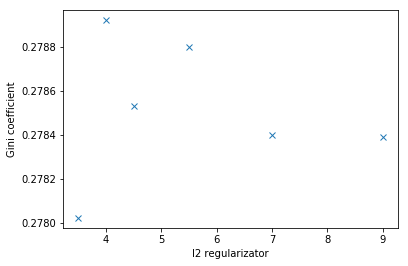

In [56]:
l2 = [3.5, 4, 4.5, 5.5, 7, 9]
sc = [0.278023, 0.278920, 0.278531, 0.2788, 0.2784, 0.27839]

plt.plot(l2,sc,'x')
plt.xlabel('l2 regularizator')
plt.ylabel('Gini coefficient')

In [70]:
def getPredictions(X_train, y_train, X_test, params, n_seed = 5, n_iter = 1000, fName = None):
    prob = np.zeros([X_test.shape[0],n_seed])
    dirName= '/tmp/porto/catboost/'
    
    # create pool
    trainPool = Pool(X_train, y_train)
    testPool =  Pool(X_test)
    
    for seed in range(0,n_seed):
        model = CatBoostClassifier(verbose=True, iterations= n_iter, eval_metric="AUC",
                                           depth=params['depth'], learning_rate=params['rate'],
                                           l2_leaf_reg=params['l2'], bagging_temperature=params['T'],
                                           od_type='Iter', od_wait=100,
                                           train_dir=dirName +"/"+ str(seed), random_seed= seed,
                                           gradient_iterations = 4, rsm= 0.9)
         
        model.fit(trainPool)
        prob[:,seed] = model.predict_proba(testPool)[:,1]
    
    df = pd.DataFrame(prob.mean(axis = 1), columns=['target'], index=X_test.index)
    if fName:
        df.to_csv(fName,index_label='id')
    
    return df

In [62]:
pred = getPredictions(train.drop("target", axis= 1), train.target, test, params, n_iter= 600, fName= 'submission19.csv')

Borders for float features generated
0:	learn 0.603689732	total: 415ms	remaining: 4m 8s
1:	learn 0.6128150476	total: 872ms	remaining: 4m 20s
2:	learn 0.6182786783	total: 1.33s	remaining: 4m 25s
3:	learn 0.6211465406	total: 1.76s	remaining: 4m 22s
4:	learn 0.6225870326	total: 2.21s	remaining: 4m 23s
5:	learn 0.6228353869	total: 2.67s	remaining: 4m 24s
6:	learn 0.6234820419	total: 3.13s	remaining: 4m 25s
7:	learn 0.6246875001	total: 3.59s	remaining: 4m 25s
8:	learn 0.6248142723	total: 4.06s	remaining: 4m 26s
9:	learn 0.6257166142	total: 4.52s	remaining: 4m 26s
10:	learn 0.6269429539	total: 4.99s	remaining: 4m 27s
11:	learn 0.6277863429	total: 5.44s	remaining: 4m 26s
12:	learn 0.6290926338	total: 5.91s	remaining: 4m 26s
13:	learn 0.6298223322	total: 6.38s	remaining: 4m 27s
14:	learn 0.6307893988	total: 6.85s	remaining: 4m 27s
15:	learn 0.6310167698	total: 7.32s	remaining: 4m 27s
16:	learn 0.6320139635	total: 7.78s	remaining: 4m 26s
17:	learn 0.6328453442	total: 8.25s	remaining: 4m 26s
18:

152:	learn 0.652389033	total: 1m 10s	remaining: 3m 26s
153:	learn 0.6523869555	total: 1m 11s	remaining: 3m 25s
154:	learn 0.6523849907	total: 1m 11s	remaining: 3m 24s
155:	learn 0.6523830371	total: 1m 11s	remaining: 3m 23s
156:	learn 0.652381293	total: 1m 11s	remaining: 3m 23s
157:	learn 0.6523795536	total: 1m 12s	remaining: 3m 22s
158:	learn 0.6523778333	total: 1m 12s	remaining: 3m 21s
159:	learn 0.6523681749	total: 1m 13s	remaining: 3m 20s
160:	learn 0.6524223095	total: 1m 13s	remaining: 3m 20s
161:	learn 0.6524181905	total: 1m 13s	remaining: 3m 19s
162:	learn 0.652416687	total: 1m 14s	remaining: 3m 19s
163:	learn 0.6524152369	total: 1m 14s	remaining: 3m 18s
164:	learn 0.6524140013	total: 1m 14s	remaining: 3m 17s
165:	learn 0.652412876	total: 1m 15s	remaining: 3m 16s
166:	learn 0.6524129767	total: 1m 15s	remaining: 3m 15s
167:	learn 0.6524118015	total: 1m 15s	remaining: 3m 15s
168:	learn 0.6524118995	total: 1m 16s	remaining: 3m 14s
169:	learn 0.6524121032	total: 1m 16s	remaining: 3m 

300:	learn 0.652821027	total: 1m 59s	remaining: 1m 59s
301:	learn 0.6528210501	total: 2m	remaining: 1m 58s
302:	learn 0.6528210598	total: 2m	remaining: 1m 58s
303:	learn 0.6528210777	total: 2m	remaining: 1m 57s
304:	learn 0.6528211041	total: 2m 1s	remaining: 1m 57s
305:	learn 0.6528211133	total: 2m 1s	remaining: 1m 56s
306:	learn 0.6528211266	total: 2m 1s	remaining: 1m 56s
307:	learn 0.6528211351	total: 2m 2s	remaining: 1m 55s
308:	learn 0.6528211504	total: 2m 2s	remaining: 1m 55s
309:	learn 0.6528211611	total: 2m 2s	remaining: 1m 54s
310:	learn 0.6528211723	total: 2m 3s	remaining: 1m 54s
311:	learn 0.6528889787	total: 2m 3s	remaining: 1m 54s
312:	learn 0.6528890387	total: 2m 3s	remaining: 1m 53s
313:	learn 0.6528891012	total: 2m 4s	remaining: 1m 53s
314:	learn 0.6528891679	total: 2m 4s	remaining: 1m 52s
315:	learn 0.6528892143	total: 2m 4s	remaining: 1m 52s
316:	learn 0.6528892622	total: 2m 5s	remaining: 1m 51s
317:	learn 0.6528893063	total: 2m 5s	remaining: 1m 51s
318:	learn 0.652889

599:	learn 0.6536363142	total: 3m 35s	remaining: 0us
Borders for float features generated
0:	learn 0.6048752486	total: 460ms	remaining: 4m 35s
1:	learn 0.6184729128	total: 901ms	remaining: 4m 29s
2:	learn 0.6195532082	total: 1.35s	remaining: 4m 28s
3:	learn 0.6212457585	total: 1.8s	remaining: 4m 27s
4:	learn 0.6213749664	total: 2.27s	remaining: 4m 30s
5:	learn 0.6222764503	total: 2.75s	remaining: 4m 32s
6:	learn 0.6226715839	total: 3.21s	remaining: 4m 32s
7:	learn 0.6236674939	total: 3.69s	remaining: 4m 33s
8:	learn 0.6254504109	total: 4.17s	remaining: 4m 34s
9:	learn 0.62613831	total: 4.7s	remaining: 4m 37s
10:	learn 0.6268078686	total: 5.23s	remaining: 4m 40s
11:	learn 0.6271322321	total: 5.78s	remaining: 4m 43s
12:	learn 0.6283218493	total: 6.28s	remaining: 4m 43s
13:	learn 0.6293211191	total: 6.77s	remaining: 4m 43s
14:	learn 0.6301421969	total: 7.26s	remaining: 4m 43s
15:	learn 0.6305109756	total: 7.76s	remaining: 4m 43s
16:	learn 0.6315204204	total: 8.26s	remaining: 4m 43s
17:	le

151:	learn 0.6516810268	total: 1m 9s	remaining: 3m 26s
152:	learn 0.651679226	total: 1m 10s	remaining: 3m 25s
153:	learn 0.6516715135	total: 1m 10s	remaining: 3m 24s
154:	learn 0.6516699435	total: 1m 11s	remaining: 3m 24s
155:	learn 0.6516683882	total: 1m 11s	remaining: 3m 23s
156:	learn 0.6516668103	total: 1m 11s	remaining: 3m 22s
157:	learn 0.6516606342	total: 1m 12s	remaining: 3m 21s
158:	learn 0.6516591847	total: 1m 12s	remaining: 3m 20s
159:	learn 0.6516578644	total: 1m 12s	remaining: 3m 20s
160:	learn 0.651656587	total: 1m 13s	remaining: 3m 19s
161:	learn 0.651655333	total: 1m 13s	remaining: 3m 18s
162:	learn 0.6516541763	total: 1m 13s	remaining: 3m 17s
163:	learn 0.6516530819	total: 1m 13s	remaining: 3m 16s
164:	learn 0.6516521263	total: 1m 14s	remaining: 3m 15s
165:	learn 0.6516513329	total: 1m 14s	remaining: 3m 15s
166:	learn 0.6516503811	total: 1m 14s	remaining: 3m 14s
167:	learn 0.6516860509	total: 1m 15s	remaining: 3m 13s
168:	learn 0.6516853012	total: 1m 15s	remaining: 3m 

299:	learn 0.652209289	total: 1m 58s	remaining: 1m 58s
300:	learn 0.6522093627	total: 1m 58s	remaining: 1m 57s
301:	learn 0.6522094279	total: 1m 58s	remaining: 1m 57s
302:	learn 0.6522095429	total: 1m 59s	remaining: 1m 56s
303:	learn 0.6522096632	total: 1m 59s	remaining: 1m 56s
304:	learn 0.6522097271	total: 1m 59s	remaining: 1m 56s
305:	learn 0.652209788	total: 2m	remaining: 1m 55s
306:	learn 0.6522199683	total: 2m	remaining: 1m 55s
307:	learn 0.6522200465	total: 2m 1s	remaining: 1m 54s
308:	learn 0.6522203748	total: 2m 1s	remaining: 1m 54s
309:	learn 0.6522206293	total: 2m 1s	remaining: 1m 53s
310:	learn 0.6522208866	total: 2m 2s	remaining: 1m 53s
311:	learn 0.6522211032	total: 2m 2s	remaining: 1m 52s
312:	learn 0.6522213986	total: 2m 2s	remaining: 1m 52s
313:	learn 0.6522216616	total: 2m 3s	remaining: 1m 52s
314:	learn 0.6522206416	total: 2m 3s	remaining: 1m 51s
315:	learn 0.6522208233	total: 2m 3s	remaining: 1m 51s
316:	learn 0.652221009	total: 2m 4s	remaining: 1m 50s
317:	learn 0.

448:	learn 0.6526610016	total: 2m 47s	remaining: 56.4s
449:	learn 0.6526610474	total: 2m 47s	remaining: 56s
450:	learn 0.6526610953	total: 2m 48s	remaining: 55.6s
451:	learn 0.6526611357	total: 2m 48s	remaining: 55.2s
452:	learn 0.6526611664	total: 2m 48s	remaining: 54.8s
453:	learn 0.6526612073	total: 2m 49s	remaining: 54.4s
454:	learn 0.6526770589	total: 2m 49s	remaining: 54.1s
455:	learn 0.6526770967	total: 2m 50s	remaining: 53.7s
456:	learn 0.6526771384	total: 2m 50s	remaining: 53.3s
457:	learn 0.6526771666	total: 2m 50s	remaining: 52.9s
458:	learn 0.6526771877	total: 2m 50s	remaining: 52.5s
459:	learn 0.6526772202	total: 2m 51s	remaining: 52.1s
460:	learn 0.6526772378	total: 2m 51s	remaining: 51.7s
461:	learn 0.6526772694	total: 2m 51s	remaining: 51.3s
462:	learn 0.6526772952	total: 2m 52s	remaining: 50.9s
463:	learn 0.6526773089	total: 2m 52s	remaining: 50.5s
464:	learn 0.6526773374	total: 2m 52s	remaining: 50.2s
465:	learn 0.6526773505	total: 2m 53s	remaining: 49.8s
466:	learn 0

599:	learn 0.6531004388	total: 3m 35s	remaining: 0us
Borders for float features generated
0:	learn 0.607926434	total: 461ms	remaining: 4m 36s
1:	learn 0.6174459794	total: 893ms	remaining: 4m 27s
2:	learn 0.6233331744	total: 1.33s	remaining: 4m 25s
3:	learn 0.6253470677	total: 1.78s	remaining: 4m 24s
4:	learn 0.6261110519	total: 2.22s	remaining: 4m 24s
5:	learn 0.627206485	total: 2.67s	remaining: 4m 24s
6:	learn 0.6269705955	total: 3.12s	remaining: 4m 24s
7:	learn 0.6276289534	total: 3.6s	remaining: 4m 26s
8:	learn 0.6277409978	total: 4.07s	remaining: 4m 27s
9:	learn 0.6287147099	total: 4.53s	remaining: 4m 27s
10:	learn 0.6298421973	total: 5s	remaining: 4m 27s
11:	learn 0.6299598964	total: 5.46s	remaining: 4m 27s
12:	learn 0.6301930972	total: 5.94s	remaining: 4m 28s
13:	learn 0.6309030538	total: 6.41s	remaining: 4m 28s
14:	learn 0.6309134131	total: 6.89s	remaining: 4m 28s
15:	learn 0.6320190996	total: 7.37s	remaining: 4m 28s
16:	learn 0.6325759538	total: 7.84s	remaining: 4m 28s
17:	lear

151:	learn 0.6515669549	total: 1m 7s	remaining: 3m 17s
152:	learn 0.6515594252	total: 1m 7s	remaining: 3m 17s
153:	learn 0.6515520686	total: 1m 7s	remaining: 3m 16s
154:	learn 0.6515502233	total: 1m 8s	remaining: 3m 15s
155:	learn 0.6515489204	total: 1m 8s	remaining: 3m 14s
156:	learn 0.6515461522	total: 1m 8s	remaining: 3m 14s
157:	learn 0.6515450631	total: 1m 9s	remaining: 3m 13s
158:	learn 0.6515440497	total: 1m 9s	remaining: 3m 12s
159:	learn 0.6515428262	total: 1m 9s	remaining: 3m 12s
160:	learn 0.6515417314	total: 1m 10s	remaining: 3m 11s
161:	learn 0.6515550199	total: 1m 10s	remaining: 3m 10s
162:	learn 0.6515541473	total: 1m 10s	remaining: 3m 10s
163:	learn 0.6515532844	total: 1m 11s	remaining: 3m 9s
164:	learn 0.6515523848	total: 1m 11s	remaining: 3m 8s
165:	learn 0.6515799022	total: 1m 12s	remaining: 3m 8s
166:	learn 0.6515791013	total: 1m 12s	remaining: 3m 7s
167:	learn 0.6515767093	total: 1m 12s	remaining: 3m 6s
168:	learn 0.6515768484	total: 1m 12s	remaining: 3m 5s
169:	le

299:	learn 0.6518304034	total: 1m 55s	remaining: 1m 55s
300:	learn 0.6518298008	total: 1m 56s	remaining: 1m 55s
301:	learn 0.6518275085	total: 1m 56s	remaining: 1m 55s
302:	learn 0.6518275344	total: 1m 56s	remaining: 1m 54s
303:	learn 0.6518371019	total: 1m 57s	remaining: 1m 54s
304:	learn 0.6518371233	total: 1m 57s	remaining: 1m 53s
305:	learn 0.6518340889	total: 1m 57s	remaining: 1m 53s
306:	learn 0.6518341093	total: 1m 58s	remaining: 1m 52s
307:	learn 0.6518313156	total: 1m 58s	remaining: 1m 52s
308:	learn 0.6518313347	total: 1m 58s	remaining: 1m 51s
309:	learn 0.6518313992	total: 1m 59s	remaining: 1m 51s
310:	learn 0.651831418	total: 1m 59s	remaining: 1m 51s
311:	learn 0.6518314347	total: 1m 59s	remaining: 1m 50s
312:	learn 0.6518314919	total: 2m	remaining: 1m 50s
313:	learn 0.6518891878	total: 2m	remaining: 1m 49s
314:	learn 0.6518892038	total: 2m	remaining: 1m 49s
315:	learn 0.65188922	total: 2m 1s	remaining: 1m 48s
316:	learn 0.6518892358	total: 2m 1s	remaining: 1m 48s
317:	lear

448:	learn 0.6522563231	total: 2m 44s	remaining: 55.2s
449:	learn 0.6523961923	total: 2m 44s	remaining: 54.8s
450:	learn 0.6523961923	total: 2m 44s	remaining: 54.5s
451:	learn 0.6523961923	total: 2m 45s	remaining: 54.1s
452:	learn 0.6523961923	total: 2m 45s	remaining: 53.7s
453:	learn 0.6523962017	total: 2m 45s	remaining: 53.4s
454:	learn 0.6523962017	total: 2m 46s	remaining: 53s
455:	learn 0.6523962017	total: 2m 46s	remaining: 52.6s
456:	learn 0.6523962017	total: 2m 46s	remaining: 52.2s
457:	learn 0.6523962017	total: 2m 47s	remaining: 51.8s
458:	learn 0.6523962111	total: 2m 47s	remaining: 51.5s
459:	learn 0.6524400839	total: 2m 48s	remaining: 51.1s
460:	learn 0.6524400839	total: 2m 48s	remaining: 50.8s
461:	learn 0.6524400927	total: 2m 48s	remaining: 50.4s
462:	learn 0.6524400927	total: 2m 49s	remaining: 50s
463:	learn 0.6524400927	total: 2m 49s	remaining: 49.6s
464:	learn 0.6524400927	total: 2m 49s	remaining: 49.3s
465:	learn 0.6524400927	total: 2m 50s	remaining: 48.9s
466:	learn 0.6

599:	learn 0.6528278949	total: 3m 35s	remaining: 0us
Borders for float features generated
0:	learn 0.6048166379	total: 529ms	remaining: 5m 16s
1:	learn 0.6133814788	total: 988ms	remaining: 4m 55s
2:	learn 0.6187571794	total: 1.5s	remaining: 4m 59s
3:	learn 0.6194859511	total: 1.96s	remaining: 4m 52s
4:	learn 0.6218008252	total: 2.44s	remaining: 4m 50s
5:	learn 0.6232771703	total: 2.92s	remaining: 4m 48s
6:	learn 0.6251605055	total: 3.38s	remaining: 4m 46s
7:	learn 0.6258104156	total: 3.84s	remaining: 4m 44s
8:	learn 0.6266267674	total: 4.3s	remaining: 4m 42s
9:	learn 0.6274744117	total: 4.76s	remaining: 4m 40s
10:	learn 0.6276189544	total: 5.23s	remaining: 4m 40s
11:	learn 0.6283025126	total: 5.71s	remaining: 4m 39s
12:	learn 0.6285629822	total: 6.17s	remaining: 4m 38s
13:	learn 0.6296265289	total: 6.64s	remaining: 4m 37s
14:	learn 0.6313366908	total: 7.11s	remaining: 4m 37s
15:	learn 0.6316184099	total: 7.58s	remaining: 4m 36s
16:	learn 0.6318755078	total: 8.05s	remaining: 4m 36s
17:	

151:	learn 0.6521577671	total: 1m 11s	remaining: 3m 30s
152:	learn 0.6521559767	total: 1m 11s	remaining: 3m 29s
153:	learn 0.6521519503	total: 1m 11s	remaining: 3m 28s
154:	learn 0.6521719996	total: 1m 12s	remaining: 3m 28s
155:	learn 0.65216776	total: 1m 12s	remaining: 3m 27s
156:	learn 0.6521692469	total: 1m 13s	remaining: 3m 26s
157:	learn 0.6521650493	total: 1m 13s	remaining: 3m 25s
158:	learn 0.6521613699	total: 1m 13s	remaining: 3m 25s
159:	learn 0.6521627491	total: 1m 14s	remaining: 3m 24s
160:	learn 0.6521587281	total: 1m 14s	remaining: 3m 23s
161:	learn 0.6521600426	total: 1m 14s	remaining: 3m 22s
162:	learn 0.6522069445	total: 1m 15s	remaining: 3m 22s
163:	learn 0.6522070499	total: 1m 15s	remaining: 3m 21s
164:	learn 0.6522039538	total: 1m 16s	remaining: 3m 20s
165:	learn 0.6522093148	total: 1m 16s	remaining: 3m 20s
166:	learn 0.6522063405	total: 1m 16s	remaining: 3m 19s
167:	learn 0.6522076567	total: 1m 17s	remaining: 3m 18s
168:	learn 0.6522077504	total: 1m 17s	remaining: 3

299:	learn 0.6525310429	total: 2m 1s	remaining: 2m 1s
300:	learn 0.6525310443	total: 2m 1s	remaining: 2m
301:	learn 0.6526019817	total: 2m 1s	remaining: 2m
302:	learn 0.6526019966	total: 2m 2s	remaining: 1m 59s
303:	learn 0.6526020109	total: 2m 2s	remaining: 1m 59s
304:	learn 0.652602025	total: 2m 3s	remaining: 1m 58s
305:	learn 0.6526020262	total: 2m 3s	remaining: 1m 58s
306:	learn 0.6526020277	total: 2m 3s	remaining: 1m 58s
307:	learn 0.6526026368	total: 2m 4s	remaining: 1m 57s
308:	learn 0.6526026381	total: 2m 4s	remaining: 1m 57s
309:	learn 0.6526026392	total: 2m 4s	remaining: 1m 56s
310:	learn 0.6526026521	total: 2m 4s	remaining: 1m 56s
311:	learn 0.6526026531	total: 2m 5s	remaining: 1m 55s
312:	learn 0.6526026537	total: 2m 5s	remaining: 1m 55s
313:	learn 0.652602666	total: 2m 5s	remaining: 1m 54s
314:	learn 0.6526026774	total: 2m 6s	remaining: 1m 54s
315:	learn 0.652602679	total: 2m 6s	remaining: 1m 53s
316:	learn 0.6525997869	total: 2m 6s	remaining: 1m 53s
317:	learn 0.652599787

447:	learn 0.6529607556	total: 2m 51s	remaining: 58s
448:	learn 0.652960756	total: 2m 51s	remaining: 57.6s
449:	learn 0.6529598933	total: 2m 51s	remaining: 57.2s
450:	learn 0.6529598937	total: 2m 52s	remaining: 56.8s
451:	learn 0.6529598942	total: 2m 52s	remaining: 56.4s
452:	learn 0.6529598948	total: 2m 52s	remaining: 56s
453:	learn 0.6529598948	total: 2m 52s	remaining: 55.6s
454:	learn 0.6529598948	total: 2m 53s	remaining: 55.2s
455:	learn 0.6529598952	total: 2m 53s	remaining: 54.8s
456:	learn 0.6529598956	total: 2m 53s	remaining: 54.4s
457:	learn 0.6529598959	total: 2m 54s	remaining: 54s
458:	learn 0.6529577704	total: 2m 54s	remaining: 53.6s
459:	learn 0.6529577704	total: 2m 54s	remaining: 53.2s
460:	learn 0.6529556995	total: 2m 55s	remaining: 52.8s
461:	learn 0.6529556995	total: 2m 55s	remaining: 52.5s
462:	learn 0.6529538295	total: 2m 56s	remaining: 52.1s
463:	learn 0.6529538295	total: 2m 56s	remaining: 51.7s
464:	learn 0.6529538298	total: 2m 56s	remaining: 51.3s
465:	learn 0.6529

598:	learn 0.6532867838	total: 3m 39s	remaining: 366ms
599:	learn 0.6532867838	total: 3m 39s	remaining: 0us
Borders for float features generated
0:	learn 0.5954840974	total: 400ms	remaining: 3m 59s
1:	learn 0.6139501239	total: 825ms	remaining: 4m 6s
2:	learn 0.6169785887	total: 1.25s	remaining: 4m 9s
3:	learn 0.619077759	total: 1.69s	remaining: 4m 12s
4:	learn 0.6224445014	total: 2.13s	remaining: 4m 14s
5:	learn 0.6225716403	total: 2.59s	remaining: 4m 16s
6:	learn 0.6229318085	total: 3.05s	remaining: 4m 18s
7:	learn 0.62452955	total: 3.5s	remaining: 4m 18s
8:	learn 0.625963692	total: 3.95s	remaining: 4m 19s
9:	learn 0.6263918165	total: 4.41s	remaining: 4m 20s
10:	learn 0.6271046257	total: 4.88s	remaining: 4m 21s
11:	learn 0.6278409186	total: 5.36s	remaining: 4m 22s
12:	learn 0.6284715419	total: 5.83s	remaining: 4m 23s
13:	learn 0.6290536472	total: 6.32s	remaining: 4m 24s
14:	learn 0.6291739755	total: 6.8s	remaining: 4m 25s
15:	learn 0.6304677048	total: 7.27s	remaining: 4m 25s
16:	learn

150:	learn 0.6519823207	total: 1m 7s	remaining: 3m 19s
151:	learn 0.6519825995	total: 1m 7s	remaining: 3m 18s
152:	learn 0.6519828139	total: 1m 7s	remaining: 3m 17s
153:	learn 0.6519952492	total: 1m 8s	remaining: 3m 17s
154:	learn 0.652133515	total: 1m 8s	remaining: 3m 16s
155:	learn 0.6521336516	total: 1m 8s	remaining: 3m 15s
156:	learn 0.6521337818	total: 1m 9s	remaining: 3m 15s
157:	learn 0.6521339149	total: 1m 9s	remaining: 3m 14s
158:	learn 0.652134029	total: 1m 9s	remaining: 3m 13s
159:	learn 0.6521312204	total: 1m 10s	remaining: 3m 12s
160:	learn 0.6521313308	total: 1m 10s	remaining: 3m 11s
161:	learn 0.6521314554	total: 1m 10s	remaining: 3m 10s
162:	learn 0.6521316822	total: 1m 10s	remaining: 3m 10s
163:	learn 0.6521317981	total: 1m 11s	remaining: 3m 9s
164:	learn 0.6521319093	total: 1m 11s	remaining: 3m 8s
165:	learn 0.6521320157	total: 1m 11s	remaining: 3m 7s
166:	learn 0.6521321246	total: 1m 12s	remaining: 3m 7s
167:	learn 0.6521322258	total: 1m 12s	remaining: 3m 6s
168:	lea

298:	learn 0.6524918242	total: 1m 55s	remaining: 1m 56s
299:	learn 0.6524918397	total: 1m 55s	remaining: 1m 55s
300:	learn 0.6524918419	total: 1m 55s	remaining: 1m 55s
301:	learn 0.6524893816	total: 1m 56s	remaining: 1m 54s
302:	learn 0.6524855725	total: 1m 56s	remaining: 1m 54s
303:	learn 0.6524855877	total: 1m 56s	remaining: 1m 53s
304:	learn 0.6525464175	total: 1m 57s	remaining: 1m 53s
305:	learn 0.6525464194	total: 1m 57s	remaining: 1m 53s
306:	learn 0.6525464335	total: 1m 57s	remaining: 1m 52s
307:	learn 0.6525464349	total: 1m 58s	remaining: 1m 52s
308:	learn 0.6525464366	total: 1m 58s	remaining: 1m 51s
309:	learn 0.6525464505	total: 1m 58s	remaining: 1m 51s
310:	learn 0.6525464636	total: 1m 59s	remaining: 1m 50s
311:	learn 0.652546465	total: 1m 59s	remaining: 1m 50s
312:	learn 0.6525464664	total: 1m 59s	remaining: 1m 49s
313:	learn 0.6525464793	total: 2m	remaining: 1m 49s
314:	learn 0.6525464807	total: 2m	remaining: 1m 48s
315:	learn 0.6525464816	total: 2m	remaining: 1m 48s
316:	

446:	learn 0.652766599	total: 2m 43s	remaining: 55.8s
447:	learn 0.6527666005	total: 2m 43s	remaining: 55.4s
448:	learn 0.6527666005	total: 2m 43s	remaining: 55s
449:	learn 0.6527666005	total: 2m 43s	remaining: 54.7s
450:	learn 0.6527666005	total: 2m 44s	remaining: 54.3s
451:	learn 0.6527628134	total: 2m 44s	remaining: 53.9s
452:	learn 0.6527628147	total: 2m 44s	remaining: 53.5s
453:	learn 0.6527628155	total: 2m 45s	remaining: 53.2s
454:	learn 0.6527628155	total: 2m 45s	remaining: 52.8s
455:	learn 0.6527621613	total: 2m 45s	remaining: 52.4s
456:	learn 0.6527626557	total: 2m 46s	remaining: 52s
457:	learn 0.6527626567	total: 2m 46s	remaining: 51.7s
458:	learn 0.652762047	total: 2m 47s	remaining: 51.3s
459:	learn 0.652762047	total: 2m 47s	remaining: 50.9s
460:	learn 0.6528804021	total: 2m 47s	remaining: 50.6s
461:	learn 0.6528804021	total: 2m 48s	remaining: 50.2s
462:	learn 0.6528804021	total: 2m 48s	remaining: 49.8s
463:	learn 0.6528804037	total: 2m 48s	remaining: 49.4s
464:	learn 0.6528

597:	learn 0.6532897416	total: 3m 30s	remaining: 703ms
598:	learn 0.6532897416	total: 3m 30s	remaining: 352ms
599:	learn 0.6532897417	total: 3m 30s	remaining: 0us


score 0.280

In [67]:
pred2 = getPredictions(train.drop("target", axis= 1), train.target, test, params, n_iter= 900, fName= 'submission21.csv')

Borders for float features generated
0:	learn 0.588340756	total: 461ms	remaining: 6m 54s
1:	learn 0.6022231197	total: 887ms	remaining: 6m 38s
2:	learn 0.601464038	total: 1.35s	remaining: 6m 44s
3:	learn 0.6132966786	total: 1.9s	remaining: 7m 4s
4:	learn 0.6133887582	total: 2.42s	remaining: 7m 13s
5:	learn 0.616581964	total: 2.94s	remaining: 7m 18s
6:	learn 0.6178695618	total: 3.4s	remaining: 7m 13s
7:	learn 0.6208160278	total: 3.86s	remaining: 7m 9s
8:	learn 0.6210368062	total: 4.36s	remaining: 7m 11s
9:	learn 0.6234600202	total: 4.84s	remaining: 7m 10s
10:	learn 0.623998053	total: 5.34s	remaining: 7m 11s
11:	learn 0.6259599132	total: 5.8s	remaining: 7m 9s
12:	learn 0.6269405388	total: 6.27s	remaining: 7m 7s
13:	learn 0.6275372235	total: 6.76s	remaining: 7m 8s
14:	learn 0.6276070791	total: 7.25s	remaining: 7m 7s
15:	learn 0.6281577276	total: 7.72s	remaining: 7m 6s
16:	learn 0.6275438965	total: 8.11s	remaining: 7m 1s
17:	learn 0.6277499452	total: 8.53s	remaining: 6m 58s
18:	learn 0.6287

299:	learn 0.6508680258	total: 2m 9s	remaining: 4m 19s
300:	learn 0.6508681488	total: 2m 10s	remaining: 4m 18s
301:	learn 0.6508682566	total: 2m 10s	remaining: 4m 18s
302:	learn 0.6508683575	total: 2m 10s	remaining: 4m 17s
303:	learn 0.6508684435	total: 2m 11s	remaining: 4m 16s
304:	learn 0.6508685594	total: 2m 11s	remaining: 4m 16s
305:	learn 0.6508686892	total: 2m 11s	remaining: 4m 15s
306:	learn 0.6508687702	total: 2m 12s	remaining: 4m 15s
307:	learn 0.6508688518	total: 2m 12s	remaining: 4m 14s
308:	learn 0.6508689139	total: 2m 12s	remaining: 4m 13s
309:	learn 0.6508903005	total: 2m 13s	remaining: 4m 13s
310:	learn 0.650890363	total: 2m 13s	remaining: 4m 12s
311:	learn 0.6508904357	total: 2m 13s	remaining: 4m 12s
312:	learn 0.6508904893	total: 2m 14s	remaining: 4m 11s
313:	learn 0.6508905377	total: 2m 14s	remaining: 4m 11s
314:	learn 0.6508905727	total: 2m 14s	remaining: 4m 10s
315:	learn 0.6508906127	total: 2m 15s	remaining: 4m 9s
316:	learn 0.651019832	total: 2m 15s	remaining: 4m 

447:	learn 0.651482024	total: 3m 1s	remaining: 3m 3s
448:	learn 0.6514820658	total: 3m 1s	remaining: 3m 2s
449:	learn 0.6514821027	total: 3m 2s	remaining: 3m 2s
450:	learn 0.651482176	total: 3m 2s	remaining: 3m 1s
451:	learn 0.6514822095	total: 3m 2s	remaining: 3m 1s
452:	learn 0.6514822478	total: 3m 3s	remaining: 3m
453:	learn 0.6514823095	total: 3m 3s	remaining: 3m
454:	learn 0.6514823363	total: 3m 3s	remaining: 2m 59s
455:	learn 0.6514823575	total: 3m 4s	remaining: 2m 59s
456:	learn 0.6514823797	total: 3m 4s	remaining: 2m 58s
457:	learn 0.6514824023	total: 3m 4s	remaining: 2m 58s
458:	learn 0.6514824245	total: 3m 5s	remaining: 2m 57s
459:	learn 0.6514824506	total: 3m 5s	remaining: 2m 57s
460:	learn 0.6514825003	total: 3m 5s	remaining: 2m 57s
461:	learn 0.6515825474	total: 3m 6s	remaining: 2m 56s
462:	learn 0.6515825656	total: 3m 6s	remaining: 2m 56s
463:	learn 0.651582606	total: 3m 7s	remaining: 2m 55s
464:	learn 0.6515828611	total: 3m 7s	remaining: 2m 55s
465:	learn 0.6515830912	to

595:	learn 0.652022566	total: 3m 48s	remaining: 1m 56s
596:	learn 0.6520226614	total: 3m 48s	remaining: 1m 55s
597:	learn 0.6520227323	total: 3m 48s	remaining: 1m 55s
598:	learn 0.6520227981	total: 3m 48s	remaining: 1m 55s
599:	learn 0.6520228099	total: 3m 49s	remaining: 1m 54s
600:	learn 0.6520228896	total: 3m 49s	remaining: 1m 54s
601:	learn 0.6520229615	total: 3m 49s	remaining: 1m 53s
602:	learn 0.6520230274	total: 3m 50s	remaining: 1m 53s
603:	learn 0.6520230706	total: 3m 50s	remaining: 1m 52s
604:	learn 0.6520231222	total: 3m 50s	remaining: 1m 52s
605:	learn 0.6520231798	total: 3m 50s	remaining: 1m 52s
606:	learn 0.6520232224	total: 3m 51s	remaining: 1m 51s
607:	learn 0.6520232624	total: 3m 51s	remaining: 1m 51s
608:	learn 0.652023301	total: 3m 51s	remaining: 1m 50s
609:	learn 0.6520233445	total: 3m 52s	remaining: 1m 50s
610:	learn 0.6520233829	total: 3m 52s	remaining: 1m 49s
611:	learn 0.6520234186	total: 3m 52s	remaining: 1m 49s
612:	learn 0.652023471	total: 3m 53s	remaining: 1m

744:	learn 0.652397653	total: 4m 34s	remaining: 57.1s
745:	learn 0.6523976521	total: 4m 34s	remaining: 56.7s
746:	learn 0.6523976522	total: 4m 35s	remaining: 56.4s
747:	learn 0.6523976514	total: 4m 35s	remaining: 56s
748:	learn 0.6523976813	total: 4m 35s	remaining: 55.6s
749:	learn 0.6523976927	total: 4m 36s	remaining: 55.2s
750:	learn 0.6523976917	total: 4m 36s	remaining: 54.8s
751:	learn 0.6523976914	total: 4m 36s	remaining: 54.5s
752:	learn 0.6523976914	total: 4m 37s	remaining: 54.1s
753:	learn 0.6523976903	total: 4m 37s	remaining: 53.7s
754:	learn 0.6523976898	total: 4m 37s	remaining: 53.3s
755:	learn 0.6523976899	total: 4m 37s	remaining: 52.9s
756:	learn 0.652535009	total: 4m 38s	remaining: 52.6s
757:	learn 0.6525350424	total: 4m 38s	remaining: 52.2s
758:	learn 0.6525350992	total: 4m 39s	remaining: 51.8s
759:	learn 0.652535135	total: 4m 39s	remaining: 51.5s
760:	learn 0.6525351816	total: 4m 39s	remaining: 51.1s
761:	learn 0.6525352132	total: 4m 40s	remaining: 50.7s
762:	learn 0.65

895:	learn 0.6530073705	total: 5m 25s	remaining: 1.45s
896:	learn 0.6530074067	total: 5m 25s	remaining: 1.09s
897:	learn 0.6530074301	total: 5m 25s	remaining: 726ms
898:	learn 0.6530074556	total: 5m 26s	remaining: 363ms
899:	learn 0.6530074735	total: 5m 26s	remaining: 0us
Borders for float features generated
0:	learn 0.5795608595	total: 468ms	remaining: 7m
1:	learn 0.5960245899	total: 935ms	remaining: 6m 59s
2:	learn 0.6082585538	total: 1.42s	remaining: 7m 5s
3:	learn 0.609076385	total: 1.96s	remaining: 7m 19s
4:	learn 0.6114409111	total: 2.5s	remaining: 7m 28s
5:	learn 0.6142333397	total: 3.09s	remaining: 7m 41s
6:	learn 0.6191590485	total: 3.59s	remaining: 7m 38s
7:	learn 0.6212199787	total: 4.1s	remaining: 7m 37s
8:	learn 0.6215568579	total: 4.61s	remaining: 7m 36s
9:	learn 0.6216972565	total: 5.12s	remaining: 7m 35s
10:	learn 0.6228361597	total: 5.59s	remaining: 7m 31s
11:	learn 0.6228062987	total: 6.09s	remaining: 7m 30s
12:	learn 0.6237229153	total: 6.6s	remaining: 7m 30s
13:	lea

148:	learn 0.6499098977	total: 1m 12s	remaining: 6m 4s
149:	learn 0.6499479359	total: 1m 12s	remaining: 6m 3s
150:	learn 0.6499450014	total: 1m 13s	remaining: 6m 2s
151:	learn 0.6500035631	total: 1m 13s	remaining: 6m 2s
152:	learn 0.6500007878	total: 1m 13s	remaining: 6m
153:	learn 0.6499981745	total: 1m 14s	remaining: 5m 59s
154:	learn 0.6499957057	total: 1m 14s	remaining: 5m 58s
155:	learn 0.6499931889	total: 1m 14s	remaining: 5m 57s
156:	learn 0.6499908355	total: 1m 15s	remaining: 5m 56s
157:	learn 0.6499885521	total: 1m 15s	remaining: 5m 55s
158:	learn 0.6499865141	total: 1m 16s	remaining: 5m 54s
159:	learn 0.6499845709	total: 1m 16s	remaining: 5m 53s
160:	learn 0.6499825512	total: 1m 16s	remaining: 5m 51s
161:	learn 0.649980708	total: 1m 16s	remaining: 5m 50s
162:	learn 0.6499784633	total: 1m 17s	remaining: 5m 49s
163:	learn 0.649976601	total: 1m 17s	remaining: 5m 48s
164:	learn 0.6499747019	total: 1m 18s	remaining: 5m 48s
165:	learn 0.6499730852	total: 1m 18s	remaining: 5m 46s
16

296:	learn 0.6507590017	total: 2m 3s	remaining: 4m 9s
297:	learn 0.6507591704	total: 2m 3s	remaining: 4m 9s
298:	learn 0.6507592345	total: 2m 3s	remaining: 4m 8s
299:	learn 0.6507594251	total: 2m 4s	remaining: 4m 8s
300:	learn 0.6507596212	total: 2m 4s	remaining: 4m 7s
301:	learn 0.650759792	total: 2m 4s	remaining: 4m 6s
302:	learn 0.6507599692	total: 2m 5s	remaining: 4m 6s
303:	learn 0.6507601146	total: 2m 5s	remaining: 4m 5s
304:	learn 0.6507602874	total: 2m 5s	remaining: 4m 5s
305:	learn 0.6507603955	total: 2m 6s	remaining: 4m 4s
306:	learn 0.650760512	total: 2m 6s	remaining: 4m 4s
307:	learn 0.6507606293	total: 2m 6s	remaining: 4m 3s
308:	learn 0.650760691	total: 2m 6s	remaining: 4m 2s
309:	learn 0.6507608169	total: 2m 7s	remaining: 4m 2s
310:	learn 0.6507609872	total: 2m 7s	remaining: 4m 1s
311:	learn 0.650761104	total: 2m 7s	remaining: 4m 1s
312:	learn 0.650761215	total: 2m 8s	remaining: 4m
313:	learn 0.6507612871	total: 2m 8s	remaining: 4m
314:	learn 0.6507613523	total: 2m 8s	re

444:	learn 0.6513739326	total: 2m 53s	remaining: 2m 57s
445:	learn 0.6513739061	total: 2m 53s	remaining: 2m 56s
446:	learn 0.6513739048	total: 2m 54s	remaining: 2m 56s
447:	learn 0.6513739126	total: 2m 54s	remaining: 2m 56s
448:	learn 0.651373899	total: 2m 54s	remaining: 2m 55s
449:	learn 0.6513738732	total: 2m 55s	remaining: 2m 55s
450:	learn 0.6513738486	total: 2m 55s	remaining: 2m 54s
451:	learn 0.6513738388	total: 2m 55s	remaining: 2m 54s
452:	learn 0.6513739066	total: 2m 56s	remaining: 2m 53s
453:	learn 0.6513738853	total: 2m 56s	remaining: 2m 53s
454:	learn 0.6513738771	total: 2m 56s	remaining: 2m 52s
455:	learn 0.6513738927	total: 2m 57s	remaining: 2m 52s
456:	learn 0.6513738818	total: 2m 57s	remaining: 2m 51s
457:	learn 0.65137388	total: 2m 57s	remaining: 2m 51s
458:	learn 0.6513738711	total: 2m 57s	remaining: 2m 50s
459:	learn 0.6513738629	total: 2m 58s	remaining: 2m 50s
460:	learn 0.6513738486	total: 2m 58s	remaining: 2m 50s
461:	learn 0.6513738419	total: 2m 58s	remaining: 2m

592:	learn 0.6517593475	total: 3m 39s	remaining: 1m 53s
593:	learn 0.6517593453	total: 3m 40s	remaining: 1m 53s
594:	learn 0.6517593486	total: 3m 40s	remaining: 1m 52s
595:	learn 0.6517593531	total: 3m 40s	remaining: 1m 52s
596:	learn 0.6517593697	total: 3m 41s	remaining: 1m 52s
597:	learn 0.6517593728	total: 3m 41s	remaining: 1m 51s
598:	learn 0.651759369	total: 3m 41s	remaining: 1m 51s
599:	learn 0.6517599386	total: 3m 42s	remaining: 1m 51s
600:	learn 0.651760143	total: 3m 42s	remaining: 1m 50s
601:	learn 0.6518322155	total: 3m 42s	remaining: 1m 50s
602:	learn 0.6518322988	total: 3m 43s	remaining: 1m 49s
603:	learn 0.6518324065	total: 3m 43s	remaining: 1m 49s
604:	learn 0.6518324856	total: 3m 43s	remaining: 1m 49s
605:	learn 0.6518325403	total: 3m 43s	remaining: 1m 48s
606:	learn 0.6518326176	total: 3m 44s	remaining: 1m 48s
607:	learn 0.6518326994	total: 3m 44s	remaining: 1m 47s
608:	learn 0.6518327392	total: 3m 44s	remaining: 1m 47s
609:	learn 0.6518327959	total: 3m 45s	remaining: 1

891:	learn 0.6525331648	total: 5m 16s	remaining: 2.83s
892:	learn 0.6525331751	total: 5m 16s	remaining: 2.48s
893:	learn 0.6525331815	total: 5m 16s	remaining: 2.13s
894:	learn 0.6526305313	total: 5m 17s	remaining: 1.77s
895:	learn 0.6526306025	total: 5m 17s	remaining: 1.42s
896:	learn 0.6526306776	total: 5m 17s	remaining: 1.06s
897:	learn 0.652630764	total: 5m 18s	remaining: 709ms
898:	learn 0.6526308686	total: 5m 18s	remaining: 354ms
899:	learn 0.6526309397	total: 5m 18s	remaining: 0us
Borders for float features generated
0:	learn 0.5771289959	total: 488ms	remaining: 7m 18s
1:	learn 0.5958851945	total: 962ms	remaining: 7m 11s
2:	learn 0.6079522446	total: 1.37s	remaining: 6m 51s
3:	learn 0.605793309	total: 1.82s	remaining: 6m 48s
4:	learn 0.6065129943	total: 2.24s	remaining: 6m 40s
5:	learn 0.6076543724	total: 2.64s	remaining: 6m 34s
6:	learn 0.6162494771	total: 3.08s	remaining: 6m 33s
7:	learn 0.6201474496	total: 3.54s	remaining: 6m 34s
8:	learn 0.6221200417	total: 3.99s	remaining: 6m

143:	learn 0.6498993202	total: 1m 6s	remaining: 5m 49s
144:	learn 0.6498962239	total: 1m 6s	remaining: 5m 48s
145:	learn 0.649890458	total: 1m 7s	remaining: 5m 47s
146:	learn 0.6498872981	total: 1m 7s	remaining: 5m 46s
147:	learn 0.6498842531	total: 1m 8s	remaining: 5m 45s
148:	learn 0.6498843377	total: 1m 8s	remaining: 5m 44s
149:	learn 0.64988015	total: 1m 8s	remaining: 5m 43s
150:	learn 0.6498802519	total: 1m 9s	remaining: 5m 42s
151:	learn 0.6498763383	total: 1m 9s	remaining: 5m 41s
152:	learn 0.6498737487	total: 1m 9s	remaining: 5m 41s
153:	learn 0.6498714919	total: 1m 10s	remaining: 5m 40s
154:	learn 0.6498690224	total: 1m 10s	remaining: 5m 39s
155:	learn 0.649869104	total: 1m 10s	remaining: 5m 38s
156:	learn 0.6498668095	total: 1m 11s	remaining: 5m 37s
157:	learn 0.6498668877	total: 1m 11s	remaining: 5m 36s
158:	learn 0.6499740203	total: 1m 12s	remaining: 5m 35s
159:	learn 0.6499741097	total: 1m 12s	remaining: 5m 34s
160:	learn 0.6499721829	total: 1m 12s	remaining: 5m 33s
161:	l

291:	learn 0.6507080964	total: 2m 2s	remaining: 4m 14s
292:	learn 0.6507081377	total: 2m 2s	remaining: 4m 13s
293:	learn 0.6507081386	total: 2m 2s	remaining: 4m 13s
294:	learn 0.6507081385	total: 2m 3s	remaining: 4m 12s
295:	learn 0.6507818811	total: 2m 3s	remaining: 4m 12s
296:	learn 0.6507819213	total: 2m 4s	remaining: 4m 11s
297:	learn 0.6507820035	total: 2m 4s	remaining: 4m 11s
298:	learn 0.6507820992	total: 2m 4s	remaining: 4m 10s
299:	learn 0.6507821653	total: 2m 5s	remaining: 4m 10s
300:	learn 0.6507822202	total: 2m 5s	remaining: 4m 9s
301:	learn 0.6507822671	total: 2m 5s	remaining: 4m 9s
302:	learn 0.6507823209	total: 2m 6s	remaining: 4m 8s
303:	learn 0.6508181262	total: 2m 6s	remaining: 4m 8s
304:	learn 0.6508182856	total: 2m 7s	remaining: 4m 7s
305:	learn 0.650818327	total: 2m 7s	remaining: 4m 7s
306:	learn 0.6508183611	total: 2m 7s	remaining: 4m 6s
307:	learn 0.6508184888	total: 2m 8s	remaining: 4m 6s
308:	learn 0.6508185262	total: 2m 8s	remaining: 4m 5s
309:	learn 0.6508185

439:	learn 0.651642226	total: 2m 56s	remaining: 3m 4s
440:	learn 0.6516422375	total: 2m 56s	remaining: 3m 4s
441:	learn 0.6516423373	total: 2m 57s	remaining: 3m 3s
442:	learn 0.6516423496	total: 2m 57s	remaining: 3m 3s
443:	learn 0.651642362	total: 2m 57s	remaining: 3m 2s
444:	learn 0.6516423936	total: 2m 58s	remaining: 3m 2s
445:	learn 0.6516424274	total: 2m 58s	remaining: 3m 1s
446:	learn 0.6516425087	total: 2m 58s	remaining: 3m 1s
447:	learn 0.6516425841	total: 2m 59s	remaining: 3m
448:	learn 0.6516425964	total: 2m 59s	remaining: 3m
449:	learn 0.651642663	total: 2m 59s	remaining: 2m 59s
450:	learn 0.651642741	total: 3m	remaining: 2m 59s
451:	learn 0.6516428051	total: 3m	remaining: 2m 59s
452:	learn 0.6516428535	total: 3m	remaining: 2m 58s
453:	learn 0.6516428847	total: 3m 1s	remaining: 2m 58s
454:	learn 0.651642896	total: 3m 1s	remaining: 2m 57s
455:	learn 0.6516429749	total: 3m 2s	remaining: 2m 57s
456:	learn 0.6516430406	total: 3m 2s	remaining: 2m 56s
457:	learn 0.651643115	total:

735:	learn 0.6527017063	total: 4m 35s	remaining: 1m 1s
736:	learn 0.6527017065	total: 4m 35s	remaining: 1m
737:	learn 0.6527017069	total: 4m 36s	remaining: 1m
738:	learn 0.6527017072	total: 4m 36s	remaining: 1m
739:	learn 0.6527017809	total: 4m 36s	remaining: 59.8s
740:	learn 0.6527018304	total: 4m 36s	remaining: 59.4s
741:	learn 0.652713982	total: 4m 37s	remaining: 59.1s
742:	learn 0.6527140617	total: 4m 37s	remaining: 58.7s
743:	learn 0.6527140622	total: 4m 38s	remaining: 58.3s
744:	learn 0.6527140627	total: 4m 38s	remaining: 57.9s
745:	learn 0.6527258826	total: 4m 38s	remaining: 57.6s
746:	learn 0.6527698579	total: 4m 39s	remaining: 57.2s
747:	learn 0.6527699302	total: 4m 39s	remaining: 56.8s
748:	learn 0.6527699927	total: 4m 39s	remaining: 56.4s
749:	learn 0.6527700366	total: 4m 40s	remaining: 56s
750:	learn 0.6527700938	total: 4m 40s	remaining: 55.7s
751:	learn 0.6527701355	total: 4m 40s	remaining: 55.3s
752:	learn 0.652770136	total: 4m 41s	remaining: 54.9s
753:	learn 0.6527701668

886:	learn 0.6531600736	total: 5m 23s	remaining: 4.74s
887:	learn 0.6531600736	total: 5m 23s	remaining: 4.37s
888:	learn 0.6531600618	total: 5m 23s	remaining: 4.01s
889:	learn 0.6531600618	total: 5m 24s	remaining: 3.64s
890:	learn 0.6531600496	total: 5m 24s	remaining: 3.28s
891:	learn 0.6531600364	total: 5m 24s	remaining: 2.91s
892:	learn 0.6531600364	total: 5m 25s	remaining: 2.55s
893:	learn 0.6531600293	total: 5m 25s	remaining: 2.18s
894:	learn 0.6531600197	total: 5m 25s	remaining: 1.82s
895:	learn 0.6531600119	total: 5m 25s	remaining: 1.46s
896:	learn 0.6531600129	total: 5m 26s	remaining: 1.09s
897:	learn 0.6531600129	total: 5m 26s	remaining: 727ms
898:	learn 0.6531600108	total: 5m 26s	remaining: 364ms
899:	learn 0.6531600108	total: 5m 27s	remaining: 0us
Borders for float features generated
0:	learn 0.5729720271	total: 438ms	remaining: 6m 33s
1:	learn 0.5957233747	total: 854ms	remaining: 6m 23s
2:	learn 0.6027024041	total: 1.27s	remaining: 6m 20s
3:	learn 0.6073142673	total: 1.72s	r

138:	learn 0.6499434079	total: 1m 2s	remaining: 5m 40s
139:	learn 0.6499370408	total: 1m 2s	remaining: 5m 39s
140:	learn 0.6499424851	total: 1m 2s	remaining: 5m 38s
141:	learn 0.6499373253	total: 1m 3s	remaining: 5m 38s
142:	learn 0.6499452709	total: 1m 3s	remaining: 5m 37s
143:	learn 0.6499453649	total: 1m 4s	remaining: 5m 36s
144:	learn 0.6499456347	total: 1m 4s	remaining: 5m 35s
145:	learn 0.6499389459	total: 1m 4s	remaining: 5m 34s
146:	learn 0.649939385	total: 1m 5s	remaining: 5m 33s
147:	learn 0.649935659	total: 1m 5s	remaining: 5m 32s
148:	learn 0.6499335252	total: 1m 5s	remaining: 5m 31s
149:	learn 0.6499300225	total: 1m 6s	remaining: 5m 30s
150:	learn 0.6499659755	total: 1m 6s	remaining: 5m 29s
151:	learn 0.6499626716	total: 1m 6s	remaining: 5m 28s
152:	learn 0.6499627681	total: 1m 7s	remaining: 5m 27s
153:	learn 0.6500214506	total: 1m 7s	remaining: 5m 27s
154:	learn 0.6500184585	total: 1m 7s	remaining: 5m 26s
155:	learn 0.6500163569	total: 1m 8s	remaining: 5m 25s
156:	learn 0

286:	learn 0.6506496536	total: 1m 49s	remaining: 3m 54s
287:	learn 0.6506496709	total: 1m 49s	remaining: 3m 53s
288:	learn 0.6506496901	total: 1m 50s	remaining: 3m 53s
289:	learn 0.6506497413	total: 1m 50s	remaining: 3m 52s
290:	learn 0.6506479581	total: 1m 50s	remaining: 3m 52s
291:	learn 0.6506479757	total: 1m 51s	remaining: 3m 51s
292:	learn 0.650647993	total: 1m 51s	remaining: 3m 50s
293:	learn 0.6506480106	total: 1m 51s	remaining: 3m 50s
294:	learn 0.6506480678	total: 1m 52s	remaining: 3m 49s
295:	learn 0.6506480849	total: 1m 52s	remaining: 3m 49s
296:	learn 0.6506481005	total: 1m 52s	remaining: 3m 48s
297:	learn 0.6506481168	total: 1m 52s	remaining: 3m 48s
298:	learn 0.6506481313	total: 1m 53s	remaining: 3m 47s
299:	learn 0.6506481459	total: 1m 53s	remaining: 3m 46s
300:	learn 0.6506481613	total: 1m 53s	remaining: 3m 46s
301:	learn 0.650648226	total: 1m 54s	remaining: 3m 45s
302:	learn 0.65064824	total: 1m 54s	remaining: 3m 45s
303:	learn 0.6506483005	total: 1m 54s	remaining: 3m 

582:	learn 0.6518651386	total: 3m 20s	remaining: 1m 48s
583:	learn 0.6518651431	total: 3m 20s	remaining: 1m 48s
584:	learn 0.6518651431	total: 3m 20s	remaining: 1m 48s
585:	learn 0.6518649092	total: 3m 21s	remaining: 1m 47s
586:	learn 0.6518646853	total: 3m 21s	remaining: 1m 47s
587:	learn 0.6518646855	total: 3m 21s	remaining: 1m 47s
588:	learn 0.6518646855	total: 3m 22s	remaining: 1m 46s
589:	learn 0.6518644732	total: 3m 22s	remaining: 1m 46s
590:	learn 0.6518644732	total: 3m 22s	remaining: 1m 45s
591:	learn 0.6519784734	total: 3m 23s	remaining: 1m 45s
592:	learn 0.6519784734	total: 3m 23s	remaining: 1m 45s
593:	learn 0.6519780982	total: 3m 23s	remaining: 1m 44s
594:	learn 0.6519776589	total: 3m 24s	remaining: 1m 44s
595:	learn 0.6519776589	total: 3m 24s	remaining: 1m 44s
596:	learn 0.6519776589	total: 3m 24s	remaining: 1m 43s
597:	learn 0.6519776589	total: 3m 24s	remaining: 1m 43s
598:	learn 0.6519776589	total: 3m 25s	remaining: 1m 43s
599:	learn 0.6519776622	total: 3m 25s	remaining:

730:	learn 0.6523523764	total: 4m 5s	remaining: 56.8s
731:	learn 0.6523523643	total: 4m 5s	remaining: 56.4s
732:	learn 0.6523523498	total: 4m 6s	remaining: 56.1s
733:	learn 0.6523523429	total: 4m 6s	remaining: 55.7s
734:	learn 0.6524509071	total: 4m 6s	remaining: 55.4s
735:	learn 0.6524509017	total: 4m 7s	remaining: 55.1s
736:	learn 0.6524508957	total: 4m 7s	remaining: 54.7s
737:	learn 0.6524508911	total: 4m 7s	remaining: 54.4s
738:	learn 0.6524508839	total: 4m 8s	remaining: 54s
739:	learn 0.6524508784	total: 4m 8s	remaining: 53.7s
740:	learn 0.6524508751	total: 4m 8s	remaining: 53.4s
741:	learn 0.6524508686	total: 4m 8s	remaining: 53s
742:	learn 0.6524508587	total: 4m 9s	remaining: 52.7s
743:	learn 0.6524508549	total: 4m 9s	remaining: 52.3s
744:	learn 0.6524508506	total: 4m 9s	remaining: 52s
745:	learn 0.6524508484	total: 4m 10s	remaining: 51.6s
746:	learn 0.6524508451	total: 4m 10s	remaining: 51.3s
747:	learn 0.6524508412	total: 4m 10s	remaining: 51s
748:	learn 0.6524508387	total: 4m

881:	learn 0.6528271159	total: 4m 53s	remaining: 6s
882:	learn 0.6528271161	total: 4m 54s	remaining: 5.66s
883:	learn 0.6528271107	total: 4m 54s	remaining: 5.33s
884:	learn 0.6528271089	total: 4m 54s	remaining: 4.99s
885:	learn 0.6528271061	total: 4m 54s	remaining: 4.66s
886:	learn 0.652827104	total: 4m 55s	remaining: 4.33s
887:	learn 0.6528271041	total: 4m 55s	remaining: 3.99s
888:	learn 0.6528270987	total: 4m 55s	remaining: 3.66s
889:	learn 0.652827095	total: 4m 56s	remaining: 3.33s
890:	learn 0.6528270924	total: 4m 56s	remaining: 3s
891:	learn 0.6528270905	total: 4m 56s	remaining: 2.66s
892:	learn 0.6528270887	total: 4m 57s	remaining: 2.33s
893:	learn 0.6528270875	total: 4m 57s	remaining: 2s
894:	learn 0.6528270875	total: 4m 57s	remaining: 1.66s
895:	learn 0.6528270839	total: 4m 57s	remaining: 1.33s
896:	learn 0.6528270826	total: 4m 58s	remaining: 997ms
897:	learn 0.6528270794	total: 4m 58s	remaining: 665ms
898:	learn 0.6528270772	total: 4m 58s	remaining: 332ms
899:	learn 0.65282707

133:	learn 0.6500463999	total: 58.9s	remaining: 5m 36s
134:	learn 0.6500464844	total: 59.2s	remaining: 5m 35s
135:	learn 0.6500465716	total: 59.4s	remaining: 5m 33s
136:	learn 0.6500466509	total: 59.7s	remaining: 5m 32s
137:	learn 0.6500428431	total: 1m	remaining: 5m 31s
138:	learn 0.6501264351	total: 1m	remaining: 5m 31s
139:	learn 0.6501231839	total: 1m	remaining: 5m 29s
140:	learn 0.6501195346	total: 1m 1s	remaining: 5m 28s
141:	learn 0.6501196269	total: 1m 1s	remaining: 5m 27s
142:	learn 0.650119801	total: 1m 1s	remaining: 5m 26s
143:	learn 0.6501199746	total: 1m 2s	remaining: 5m 25s
144:	learn 0.65012687	total: 1m 2s	remaining: 5m 25s
145:	learn 0.6501175327	total: 1m 2s	remaining: 5m 24s
146:	learn 0.6501147712	total: 1m 3s	remaining: 5m 23s
147:	learn 0.6501115362	total: 1m 3s	remaining: 5m 23s
148:	learn 0.6501082503	total: 1m 3s	remaining: 5m 22s
149:	learn 0.6501083274	total: 1m 4s	remaining: 5m 21s
150:	learn 0.6501058965	total: 1m 4s	remaining: 5m 19s
151:	learn 0.650106064

282:	learn 0.6508702756	total: 1m 46s	remaining: 3m 52s
283:	learn 0.6508702961	total: 1m 46s	remaining: 3m 51s
284:	learn 0.6508703197	total: 1m 47s	remaining: 3m 50s
285:	learn 0.650870352	total: 1m 47s	remaining: 3m 50s
286:	learn 0.6508697686	total: 1m 47s	remaining: 3m 50s
287:	learn 0.6508697925	total: 1m 47s	remaining: 3m 49s
288:	learn 0.6508698238	total: 1m 48s	remaining: 3m 48s
289:	learn 0.6508698521	total: 1m 48s	remaining: 3m 48s
290:	learn 0.6509722273	total: 1m 49s	remaining: 3m 48s
291:	learn 0.6509722476	total: 1m 49s	remaining: 3m 47s
292:	learn 0.6509722772	total: 1m 49s	remaining: 3m 47s
293:	learn 0.6509723048	total: 1m 49s	remaining: 3m 46s
294:	learn 0.6509717283	total: 1m 50s	remaining: 3m 46s
295:	learn 0.6509717499	total: 1m 50s	remaining: 3m 45s
296:	learn 0.6509712712	total: 1m 50s	remaining: 3m 45s
297:	learn 0.65097129	total: 1m 51s	remaining: 3m 44s
298:	learn 0.6509713097	total: 1m 51s	remaining: 3m 44s
299:	learn 0.6509713364	total: 1m 51s	remaining: 3m

430:	learn 0.6515114689	total: 2m 35s	remaining: 2m 49s
431:	learn 0.6515114739	total: 2m 35s	remaining: 2m 48s
432:	learn 0.6515114802	total: 2m 36s	remaining: 2m 48s
433:	learn 0.6515114845	total: 2m 36s	remaining: 2m 48s
434:	learn 0.6515114926	total: 2m 37s	remaining: 2m 47s
435:	learn 0.6515114969	total: 2m 37s	remaining: 2m 47s
436:	learn 0.6515115008	total: 2m 37s	remaining: 2m 47s
437:	learn 0.6515115068	total: 2m 38s	remaining: 2m 46s
438:	learn 0.6515115107	total: 2m 38s	remaining: 2m 46s
439:	learn 0.6515115142	total: 2m 38s	remaining: 2m 46s
440:	learn 0.6515115183	total: 2m 39s	remaining: 2m 45s
441:	learn 0.6515115268	total: 2m 39s	remaining: 2m 45s
442:	learn 0.6515115293	total: 2m 39s	remaining: 2m 44s
443:	learn 0.6515115326	total: 2m 40s	remaining: 2m 44s
444:	learn 0.6515115355	total: 2m 40s	remaining: 2m 43s
445:	learn 0.6515115378	total: 2m 40s	remaining: 2m 43s
446:	learn 0.6515115405	total: 2m 41s	remaining: 2m 43s
447:	learn 0.6515115433	total: 2m 41s	remaining:

578:	learn 0.6519483824	total: 3m 25s	remaining: 1m 53s
579:	learn 0.6519483827	total: 3m 25s	remaining: 1m 53s
580:	learn 0.6519483839	total: 3m 25s	remaining: 1m 53s
581:	learn 0.6519490825	total: 3m 26s	remaining: 1m 52s
582:	learn 0.651949083	total: 3m 26s	remaining: 1m 52s
583:	learn 0.6519497869	total: 3m 26s	remaining: 1m 51s
584:	learn 0.6519497878	total: 3m 27s	remaining: 1m 51s
585:	learn 0.6519497884	total: 3m 27s	remaining: 1m 51s
586:	learn 0.6519503297	total: 3m 27s	remaining: 1m 50s
587:	learn 0.6519503301	total: 3m 27s	remaining: 1m 50s
588:	learn 0.6519508696	total: 3m 28s	remaining: 1m 49s
589:	learn 0.6519508701	total: 3m 28s	remaining: 1m 49s
590:	learn 0.6519508708	total: 3m 28s	remaining: 1m 49s
591:	learn 0.6519927406	total: 3m 29s	remaining: 1m 48s
592:	learn 0.6519933343	total: 3m 29s	remaining: 1m 48s
593:	learn 0.6519933348	total: 3m 30s	remaining: 1m 48s
594:	learn 0.6519933353	total: 3m 30s	remaining: 1m 47s
595:	learn 0.6520585377	total: 3m 30s	remaining: 

726:	learn 0.6523806922	total: 4m 15s	remaining: 1m
727:	learn 0.6523806923	total: 4m 15s	remaining: 1m
728:	learn 0.6523806924	total: 4m 16s	remaining: 1m
729:	learn 0.6523806925	total: 4m 16s	remaining: 59.7s
730:	learn 0.6523806926	total: 4m 16s	remaining: 59.4s
731:	learn 0.6523806926	total: 4m 17s	remaining: 59s
732:	learn 0.6523818661	total: 4m 17s	remaining: 58.6s
733:	learn 0.6523818661	total: 4m 17s	remaining: 58.3s
734:	learn 0.6523818661	total: 4m 17s	remaining: 57.9s
735:	learn 0.6523818662	total: 4m 18s	remaining: 57.5s
736:	learn 0.6523818663	total: 4m 18s	remaining: 57.2s
737:	learn 0.6523818665	total: 4m 18s	remaining: 56.8s
738:	learn 0.6523818665	total: 4m 19s	remaining: 56.5s
739:	learn 0.6523818665	total: 4m 19s	remaining: 56.1s
740:	learn 0.6523829602	total: 4m 20s	remaining: 55.8s
741:	learn 0.6523829604	total: 4m 20s	remaining: 55.4s
742:	learn 0.6523829604	total: 4m 20s	remaining: 55.1s
743:	learn 0.6523829604	total: 4m 20s	remaining: 54.7s
744:	learn 0.65238296

877:	learn 0.6527313231	total: 5m 6s	remaining: 7.69s
878:	learn 0.6527845363	total: 5m 7s	remaining: 7.34s
879:	learn 0.6527845363	total: 5m 7s	remaining: 6.99s
880:	learn 0.6527845363	total: 5m 7s	remaining: 6.64s
881:	learn 0.6527845363	total: 5m 8s	remaining: 6.29s
882:	learn 0.6527845363	total: 5m 8s	remaining: 5.94s
883:	learn 0.6527845363	total: 5m 8s	remaining: 5.59s
884:	learn 0.6527845363	total: 5m 9s	remaining: 5.24s
885:	learn 0.6527845363	total: 5m 9s	remaining: 4.89s
886:	learn 0.6527845363	total: 5m 9s	remaining: 4.54s
887:	learn 0.6527845363	total: 5m 9s	remaining: 4.19s
888:	learn 0.6527845363	total: 5m 10s	remaining: 3.84s
889:	learn 0.6527845363	total: 5m 10s	remaining: 3.49s
890:	learn 0.6527845363	total: 5m 10s	remaining: 3.14s
891:	learn 0.652842505	total: 5m 11s	remaining: 2.79s
892:	learn 0.652842505	total: 5m 11s	remaining: 2.44s
893:	learn 0.652842505	total: 5m 11s	remaining: 2.09s
894:	learn 0.652842505	total: 5m 12s	remaining: 1.74s
895:	learn 0.652842505	to

In [30]:
print "test %d %f" % (1.02, 10.2)

test 1 10.200000


score 0.274

Upsampling does not hekp to improve the score ((